In [1]:
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
!nvidia-smi

Wed Feb 21 08:40:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   32C    P8              20W / 215W |   1431MiB /  8192MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

data_dir = '../data/physionet/fold1/'

cuda


In [6]:
sr = 16000

x_train = np.load(f'{data_dir}heartsound.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}heartsound.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}heartsound.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}heartsound.labels_binary.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}heartsound.labels_binary.test.npy', allow_pickle=True)

In [7]:
from einops import rearrange, reduce, repeat
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train)[:, None ,:]
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test)[:, None, :]
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=False, 
                              batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, 
                             batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [8]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)
labels = classnames

In [9]:
from IConNet.nn.model import M13
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m13.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M13(config=model_config,
           n_input=1, n_output=2)
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')
print(f'FE parameters: {visualize_model.count_parameters(model.fe_blocks)}')

name: M13
description: FirConv with fftconv
fe:
  n_block: 2
  n_channel:
  - 128
  - 32
  kernel_size:
  - 511
  - 127
  stride:
  - 8
  - 2
  window_k:
  - 2
  - 9
  residual_connection_type: stack
  pooling: mean
  filter_type: firwin
  conv_mode: fftconv
  norm_type: LocalResponseNorm
cls:
  n_block: 2
  n_hidden_dim:
  - 256
  - 256
  norm_type: LayerNorm

M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer)

In [10]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [11]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [12]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                                                                                                           | 0.002061855670103093/10 [00:00<1:00:32, 363.28s/it]

Train Epoch: 1 [0/11805 (0%)]	Loss: 0.772484
Mem before-during-after: 633344 4366444544 33845760


  1%|█▍                                                                                                                                                                            | 0.08453608247422686/10 [00:19<40:48, 246.93s/it]

Train Epoch: 1 [1280/11805 (11%)]	Loss: 0.281018
Mem before-during-after: 33698304 4376186880 33812992


  2%|██▉                                                                                                                                                                           | 0.16701030927835056/10 [00:38<38:42, 236.16s/it]

Train Epoch: 1 [2560/11805 (22%)]	Loss: 0.442001
Mem before-during-after: 33698304 4376186880 33812992


  2%|████▎                                                                                                                                                                         | 0.24948453608247398/10 [00:57<38:26, 236.57s/it]

Train Epoch: 1 [3840/11805 (33%)]	Loss: 0.564174
Mem before-during-after: 33698304 4376186880 33812992


  3%|█████▊                                                                                                                                                                         | 0.3319587628865974/10 [01:16<37:36, 233.38s/it]

Train Epoch: 1 [5120/11805 (43%)]	Loss: 0.466712
Mem before-during-after: 33698304 4376186880 33812992


  4%|███████▏                                                                                                                                                                      | 0.41443298969072084/10 [01:36<37:22, 233.96s/it]

Train Epoch: 1 [6400/11805 (54%)]	Loss: 0.591679
Mem before-during-after: 33698304 4376186880 33812992


  5%|████████▋                                                                                                                                                                     | 0.49690721649484426/10 [01:55<37:36, 237.48s/it]

Train Epoch: 1 [7680/11805 (65%)]	Loss: 0.886086
Mem before-during-after: 33698304 4376186880 33812992


  6%|██████████▏                                                                                                                                                                    | 0.5793814432989677/10 [02:14<36:41, 233.69s/it]

Train Epoch: 1 [8960/11805 (76%)]	Loss: 0.437391
Mem before-during-after: 33698304 4376186880 33812992


  7%|███████████▌                                                                                                                                                                   | 0.6618556701030911/10 [02:33<36:24, 233.95s/it]

Train Epoch: 1 [10240/11805 (87%)]	Loss: 0.282857
Mem before-during-after: 33698304 4376186880 33812992


  7%|█████████████                                                                                                                                                                  | 0.7443298969072145/10 [02:52<36:25, 236.16s/it]

Train Epoch: 1 [11520/11805 (98%)]	Loss: 0.448387
Mem before-during-after: 33698304 4376186880 33812992


 10%|█████████████████▍                                                                                                                                                             | 0.9999999999999971/10 [03:27<18:28, 123.22s/it]


Test Epoch: 1	Accuracy: 2888/3744 (77%)



 10%|█████████████████▌                                                                                                                                                             | 1.0020618556701002/10 [03:28<23:47, 158.64s/it]

Train Epoch: 2 [0/11805 (0%)]	Loss: 0.726091
Mem before-during-after: 33658368 4377006592 33665536


 11%|██████████████████▉                                                                                                                                                            | 1.0845360824742236/10 [03:47<35:49, 241.09s/it]

Train Epoch: 2 [1280/11805 (11%)]	Loss: 0.180983
Mem before-during-after: 33665536 4377391616 33665536


 12%|████████████████████▌                                                                                                                                                           | 1.167010309278347/10 [04:07<35:46, 243.04s/it]

Train Epoch: 2 [2560/11805 (22%)]	Loss: 0.461000
Mem before-during-after: 33665536 4377391616 33665536


 12%|█████████████████████▊                                                                                                                                                         | 1.2494845360824705/10 [04:27<35:31, 243.62s/it]

Train Epoch: 2 [3840/11805 (33%)]	Loss: 0.467666
Mem before-during-after: 33665536 4377391616 33665536


 13%|███████████████████████▎                                                                                                                                                       | 1.3319587628865939/10 [04:47<35:11, 243.64s/it]

Train Epoch: 2 [5120/11805 (43%)]	Loss: 0.413958
Mem before-during-after: 33665536 4377391616 33665536


 14%|████████████████████████▊                                                                                                                                                      | 1.4144329896907173/10 [05:07<34:46, 243.06s/it]

Train Epoch: 2 [6400/11805 (54%)]	Loss: 0.625018
Mem before-during-after: 33665536 4377391616 33665536


 15%|██████████████████████████▏                                                                                                                                                    | 1.4969072164948407/10 [05:27<34:44, 245.13s/it]

Train Epoch: 2 [7680/11805 (65%)]	Loss: 0.775327
Mem before-during-after: 33665536 4377391616 33665536


 16%|███████████████████████████▋                                                                                                                                                   | 1.5793814432989641/10 [05:47<34:32, 246.13s/it]

Train Epoch: 2 [8960/11805 (76%)]	Loss: 0.755951
Mem before-during-after: 33665536 4377391616 33665536


 17%|█████████████████████████████                                                                                                                                                  | 1.6618556701030875/10 [06:07<33:59, 244.63s/it]

Train Epoch: 2 [10240/11805 (87%)]	Loss: 0.243002
Mem before-during-after: 33665536 4377391616 33665536


 17%|██████████████████████████████▋                                                                                                                                                 | 1.744329896907211/10 [06:27<33:28, 243.31s/it]

Train Epoch: 2 [11520/11805 (98%)]	Loss: 0.176716
Mem before-during-after: 33665536 4377391616 33665536


 20%|██████████████████████████████████▉                                                                                                                                            | 1.9999999999999936/10 [07:05<19:02, 142.80s/it]


Test Epoch: 2	Accuracy: 3073/3744 (82%)



 20%|███████████████████████████████████▏                                                                                                                                            | 2.002061855670097/10 [07:06<24:15, 181.97s/it]

Train Epoch: 3 [0/11805 (0%)]	Loss: 1.193626
Mem before-during-after: 33658368 4377088512 34599936


 21%|████████████████████████████████████▍                                                                                                                                          | 2.0845360824742203/10 [07:26<33:27, 253.65s/it]

Train Epoch: 3 [1280/11805 (11%)]	Loss: 0.057801
Mem before-during-after: 33796608 4376646144 34157568


 22%|█████████████████████████████████████▉                                                                                                                                         | 2.1670103092783437/10 [07:46<31:54, 244.39s/it]

Train Epoch: 3 [2560/11805 (22%)]	Loss: 0.524553
Mem before-during-after: 34190336 4376867840 33665536


 22%|███████████████████████████████████████▌                                                                                                                                        | 2.249484536082467/10 [08:06<31:43, 245.60s/it]

Train Epoch: 3 [3840/11805 (33%)]	Loss: 0.125067
Mem before-during-after: 33952768 4376457728 34083840


 23%|████████████████████████████████████████▊                                                                                                                                      | 2.3319587628865905/10 [08:26<31:31, 246.65s/it]

Train Epoch: 3 [5120/11805 (43%)]	Loss: 0.337376
Mem before-during-after: 33665536 4376777216 33796608


 24%|██████████████████████████████████████████▍                                                                                                                                     | 2.414432989690714/10 [08:47<30:51, 244.05s/it]

Train Epoch: 3 [6400/11805 (54%)]	Loss: 0.727484
Mem before-during-after: 33796608 4375630336 34190336


 25%|███████████████████████████████████████████▋                                                                                                                                   | 2.4969072164948374/10 [09:07<30:51, 246.76s/it]

Train Epoch: 3 [7680/11805 (65%)]	Loss: 1.293354
Mem before-during-after: 33796608 4376695296 33952768


 26%|█████████████████████████████████████████████▍                                                                                                                                  | 2.579381443298961/10 [09:27<30:21, 245.50s/it]

Train Epoch: 3 [8960/11805 (76%)]	Loss: 1.072364
Mem before-during-after: 33665536 4375597568 33665536


 27%|██████████████████████████████████████████████▊                                                                                                                                 | 2.661855670103084/10 [09:47<30:10, 246.70s/it]

Train Epoch: 3 [10240/11805 (87%)]	Loss: 0.190171
Mem before-during-after: 33919488 4375630336 33796608


 27%|████████████████████████████████████████████████                                                                                                                               | 2.7443298969072076/10 [10:07<29:52, 247.00s/it]

Train Epoch: 3 [11520/11805 (98%)]	Loss: 0.095902
Mem before-during-after: 34157568 4376695296 33796608


 30%|████████████████████████████████████████████████████▍                                                                                                                          | 2.9999999999999902/10 [10:45<16:46, 143.73s/it]


Test Epoch: 3	Accuracy: 3078/3744 (82%)



 30%|████████████████████████████████████████████████████▌                                                                                                                          | 3.0020618556700933/10 [10:46<20:50, 178.65s/it]

Train Epoch: 4 [0/11805 (0%)]	Loss: 1.155569
Mem before-during-after: 33658368 4377006592 33665536


 31%|█████████████████████████████████████████████████████▉                                                                                                                         | 3.0845360824742167/10 [11:06<28:25, 246.64s/it]

Train Epoch: 4 [1280/11805 (11%)]	Loss: 0.024944
Mem before-during-after: 33665536 4377391616 33665536


 32%|████████████████████████████████████████████████████████                                                                                                                         | 3.16701030927834/10 [11:26<27:59, 245.83s/it]

Train Epoch: 4 [2560/11805 (22%)]	Loss: 0.475913
Mem before-during-after: 33665536 4377391616 33665536


 32%|████████████████████████████████████████████████████████▊                                                                                                                      | 3.2494845360824636/10 [11:46<27:48, 247.20s/it]

Train Epoch: 4 [3840/11805 (33%)]	Loss: 0.062340
Mem before-during-after: 33665536 4377391616 33665536


 33%|██████████████████████████████████████████████████████████▋                                                                                                                     | 3.331958762886587/10 [12:06<27:21, 246.15s/it]

Train Epoch: 4 [5120/11805 (43%)]	Loss: 0.211435
Mem before-during-after: 33665536 4377391616 33665536


 34%|███████████████████████████████████████████████████████████▊                                                                                                                   | 3.4144329896907104/10 [12:26<26:49, 244.35s/it]

Train Epoch: 4 [6400/11805 (54%)]	Loss: 0.842894
Mem before-during-after: 33665536 4377391616 33665536


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                  | 3.496907216494834/10 [12:46<26:39, 246.02s/it]

Train Epoch: 4 [7680/11805 (65%)]	Loss: 1.519253
Mem before-during-after: 33665536 4377391616 33665536


 36%|██████████████████████████████████████████████████████████████▋                                                                                                                | 3.5793814432989572/10 [13:06<26:11, 244.72s/it]

Train Epoch: 4 [8960/11805 (76%)]	Loss: 0.849064
Mem before-during-after: 33665536 4377391616 33665536


 37%|████████████████████████████████████████████████████████████████                                                                                                               | 3.6618556701030807/10 [13:27<26:03, 246.61s/it]

Train Epoch: 4 [10240/11805 (87%)]	Loss: 0.172988
Mem before-during-after: 33665536 4377391616 33665536


 37%|█████████████████████████████████████████████████████████████████▉                                                                                                              | 3.744329896907204/10 [13:47<26:01, 249.68s/it]

Train Epoch: 4 [11520/11805 (98%)]	Loss: 0.112218
Mem before-during-after: 33665536 4377391616 33665536


 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                         | 3.9999999999999867/10 [14:25<14:17, 143.00s/it]


Test Epoch: 4	Accuracy: 2963/3744 (79%)



 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 4.00206185567009/10 [14:25<17:50, 178.40s/it]

Train Epoch: 5 [0/11805 (0%)]	Loss: 1.826637
Mem before-during-after: 33658368 4377088512 34599936


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                        | 4.084536082474213/10 [14:45<24:19, 246.81s/it]

Train Epoch: 5 [1280/11805 (11%)]	Loss: 0.015359
Mem before-during-after: 33796608 4376646144 34157568


 42%|█████████████████████████████████████████████████████████████████████████▎                                                                                                      | 4.167010309278337/10 [15:06<24:35, 253.00s/it]

Train Epoch: 5 [2560/11805 (22%)]	Loss: 0.422513
Mem before-during-after: 34190336 4376867840 33665536


 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                     | 4.24948453608246/10 [15:26<23:40, 247.09s/it]

Train Epoch: 5 [3840/11805 (33%)]	Loss: 0.102649
Mem before-during-after: 33952768 4376457728 34083840


 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 4.331958762886583/10 [15:46<23:25, 247.93s/it]

Train Epoch: 5 [5120/11805 (43%)]	Loss: 0.136083
Mem before-during-after: 33665536 4376777216 33796608


 44%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 4.414432989690707/10 [16:06<22:38, 243.15s/it]

Train Epoch: 5 [6400/11805 (54%)]	Loss: 1.182699
Mem before-during-after: 33796608 4375630336 34190336


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 4.49690721649483/10 [16:26<22:31, 245.54s/it]

Train Epoch: 5 [7680/11805 (65%)]	Loss: 1.195800
Mem before-during-after: 33796608 4376695296 33952768


 46%|████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 4.579381443298954/10 [16:46<22:06, 244.66s/it]

Train Epoch: 5 [8960/11805 (76%)]	Loss: 0.815153
Mem before-during-after: 33665536 4375597568 33665536


 47%|██████████████████████████████████████████████████████████████████████████████████                                                                                              | 4.661855670103077/10 [17:06<21:46, 244.66s/it]

Train Epoch: 5 [10240/11805 (87%)]	Loss: 0.097971
Mem before-during-after: 33919488 4375630336 33796608


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                            | 4.7443298969072005/10 [17:26<21:43, 248.11s/it]

Train Epoch: 5 [11520/11805 (98%)]	Loss: 0.202358
Mem before-during-after: 34157568 4376695296 33796608


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 4.999999999999983/10 [18:04<11:49, 141.92s/it]


Test Epoch: 5	Accuracy: 3004/3744 (80%)



 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5.002061855670086/10 [18:05<14:50, 178.13s/it]

Train Epoch: 6 [0/11805 (0%)]	Loss: 1.326515
Mem before-during-after: 33658368 4377006592 33665536


 51%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 5.08453608247421/10 [18:25<20:10, 246.21s/it]

Train Epoch: 6 [1280/11805 (11%)]	Loss: 0.021169
Mem before-during-after: 33665536 4377391616 33665536


 52%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 5.167010309278333/10 [18:45<19:48, 245.83s/it]

Train Epoch: 6 [2560/11805 (22%)]	Loss: 0.452827
Mem before-during-after: 33665536 4377391616 33665536


 52%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 5.2494845360824565/10 [19:05<19:34, 247.18s/it]

Train Epoch: 6 [3840/11805 (33%)]	Loss: 0.072811
Mem before-during-after: 33665536 4377391616 33665536


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 5.33195876288658/10 [19:25<19:24, 249.38s/it]

Train Epoch: 6 [5120/11805 (43%)]	Loss: 0.171142
Mem before-during-after: 33665536 4377391616 33665536


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 5.414432989690703/10 [19:45<18:47, 245.82s/it]

Train Epoch: 6 [6400/11805 (54%)]	Loss: 1.168646
Mem before-during-after: 33665536 4377391616 33665536


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 5.496907216494827/10 [20:05<18:20, 244.48s/it]

Train Epoch: 6 [7680/11805 (65%)]	Loss: 0.977123
Mem before-during-after: 33665536 4377391616 33665536


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 5.57938144329895/10 [20:25<17:59, 244.24s/it]

Train Epoch: 6 [8960/11805 (76%)]	Loss: 0.769351
Mem before-during-after: 33665536 4377391616 33665536


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 5.661855670103074/10 [20:45<18:00, 249.15s/it]

Train Epoch: 6 [10240/11805 (87%)]	Loss: 0.111338
Mem before-during-after: 33665536 4377391616 33665536


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 5.744329896907197/10 [21:05<17:19, 244.28s/it]

Train Epoch: 6 [11520/11805 (98%)]	Loss: 0.123655
Mem before-during-after: 33665536 4377391616 33665536


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 5.99999999999998/10 [21:44<09:32, 143.08s/it]


Test Epoch: 6	Accuracy: 2984/3744 (79%)



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 6.002061855670083/10 [21:44<12:02, 180.76s/it]

Train Epoch: 7 [0/11805 (0%)]	Loss: 1.525558
Mem before-during-after: 33658368 4377088512 34599936


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 6.084536082474206/10 [22:04<16:06, 246.77s/it]

Train Epoch: 7 [1280/11805 (11%)]	Loss: 0.006425
Mem before-during-after: 33796608 4376646144 34157568


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 6.1670103092783295/10 [22:24<16:03, 251.30s/it]

Train Epoch: 7 [2560/11805 (22%)]	Loss: 0.453280
Mem before-during-after: 34190336 4376867840 33665536


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 6.249484536082453/10 [22:45<15:35, 249.42s/it]

Train Epoch: 7 [3840/11805 (33%)]	Loss: 0.144360
Mem before-during-after: 33952768 4376457728 34083840


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 6.331958762886576/10 [23:05<15:05, 246.90s/it]

Train Epoch: 7 [5120/11805 (43%)]	Loss: 0.145698
Mem before-during-after: 33665536 4376777216 33796608


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 6.4144329896907/10 [23:25<14:53, 249.06s/it]

Train Epoch: 7 [6400/11805 (54%)]	Loss: 1.175390
Mem before-during-after: 33796608 4375630336 34190336


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 6.496907216494823/10 [23:45<14:24, 246.77s/it]

Train Epoch: 7 [7680/11805 (65%)]	Loss: 0.850305
Mem before-during-after: 33796608 4376695296 33952768


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 6.579381443298947/10 [24:05<14:06, 247.60s/it]

Train Epoch: 7 [8960/11805 (76%)]	Loss: 0.698883
Mem before-during-after: 33665536 4375597568 33665536


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 6.66185567010307/10 [24:26<13:49, 248.37s/it]

Train Epoch: 7 [10240/11805 (87%)]	Loss: 0.121664
Mem before-during-after: 33919488 4375630336 33796608


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 6.744329896907193/10 [24:46<13:31, 249.17s/it]

Train Epoch: 7 [11520/11805 (98%)]	Loss: 0.161880
Mem before-during-after: 34157568 4376695296 33796608


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 6.999999999999976/10 [25:24<07:09, 143.32s/it]


Test Epoch: 7	Accuracy: 3022/3744 (80%)



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 7.002061855670079/10 [25:24<08:52, 177.65s/it]

Train Epoch: 8 [0/11805 (0%)]	Loss: 1.456022
Mem before-during-after: 33658368 4377006592 33665536


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 7.0845360824742025/10 [25:44<11:56, 245.91s/it]

Train Epoch: 8 [1280/11805 (11%)]	Loss: 0.006232
Mem before-during-after: 33665536 4377391616 33665536


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 7.167010309278326/10 [26:05<12:41, 268.71s/it]

Train Epoch: 8 [2560/11805 (22%)]	Loss: 0.425498
Mem before-during-after: 33665536 4377391616 33665536


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 7.249484536082449/10 [26:25<11:21, 247.82s/it]

Train Epoch: 8 [3840/11805 (33%)]	Loss: 0.068029
Mem before-during-after: 33665536 4377391616 33665536


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 7.331958762886573/10 [26:45<10:56, 246.20s/it]

Train Epoch: 8 [5120/11805 (43%)]	Loss: 0.177163
Mem before-during-after: 33665536 4377391616 33665536


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 7.414432989690696/10 [27:05<10:31, 244.09s/it]

Train Epoch: 8 [6400/11805 (54%)]	Loss: 0.865619
Mem before-during-after: 33665536 4377391616 33665536


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 7.49690721649482/10 [27:25<10:13, 245.28s/it]

Train Epoch: 8 [7680/11805 (65%)]	Loss: 0.806359
Mem before-during-after: 33665536 4377391616 33665536


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7.579381443298943/10 [27:45<09:51, 244.30s/it]

Train Epoch: 8 [8960/11805 (76%)]	Loss: 0.694366
Mem before-during-after: 33665536 4377391616 33665536


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 7.6618556701030665/10 [28:05<09:37, 246.82s/it]

Train Epoch: 8 [10240/11805 (87%)]	Loss: 0.084352
Mem before-during-after: 33665536 4377391616 33665536


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 7.74432989690719/10 [28:26<09:14, 246.01s/it]

Train Epoch: 8 [11520/11805 (98%)]	Loss: 0.132349
Mem before-during-after: 33665536 4377391616 33665536


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7.9999999999999725/10 [29:04<06:18, 189.29s/it]


Test Epoch: 8	Accuracy: 3035/3744 (81%)



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 8.002061855670076/10 [29:04<07:05, 213.21s/it]

Train Epoch: 9 [0/11805 (0%)]	Loss: 1.359375
Mem before-during-after: 33658368 4377088512 34599936


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 8.0845360824742/10 [29:24<07:55, 248.36s/it]

Train Epoch: 9 [1280/11805 (11%)]	Loss: 0.005143
Mem before-during-after: 33796608 4376646144 34157568


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 8.167010309278323/10 [29:44<07:33, 247.36s/it]

Train Epoch: 9 [2560/11805 (22%)]	Loss: 0.414370
Mem before-during-after: 34190336 4376867840 33665536


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 8.249484536082447/10 [30:05<07:13, 247.84s/it]

Train Epoch: 9 [3840/11805 (33%)]	Loss: 0.075790
Mem before-during-after: 33952768 4376457728 34083840


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 8.33195876288657/10 [30:25<06:57, 250.01s/it]

Train Epoch: 9 [5120/11805 (43%)]	Loss: 0.142787
Mem before-during-after: 33665536 4376777216 33796608


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8.414432989690694/10 [30:45<06:30, 246.11s/it]

Train Epoch: 9 [6400/11805 (54%)]	Loss: 0.844910
Mem before-during-after: 33796608 4375630336 34190336


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8.496907216494817/10 [31:05<06:15, 250.11s/it]

Train Epoch: 9 [7680/11805 (65%)]	Loss: 0.849403
Mem before-during-after: 33796608 4376695296 33952768


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8.57938144329894/10 [31:25<05:56, 251.27s/it]

Train Epoch: 9 [8960/11805 (76%)]	Loss: 0.692679
Mem before-during-after: 33665536 4375597568 33665536


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8.661855670103064/10 [31:46<05:34, 250.27s/it]

Train Epoch: 9 [10240/11805 (87%)]	Loss: 0.103382
Mem before-during-after: 33919488 4375630336 33796608


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8.744329896907187/10 [32:06<05:08, 245.78s/it]

Train Epoch: 9 [11520/11805 (98%)]	Loss: 0.174838
Mem before-during-after: 34157568 4376695296 33796608


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8.99999999999997/10 [32:44<02:23, 143.66s/it]


Test Epoch: 9	Accuracy: 3050/3744 (81%)



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 9.002061855670073/10 [32:45<03:01, 181.50s/it]

Train Epoch: 10 [0/11805 (0%)]	Loss: 1.239269
Mem before-during-after: 33658368 4377006592 33665536


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 9.084536082474196/10 [33:05<03:44, 244.70s/it]

Train Epoch: 10 [1280/11805 (11%)]	Loss: 0.003487
Mem before-during-after: 33665536 4377391616 33665536


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 9.16701030927832/10 [33:25<03:27, 248.98s/it]

Train Epoch: 10 [2560/11805 (22%)]	Loss: 0.421576
Mem before-during-after: 33665536 4377391616 33665536


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 9.249484536082443/10 [33:45<03:02, 243.50s/it]

Train Epoch: 10 [3840/11805 (33%)]	Loss: 0.067592
Mem before-during-after: 33665536 4377391616 33665536


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9.331958762886567/10 [34:05<02:45, 247.02s/it]

Train Epoch: 10 [5120/11805 (43%)]	Loss: 0.148289
Mem before-during-after: 33665536 4377391616 33665536


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9.41443298969069/10 [34:25<02:26, 249.93s/it]

Train Epoch: 10 [6400/11805 (54%)]	Loss: 0.883329
Mem before-during-after: 33665536 4377391616 33665536


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9.496907216494813/10 [34:45<02:05, 249.40s/it]

Train Epoch: 10 [7680/11805 (65%)]	Loss: 0.866172
Mem before-during-after: 33665536 4377391616 33665536


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9.579381443298937/10 [35:04<01:42, 243.87s/it]

Train Epoch: 10 [8960/11805 (76%)]	Loss: 0.618791
Mem before-during-after: 33665536 4377391616 33665536


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9.66185567010306/10 [35:24<01:23, 247.56s/it]

Train Epoch: 10 [10240/11805 (87%)]	Loss: 0.100631
Mem before-during-after: 33665536 4377391616 33665536


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9.744329896907184/10 [35:45<01:03, 246.92s/it]

Train Epoch: 10 [11520/11805 (98%)]	Loss: 0.180359
Mem before-during-after: 33665536 4377391616 33665536


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9.999999999999966/10 [36:22<00:00, 218.27s/it]


Test Epoch: 10	Accuracy: 3066/3744 (81%)



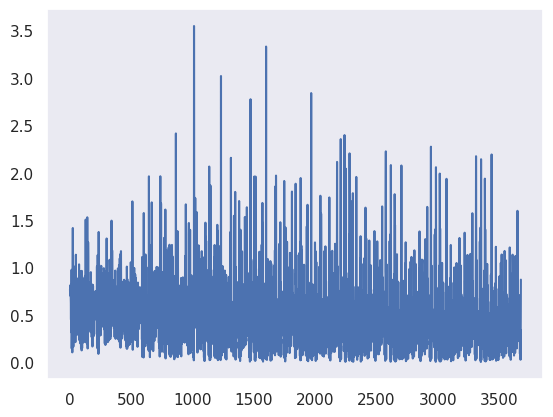

In [13]:
plt.plot(train_losses)

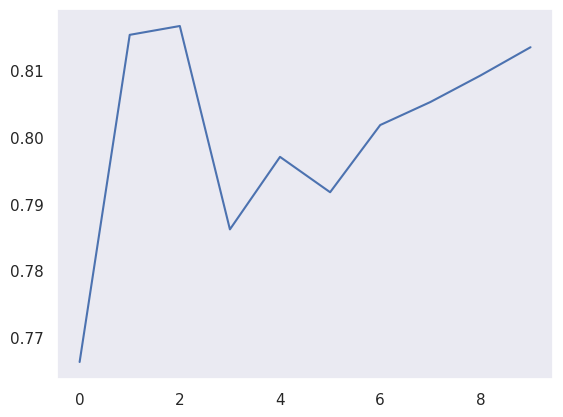

In [14]:
plt.plot(test_accuracy)

In [15]:
model_path = '../physio16k_fold1_m13_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [16]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from torchmetrics.wrappers import ClasswiseWrapper
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [17]:
metrics, confusion_matrix = report_metrics(model)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 3065/3744 (0.8186)
{'acc_detail': tensor([0.3403, 0.9608], device='cuda:0'),
 'acc_unweighted': tensor(0.6506, device='cuda:0'),
 'acc_weighted': tensor(0.8186, device='cuda:0'),
 'f1s': tensor(0.6767, device='cuda:0'),
 'f1s_detail': tensor([0.4624, 0.8909], device='cuda:0'),
 'precision_detail': tensor([0.7210, 0.8305], device='cuda:0'),
 'recall_detail': tensor([0.3403, 0.9608], device='cuda:0'),
 'rocauc': tensor([0.8642, 0.8642], device='cuda:0'),
 'uar': tensor(0.6506, device='cuda:0'),
 'wap': tensor(0.8054, device='cuda:0')}


tensor([[ 292,  566],
        [ 113, 2773]], device='cuda:0')

In [18]:
layer = model.fe_blocks.blocks[0].block.layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0036],
        [0.0075],
        [0.0117],
        [0.0162],
        [0.0211],
        [0.0264],
        [0.0322],
        [0.0384],
        [0.0451],
        [0.0524],
        [0.0603],
        [0.0688],
        [0.0780],
        [0.0880],
        [0.0988],
        [0.1105],
        [0.1231],
        [0.1368],
        [0.1516],
        [0.1676],
        [0.1849],
        [0.2036],
        [0.2239],
        [0.2458],
        [0.2696],
        [0.2952],
        [0.3230],
        [0.3531],
        [0.3856],
        [0.4208],
        [0.4588],
        [0.0000],
        [0.0054],
        [0.0111],
        [0.0171],
        [0.0235],
        [0.0303],
        [0.0375],
        [0.0452],
        [0.0534],
        [0.0620],
        [0.0712],
        [0.0809],
        [0.0912],
        [0.1022],
        [0.1138],
        [0.1261],
        [0.1392],
        [0.1531],
        [0.1679],
        [0.1835],
        [0.2002],
       

In [19]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [-1.4971e-15],
        [-4.4556e-15],
        [-3.7896e-14],
        [ 2.5393e-17],
        [-1.2970e-15],
        [ 3.0784e-17],
        [ 6.4874e-17],
        [ 5.8637e-15],
        [ 5.5322e-15],
        [-9.2800e-19],
        [ 9.3274e-17],
        [-6.5155e-19],
        [-2.9628e-15],
        [-1.7478e-16],
        [ 1.2195e-18],
        [ 5.6089e-20],
        [-7.3980e-17],
        [-1.2847e-18],
        [-1.1457e-17],
        [-3.8391e-16],
        [ 5.9995e-16],
        [ 9.4365e-15],
        [ 1.3930e-17],
        [-7.9110e-16],
        [-9.8448e-16],
        [ 5.8133e-16],
        [-2.5928e-17],
        [-6.6588e-16],
        [-1.6858e-13],
        [-8.5291e-14],
        [-7.3732e-17],
        [ 0.0000e+00],
        [-1.4481e-15],
        [-3.0429e-16],
        [ 1.4278e-14],
        [ 1.4105e-13],
        [ 2.5913e-16],
        [ 3.3633e-15],
        [ 2.5746e-15],
        [-8.4230e-16],
        [ 7.6721e-18],
        [-2.5554e-18],
        [ 7

[None, None, None]

(array([11.,  7.,  5.,  6.,  4.,  7.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
         1.,  3.,  4.,  3.,  2.,  3.,  3.,  3.,  2.,  2.,  2.,  3.,  2.,
         1.,  4.,  0.,  4.,  0.,  3.,  2.,  2.,  1.,  2.,  2.,  1.,  2.,
         3.]),
 array([0.        , 0.01191887, 0.02383774, 0.03575661, 0.04767548,
        0.05959435, 0.07151322, 0.08343209, 0.09535096, 0.10726982,
        0.1191887 , 0.13110757, 0.14302644, 0.1549453 , 0.16686417,
        0.17878304, 0.19070192, 0.20262079, 0.21453965, 0.22645852,
        0.23837739, 0.25029626, 0.26221514, 0.27413401, 0.28605288,
        0.29797173, 0.3098906 , 0.32180947, 0.33372834, 0.34564722,
        0.35756609, 0.36948496, 0.38140383, 0.39332271, 0.40524158,
        0.41716045, 0.42907929, 0.44099817, 0.45291704, 0.46483591,
        0.47675478]),
 <BarContainer object of 40 artists>)

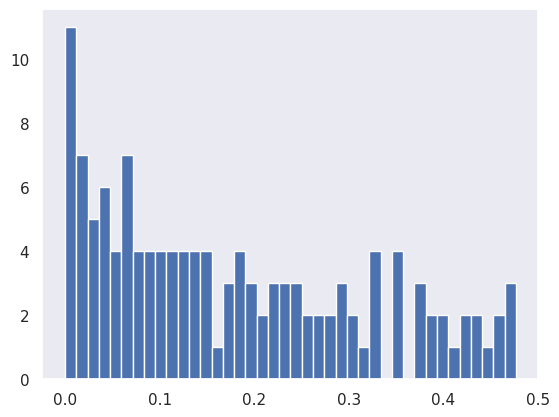

In [20]:
named_params = [p for p in layer.named_parameters()]
lowbands = named_params[0][1].detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.,   0.,   2.,   0.,   0.,   1.,   1.,   7., 106.,   4.,   0.,
          0.,   0.,   0.,   2.,   1.,   0.,   1.]),
 array([-4.33696265e-13, -4.19327577e-13, -4.04958890e-13, -3.90590202e-13,
        -3.76221515e-13, -3.61852827e-13, -3.47484140e-13, -3.33115453e-13,
        -3.18746765e-13, -3.04378078e-13, -2.90009390e-13, -2.75640730e-13,
        -2.61272042e-13, -2.46903355e-13, -2.32534668e-13, -2.18165980e-13,
        -2.03797293e-13, -1.89428605e-13, -1.75059918e-13, -1.60691230e-13,
        -1.46322543e-13, -1.31953855e-13, -1.17585168e-13, -1.03216487e-13,
        -8.88477998e-14, -7.44791124e-14, -6.01104249e-14, -4.57417409e-14,
        -3.13730534e-14, -1.70043677e-14, -2.63568193e-15,  1.17330038e-14,
         2.61016896e-14,  4.04703770e-14,  5.48390611e-14,  6.92077485e-14,
         8.35764360e-14,  9.79451234e-14, 

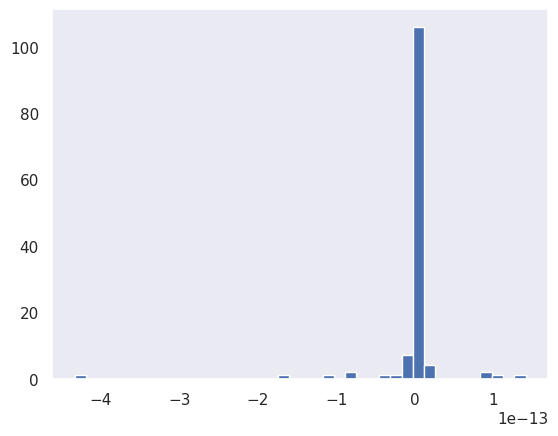

In [21]:
lowbands = named_params[0][1].grad.detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

/tmp/ipykernel_94151/1402059949.py:1: RuntimeWarning: divide by zero encountered in log
  grad_log = np.log(lowbands.flatten())
/tmp/ipykernel_94151/1402059949.py:1: RuntimeWarning: invalid value encountered in log
  grad_log = np.log(lowbands.flatten())


(array([1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 4., 1., 2., 3.,
        2., 1., 4., 3., 0., 2., 2., 2., 4., 2., 2., 3., 2., 2., 3., 2., 2.,
        2., 0., 0., 0., 2., 2.]),
 array([-44.3273468 , -43.95890427, -43.59046173, -43.2220192 ,
        -42.85357666, -42.48513412, -42.11669159, -41.74824905,
        -41.37980652, -41.01136398, -40.64292145, -40.27448273,
        -39.90604019, -39.53759766, -39.16915512, -38.80071259,
        -38.43227005, -38.06382751, -37.69538498, -37.32694244,
        -36.95849991, -36.59005737, -36.22161484, -35.8531723 ,
        -35.48472977, -35.11628723, -34.7478447 , -34.37940216,
        -34.01095963, -33.64251709, -33.27407837, -32.90563583,
        -32.5371933 , -32.16875076, -31.80030632, -31.43186569,
        -31.06342316, -30.69498062, -30.32653809, -29.95809555,
        -29.58965302]),
 <BarContainer object of 40 artists>)

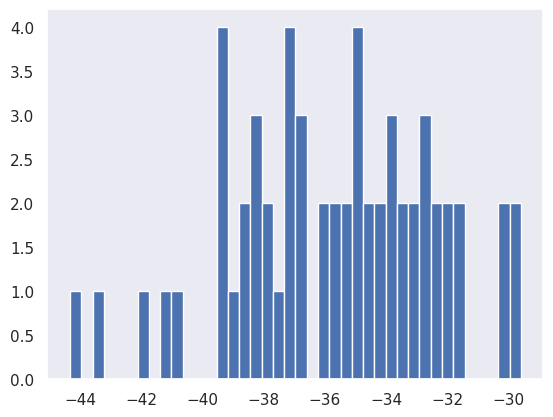

In [22]:
grad_log = np.log(lowbands.flatten())
grad_log = grad_log[grad_log > float('-inf')]
plt.hist(grad_log, bins=40)

(array([ 2.,  1.,  2.,  7., 10.,  7., 10., 10.,  6.,  4.]),
 array([-44.3273468 , -42.85357666, -41.37980652, -39.90604019,
        -38.43227005, -36.95849991, -35.48472977, -34.01095963,
        -32.5371933 , -31.06342316, -29.58965302]),
 <BarContainer object of 10 artists>)

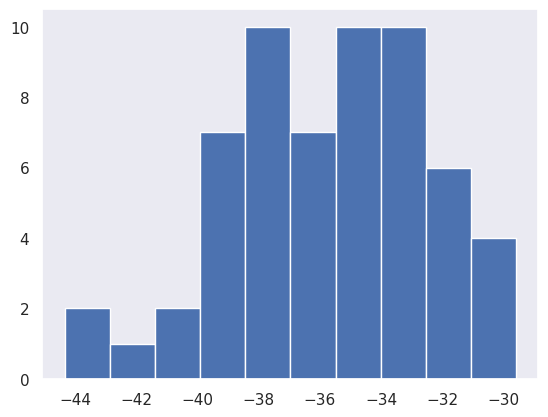

In [23]:
plt.hist(grad_log, bins=10)

(array([3., 4., 4., 5., 6., 6., 7., 8., 7., 5., 8., 6., 5., 5., 6., 3., 4.,
        5., 4., 4., 3., 3., 1., 3., 2., 2., 1., 0., 2., 0., 2., 0., 1., 1.,
        0., 0., 1., 0., 0., 1.]),
 array([0.0035846 , 0.00452443, 0.00546425, 0.00640408, 0.0073439 ,
        0.00828373, 0.00922356, 0.01016338, 0.01110321, 0.01204303,
        0.01298286, 0.01392268, 0.01486251, 0.01580233, 0.01674216,
        0.01768199, 0.01862181, 0.01956164, 0.02050146, 0.02144129,
        0.02238112, 0.02332094, 0.02426077, 0.02520059, 0.02614042,
        0.02708025, 0.02802007, 0.0289599 , 0.02989972, 0.03083955,
        0.03177937, 0.0327192 , 0.03365903, 0.03459885, 0.03553868,
        0.0364785 , 0.03741833, 0.03835815, 0.03929798, 0.0402378 ,
        0.04117763]),
 <BarContainer object of 40 artists>)

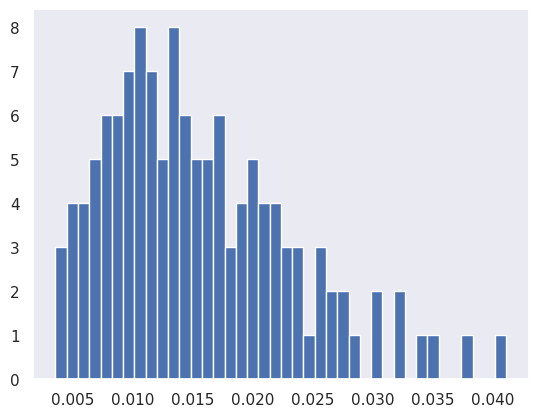

In [24]:
bandwidths = named_params[1][1].detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0., 115.,   5.,   1.,
          3.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-1.43408682e-13, -1.38761127e-13, -1.34113573e-13, -1.29466018e-13,
        -1.24818450e-13, -1.20170895e-13, -1.15523341e-13, -1.10875786e-13,
        -1.06228232e-13, -1.01580677e-13, -9.69331223e-14, -9.22855610e-14,
        -8.76380064e-14, -8.29904518e-14, -7.83428904e-14, -7.36953359e-14,
        -6.90477813e-14, -6.44002267e-14, -5.97526721e-14, -5.51051107e-14,
        -5.04575562e-14, -4.58100016e-14, -4.11624436e-14, -3.65148856e-14,
        -3.18673310e-14, -2.72197748e-14, -2.25722185e-14, -1.79246622e-14,
        -1.32771059e-14, -8.62954964e-15, -3.98199336e-15,  6.65562915e-16,
         5.31311919e-15,  9.96067547e-15,  1.46082318e-14,  1.92557880e-14,
         2.39033443e-14,  2.85508989e-14, 

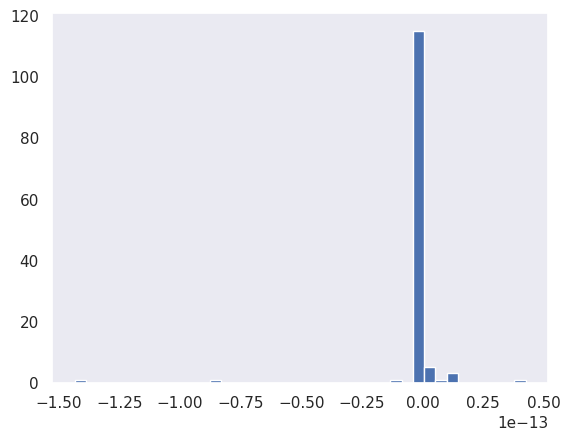

In [25]:
bandwidths = named_params[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

/tmp/ipykernel_94151/1421197636.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(bandwidths.flatten()), bins=40)


(array([2., 0., 1., 1., 1., 1., 0., 0., 2., 1., 0., 1., 0., 0., 2., 3., 3.,
        3., 1., 5., 2., 6., 4., 4., 2., 3., 4., 0., 2., 0., 1., 3., 0., 0.,
        2., 0., 2., 1., 0., 1.]),
 array([-45.64992142, -45.27840805, -44.90689468, -44.53538513,
        -44.16387177, -43.7923584 , -43.42084503, -43.04933548,
        -42.67782211, -42.30630875, -41.93479538, -41.56328583,
        -41.19177246, -40.82025909, -40.44874573, -40.07723618,
        -39.70572281, -39.33420944, -38.96269608, -38.59118652,
        -38.21967316, -37.84815979, -37.47664642, -37.10513306,
        -36.7336235 , -36.36211014, -35.99059677, -35.6190834 ,
        -35.24757385, -34.87606049, -34.50454712, -34.13303375,
        -33.7615242 , -33.39001083, -33.01849747, -32.6469841 ,
        -32.27547455, -31.90396118, -31.53244781, -31.16093636,
        -30.78942299]),
 <BarContainer object of 40 artists>)

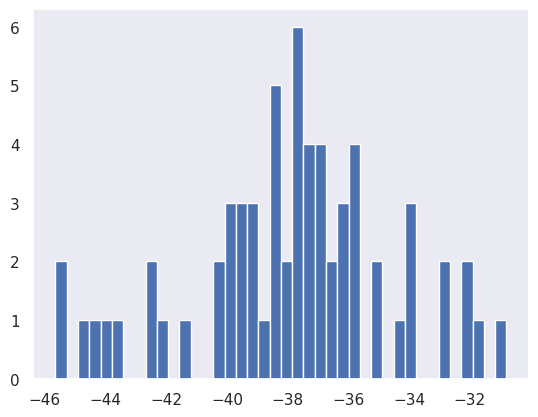

In [26]:
plt.hist(np.log(bandwidths.flatten()), bins=40)

(array([19., 65., 17.,  9., 14., 10.,  8.,  6., 14., 11.,  5., 10., 14.,
         5.,  6.,  5.,  2.,  5.,  2.,  4.,  3.,  4.,  3.,  6.,  5.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.]),
 array([-0.06787835, -0.01724605,  0.03338625,  0.08401854,  0.13465084,
         0.18528314,  0.23591544,  0.28654772,  0.33718002,  0.38781232,
         0.43844461,  0.48907691,  0.53970921,  0.59034151,  0.64097381,
         0.6916061 ,  0.7422384 ,  0.7928707 ,  0.843503  ,  0.8941353 ,
         0.94476759,  0.99539989,  1.04603219,  1.09666455,  1.14729679,
         1.19792914,  1.24856138,  1.29919374,  1.34982598,  1.40045834,
         1.45109057,  1.50172293,  1.55235517,  1.60298753,  1.65361977,
         1.70425212,  1.75488436,  1.80551672,  1.85614896,  1.90678132,
         1.95741355]),
 <BarContainer object of 40 artists>)

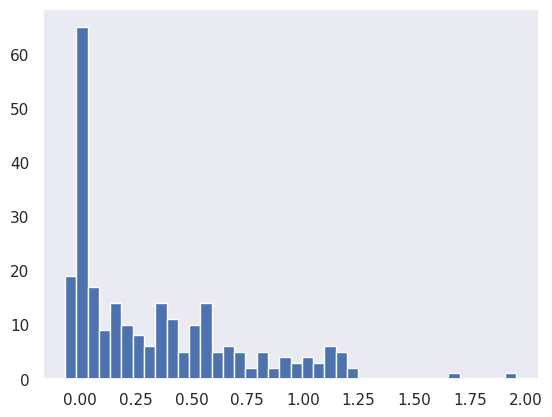

In [27]:
window_params = named_params[2][1].detach().cpu().numpy()
plt.hist(window_params.flatten(), bins=40)

(array([ 2.,  2.,  0.,  2.,  0.,  2.,  2.,  0.,  0.,  1.,  3.,  2.,  1.,
         3.,  3.,  1.,  1.,  3.,  3.,  3.,  6.,  5., 70., 64., 22.,  7.,
         5., 10., 11.,  6.,  3.,  3.,  1.,  1.,  2.,  2.,  0.,  1.,  0.,
         3.]),
 array([-0.12008677, -0.11485492, -0.10962306, -0.1043912 , -0.09915935,
        -0.09392749, -0.08869563, -0.08346377, -0.07823192, -0.07300006,
        -0.0677682 , -0.06253634, -0.05730449, -0.05207263, -0.04684078,
        -0.04160892, -0.03637706, -0.0311452 , -0.02591335, -0.02068149,
        -0.01544963, -0.01021777, -0.00498592,  0.00024594,  0.0054778 ,
         0.01070965,  0.01594151,  0.02117337,  0.02640522,  0.03163708,
         0.03686894,  0.04210079,  0.04733265,  0.05256451,  0.05779637,
         0.06302822,  0.06826008,  0.07349194,  0.0787238 ,  0.08395565,
         0.08918751]),
 <BarContainer object of 40 artists>)

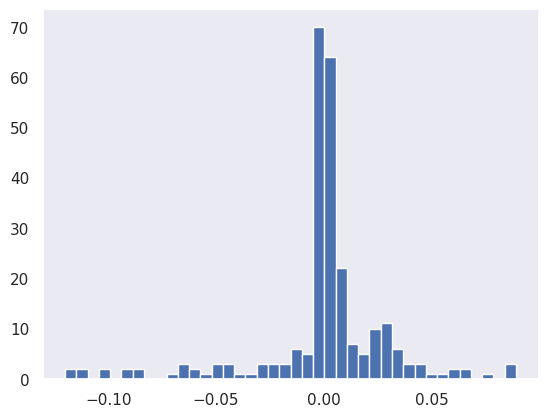

In [28]:
window_params = named_params[2][1].grad.detach().cpu().numpy()
plt.hist(window_params.flatten(), bins=40)

/tmp/ipykernel_94151/569063560.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(window_params.flatten()), bins=40)


(array([ 1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  3.,
         3.,  1.,  4.,  2.,  6., 10.,  2.,  7.,  4.,  5.,  6.,  5.,  4.,
         4., 12.,  6.,  4.,  3.,  3.,  5.,  9., 11.,  6.,  5.,  2.,  4.,
         4.]),
 array([-10.50598431, -10.30376053, -10.1015358 ,  -9.89931202,
         -9.69708729,  -9.49486351,  -9.29263878,  -9.090415  ,
         -8.88819027,  -8.68596649,  -8.48374176,  -8.28151798,
         -8.07929325,  -7.877069  ,  -7.67484474,  -7.47262049,
         -7.27039623,  -7.06817198,  -6.86594772,  -6.66372347,
         -6.46149921,  -6.25927496,  -6.0570507 ,  -5.85482645,
         -5.6526022 ,  -5.45037794,  -5.24815369,  -5.04592943,
         -4.84370518,  -4.64148092,  -4.43925667,  -4.23703241,
         -4.03480816,  -3.83258414,  -3.63035989,  -3.42813563,
         -3.22591138,  -3.02368712,  -2.82146287,  -2.61923862,
         -2.41701436]),
 <BarContainer object of 40 artists>)

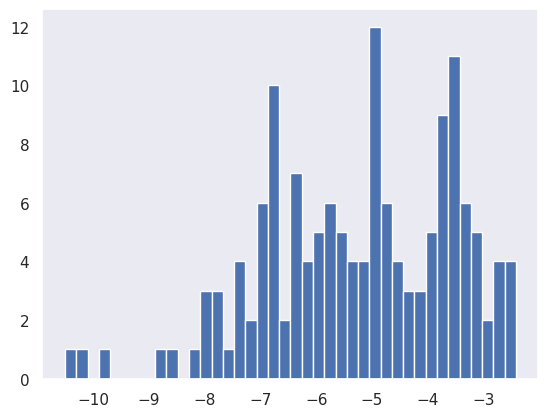

In [29]:
plt.hist(np.log(window_params.flatten()), bins=40)

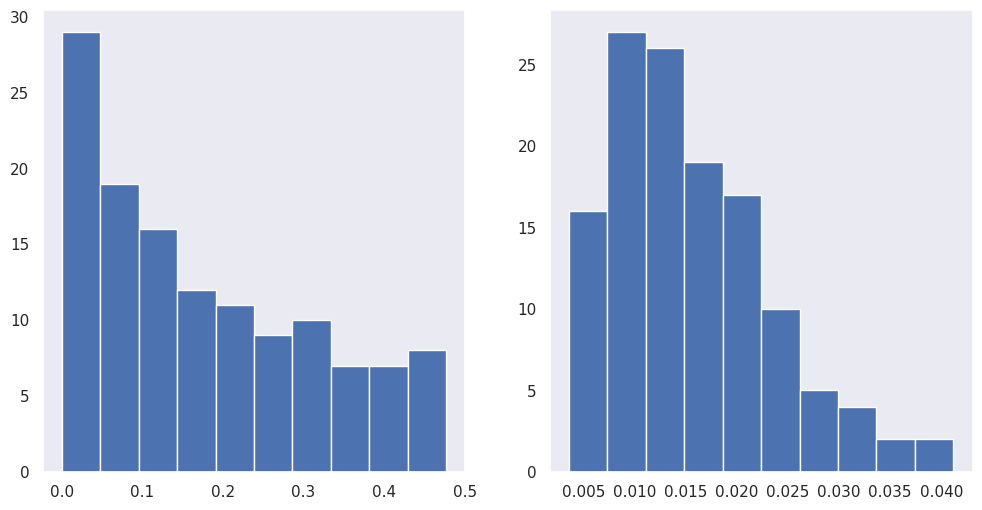

In [30]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

Time domain: Filters' shapes vary by frequency bins


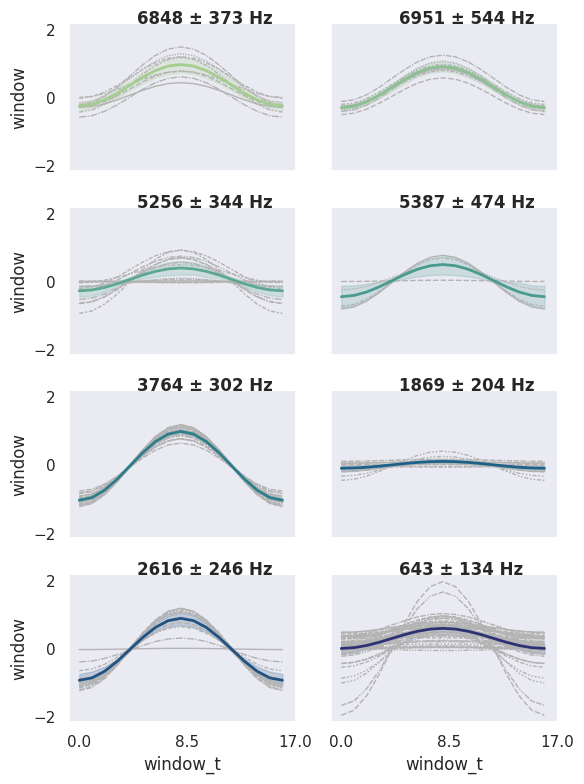

In [31]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


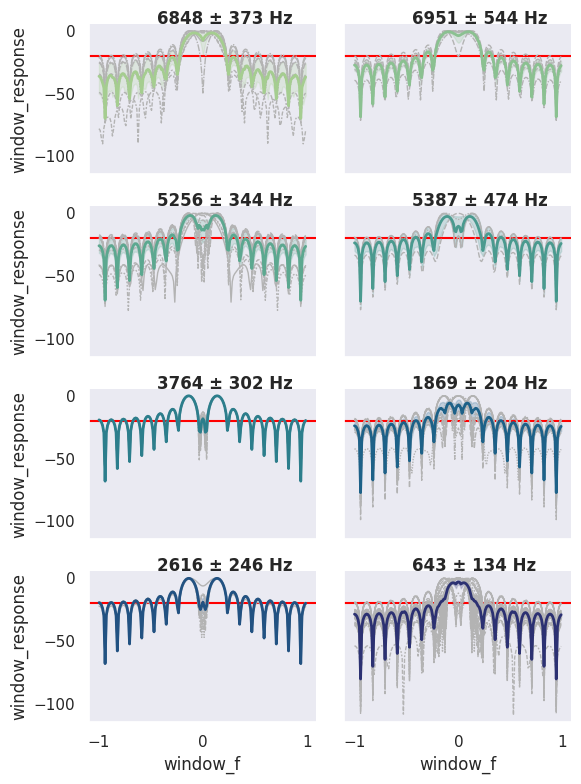

In [32]:
filtviz.visualize_filters(filter_domain='freq')

In [33]:
layer2 = model.fe_blocks.blocks[1].block.layer
visualize_model.print_parameters(layer2)

('lowcut_bands', Parameter containing:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        [0.0384, 0.0384, 0.0384,  ..., 0.0384, 0.0384, 0.0384],
        ...,
        [0.2594, 0.2594, 0.2594,  ..., 0.2594, 0.2594, 0.2594],
        [0.3309, 0.3309, 0.3309,  ..., 0.3309, 0.3309, 0.3309],
        [0.4108, 0.4108, 0.4108,  ..., 0.4108, 0.4108, 0.4108]],
       device='cuda:0', requires_grad=True))
('bandwidths', Parameter containing:
tensor([[0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        [0.0222, 0.0222, 0.0222,  ..., 0.0222, 0.0222, 0.0222],
        [0.0304, 0.0304, 0.0304,  ..., 0.0304, 0.0304, 0.0304],
        ...,
        [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
        [0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799],
        [0.0892, 0.0892, 0.0892,  ..., 0.0892, 0.0892, 0.0892]],
       device='cuda:0', requires_grad=True))
('window_params', Parameter containing

(array([512., 128., 128., 384.,   0., 128., 256.,   0., 256.,   0., 128.,
        128.,   0., 256.,   0.,   0., 256.,   0.,   0., 256.,   0.,   0.,
        128., 128.,   0., 128.,   0., 128.,   0., 128.,   0.,   0., 128.,
          0., 128.,   0., 128.,   0., 128., 128.]),
 array([0.        , 0.0102691 , 0.02053821, 0.03080731, 0.04107642,
        0.05134552, 0.06161463, 0.07188373, 0.08215284, 0.09242194,
        0.10269105, 0.11296015, 0.12322926, 0.13349836, 0.14376746,
        0.15403657, 0.16430567, 0.17457478, 0.18484388, 0.19511299,
        0.20538209, 0.2156512 , 0.2259203 , 0.23618941, 0.24645852,
        0.25672761, 0.26699671, 0.27726582, 0.28753492, 0.29780403,
        0.30807313, 0.31834224, 0.32861134, 0.33888045, 0.34914955,
        0.35941866, 0.36968777, 0.37995687, 0.39022598, 0.40049508,
        0.41076419]),
 <BarContainer object of 40 artists>)

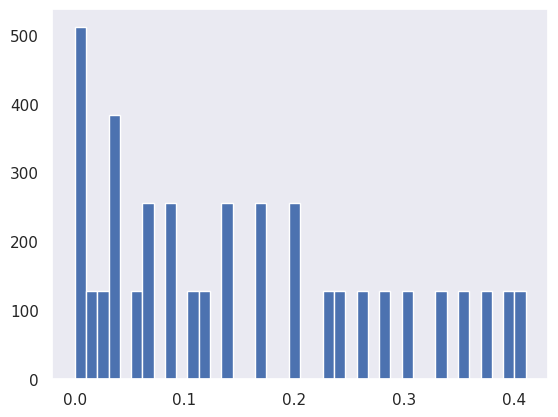

In [34]:
named_params2 = [p for p in layer2.named_parameters()]
lowbands2 = named_params2[0][1].detach().cpu().numpy()
plt.hist(lowbands2.flatten(), bins=40)

/tmp/ipykernel_94151/2621672499.py:1: RuntimeWarning: divide by zero encountered in log
  grad_log = np.log(named_params2[0][1].grad.detach().cpu().numpy().flatten())
/tmp/ipykernel_94151/2621672499.py:1: RuntimeWarning: invalid value encountered in log
  grad_log = np.log(named_params2[0][1].grad.detach().cpu().numpy().flatten())


(array([  2.,   3.,   3.,   9.,  10.,  14.,  19.,  20.,  29.,  30.,  40.,
         35.,  50.,  48.,  85.,  61.,  88.,  85.,  89.,  72.,  52.,  67.,
         56.,  68.,  79., 116.,  82.,  45.,  51.,  51.,  66.,  41.,  20.,
          6.,   6.,   5.,   4.,   3.,   2.,   4.]),
 array([-48.33404922, -47.94832611, -47.562603  , -47.17687988,
        -46.79115677, -46.40543365, -46.01971054, -45.63398743,
        -45.24826431, -44.8625412 , -44.4768219 , -44.09109879,
        -43.70537567, -43.31965256, -42.93392944, -42.54820633,
        -42.16248322, -41.7767601 , -41.39103699, -41.00531387,
        -40.61959076, -40.23386765, -39.84814453, -39.46242142,
        -39.0766983 , -38.69097519, -38.30525208, -37.91952896,
        -37.53380585, -37.14808273, -36.76235962, -36.37664032,
        -35.99091721, -35.60519409, -35.21947098, -34.83374786,
        -34.44802475, -34.06230164, -33.67657852, -33.29085541,
        -32.90513229]),
 <BarContainer object of 40 artists>)

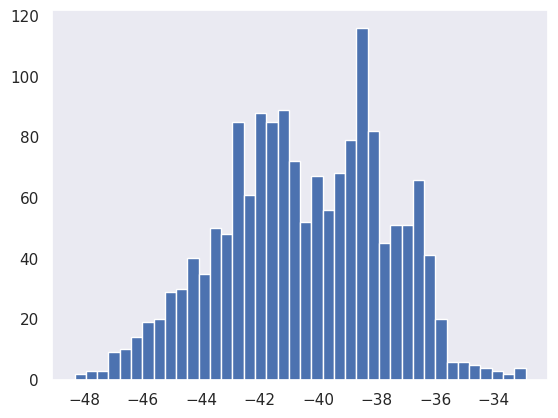

In [35]:
grad_log = np.log(named_params2[0][1].grad.detach().cpu().numpy().flatten())
grad_log = grad_log[grad_log > float('-inf')]
plt.hist(grad_log, bins=40)

(array([128., 128., 128.,   0., 384.,   0., 256., 256., 128., 256., 128.,
        128., 256., 128., 256.,   0., 128., 128., 256., 128.,   0.,   0.,
        256.,   0.,   0., 128.,   0., 256.,   0.,   0.,   0.,   0.,   0.,
        128.,   0.,   0.,   0.,   0.,   0., 128.]),
 array([0.01619883, 0.01946704, 0.02273525, 0.02600346, 0.02927167,
        0.03253987, 0.03580808, 0.03907629, 0.0423445 , 0.04561271,
        0.04888092, 0.05214913, 0.05541734, 0.05868555, 0.06195376,
        0.06522197, 0.06849018, 0.07175838, 0.07502659, 0.0782948 ,
        0.08156301, 0.08483122, 0.08809943, 0.09136764, 0.09463584,
        0.09790406, 0.10117227, 0.10444047, 0.10770869, 0.11097689,
        0.1142451 , 0.11751331, 0.12078152, 0.12404973, 0.12731794,
        0.13058615, 0.13385436, 0.13712257, 0.14039077, 0.14365898,
        0.14692719]),
 <BarContainer object of 40 artists>)

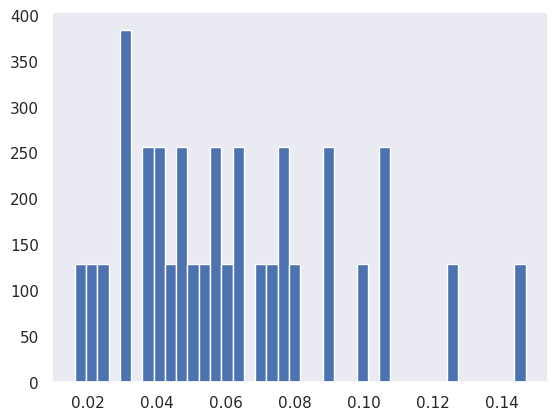

In [36]:
bandwidths2 = named_params2[1][1].detach().cpu().numpy()
plt.hist(bandwidths2.flatten(), bins=40)

/tmp/ipykernel_94151/4138814936.py:1: RuntimeWarning: invalid value encountered in log
  grad_log = np.log(named_params2[1][1].grad.detach().cpu().numpy().flatten())


(array([  1.,   0.,   0.,   0.,   1.,   0.,   3.,   5.,   4.,   8.,   6.,
          6.,  20.,  21.,  35.,  33.,  32.,  43.,  63.,  97., 120., 130.,
        143.,  99.,  84., 119., 113.,  94.,  60.,  51.,  51.,  69.,  94.,
         84.,  73.,  48.,  28.,  38.,  14.,   6.]),
 array([-54.07427979, -53.61101151, -53.14773941, -52.68447113,
        -52.22119904, -51.75793076, -51.29466248, -50.83139038,
        -50.3681221 , -49.90485382, -49.44158173, -48.97831345,
        -48.51504517, -48.05177307, -47.58850479, -47.1252327 ,
        -46.66196442, -46.19869614, -45.73542404, -45.27215576,
        -44.80888367, -44.34561539, -43.88234711, -43.41907501,
        -42.95580673, -42.49253845, -42.02926636, -41.56599808,
        -41.1027298 , -40.6394577 , -40.17618942, -39.71291733,
        -39.24964905, -38.78638077, -38.32310867, -37.85984039,
        -37.3965683 , -36.93330002, -36.47003174, -36.00675964,
        -35.54349136]),
 <BarContainer object of 40 artists>)

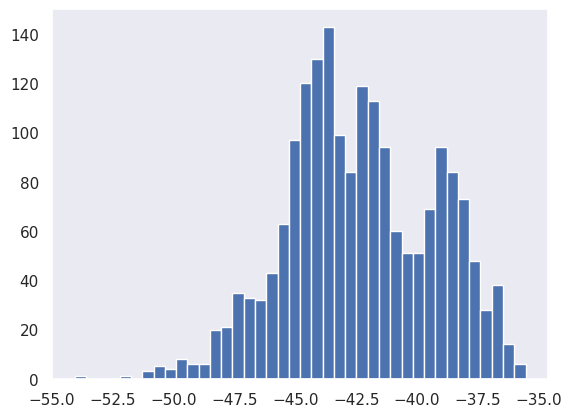

In [37]:
grad_log = np.log(named_params2[1][1].grad.detach().cpu().numpy().flatten())
grad_log = grad_log[grad_log > float('-inf')]
plt.hist(grad_log, bins=40)

(array([1.000e+00, 1.000e+00, 3.000e+00, 4.000e+00, 7.000e+00, 8.000e+00,
        2.000e+01, 1.600e+01, 4.000e+01, 6.400e+01, 9.100e+01, 1.100e+02,
        1.430e+02, 2.230e+02, 4.250e+02, 8.740e+02, 1.556e+03, 2.568e+03,
        4.729e+03, 5.743e+03, 5.688e+03, 4.388e+03, 3.253e+03, 2.110e+03,
        1.216e+03, 8.110e+02, 6.250e+02, 5.530e+02, 4.860e+02, 3.630e+02,
        2.740e+02, 1.640e+02, 1.160e+02, 5.600e+01, 4.900e+01, 2.600e+01,
        1.900e+01, 2.000e+01, 1.600e+01, 5.000e+00]),
 array([-2.23741126, -2.10673714, -1.97606289, -1.84538865, -1.71471453,
        -1.58404028, -1.45336616, -1.32269192, -1.19201779, -1.06134355,
        -0.93066937, -0.79999518, -0.669321  , -0.53864682, -0.4079726 ,
        -0.27729842, -0.14662424, -0.01595004,  0.11472414,  0.24539834,
         0.37607253,  0.50674671,  0.63742089,  0.76809508,  0.89876926,
         1.0294435 ,  1.16011763,  1.29079187,  1.42146599,  1.55214024,
         1.68281436,  1.8134886 ,  1.94416285,  2.07483697,  2.2

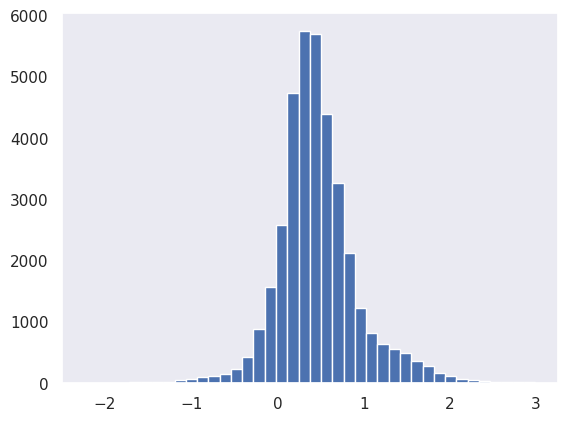

In [38]:
winparams2 = named_params2[2][1].detach().cpu().numpy()
plt.hist(winparams2.flatten(), bins=40)

(array([4.0000e+00, 1.0000e+00, 5.0000e+00, 1.9000e+01, 1.5000e+01,
        2.5000e+01, 9.3000e+01, 2.1100e+02, 6.3300e+02, 3.7950e+03,
        3.0155e+04, 1.1160e+03, 2.8200e+02, 2.0800e+02, 8.5000e+01,
        4.7000e+01, 3.4000e+01, 2.7000e+01, 2.8000e+01, 9.0000e+00,
        1.2000e+01, 1.1000e+01, 6.0000e+00, 1.0000e+01, 5.0000e+00,
        2.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00, 3.0000e+00,
        5.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-0.00789317, -0.00712081, -0.00634846, -0.00557611, -0.00480375,
        -0.0040314 , -0.00325905, -0.00248669, -0.00171434, -0.00094198,
        -0.00016963,  0.00060272,  0.00137508,  0.00214743,  0.00291978,
         0.00369214,  0.00446449,  0.00523685,  0.0060092 ,  0.00678155,
         0.00755391,  0.00832626,  0.00909861,  0.00987097,  0.01064332,
         0.01141568,  0.01218803,  0.01296038,  0.01373274,  0.01450509,
         0.01527

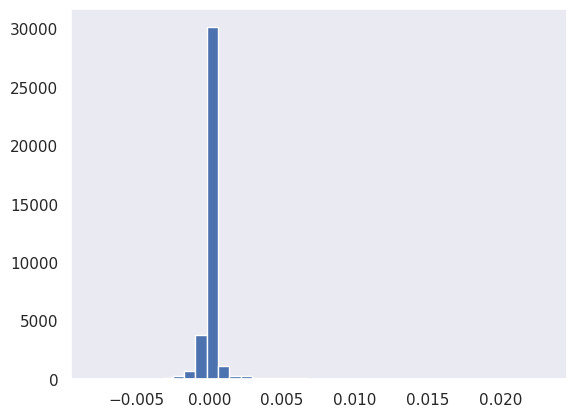

In [39]:
winparams2_grad = named_params2[2][1].grad.detach().cpu().numpy()
plt.hist(winparams2_grad.flatten(), bins=40)

/tmp/ipykernel_94151/2626591213.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(winparams2_grad.flatten()), bins=40)


(array([1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        3.000e+00, 3.000e+00, 6.000e+00, 6.000e+00, 1.200e+01, 1.400e+01,
        2.700e+01, 3.700e+01, 7.900e+01, 1.180e+02, 1.800e+02, 2.430e+02,
        3.510e+02, 5.140e+02, 6.670e+02, 9.990e+02, 1.047e+03, 1.176e+03,
        1.381e+03, 1.409e+03, 1.258e+03, 1.121e+03, 1.158e+03, 1.259e+03,
        1.281e+03, 1.098e+03, 9.150e+02, 5.590e+02, 3.230e+02, 2.870e+02,
        1.230e+02, 7.400e+01, 3.600e+01, 2.000e+01]),
 array([-23.16735077, -22.68247223, -22.19759369, -21.71271515,
        -21.22783661, -20.74295998, -20.25808144, -19.7732029 ,
        -19.28832436, -18.80344582, -18.31856728, -17.83368874,
        -17.3488102 , -16.86393356, -16.37905502, -15.89417648,
        -15.40929794, -14.9244194 , -14.43954086, -13.95466328,
        -13.46978474, -12.9849062 , -12.50002766, -12.01515007,
        -11.53027153, -11.04539299, -10.56051445, -10.07563686,
         -9.59075832,  -9.10587978,  -8.62100124,  -8.

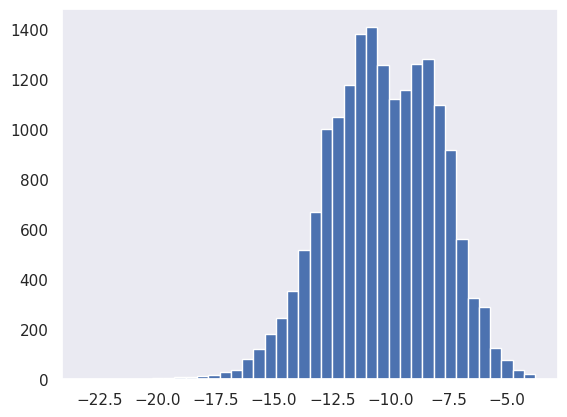

In [40]:
plt.hist(np.log(winparams2_grad.flatten()), bins=40)

downsample_factor: 8 => new_sample_rate: 2000


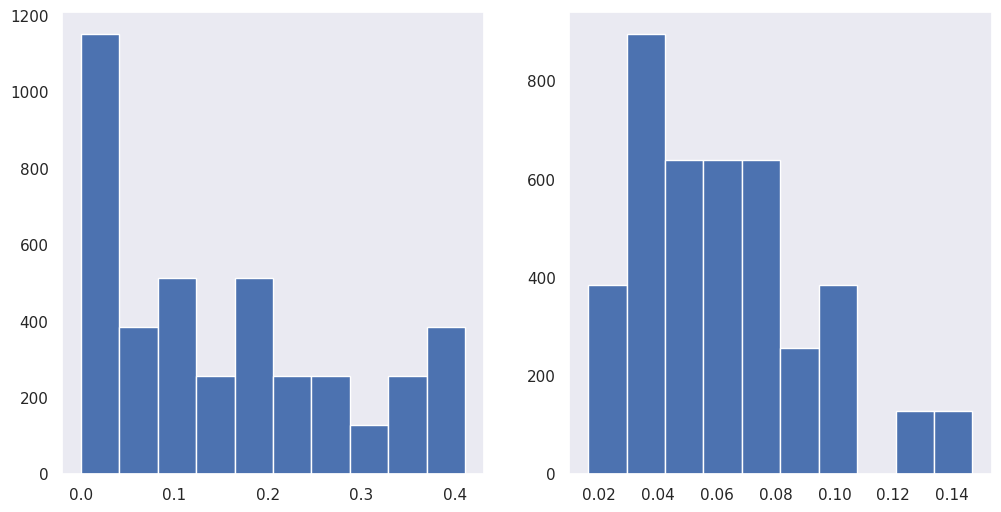

In [41]:
downsample_factor = model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_bands()

Time domain: Filters' shapes vary by frequency bins


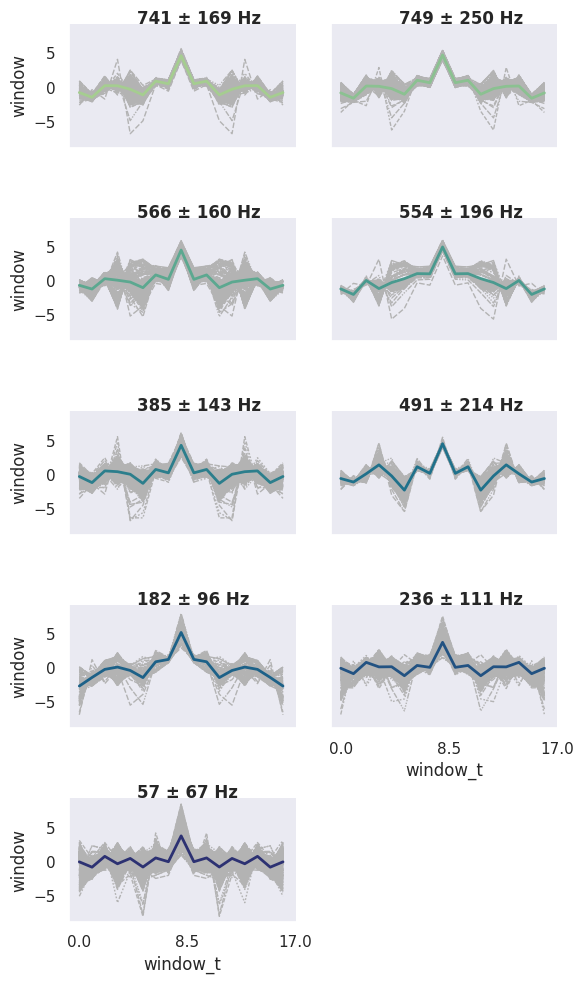

In [42]:
filtviz2.visualize_filters('time')

Frequency domain: Filters' shapes vary by frequency bins


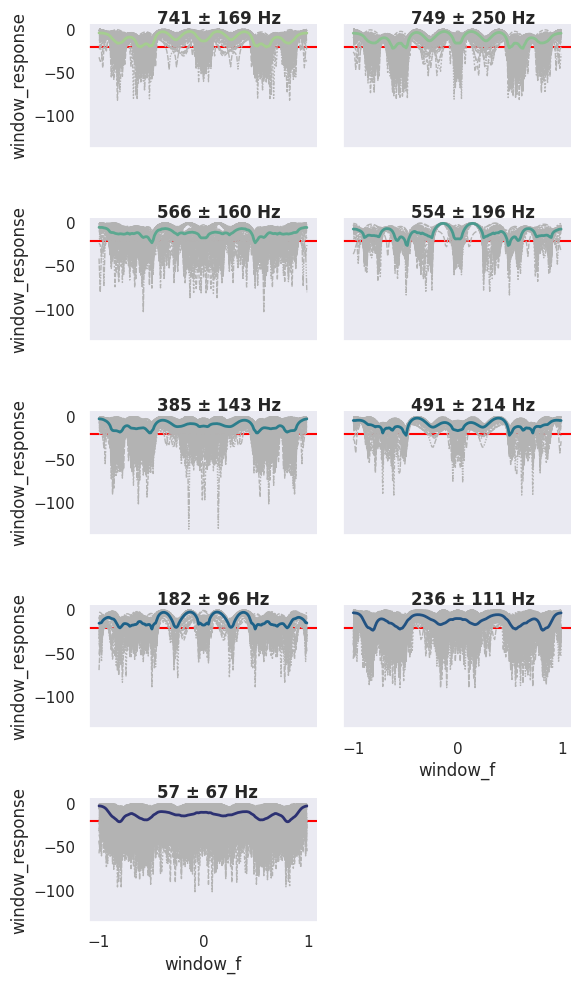

In [43]:
filtviz2.visualize_filters('freq')

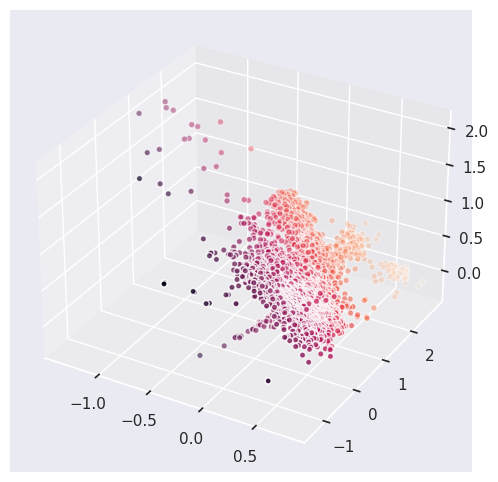

In [44]:
filtviz2.visualize_window_params()

In [45]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                                                                                                           | 0.002061855670103093/50 [00:00<6:02:22, 434.86s/it]

Train Epoch: 11 [0/11805 (0%)]	Loss: 1.136552
Mem before-during-after: 32564736 4375912960 33807872


  0%|▎                                                                                                                                                                           | 0.08453608247422686/50 [00:22<3:35:34, 259.13s/it]

Train Epoch: 11 [1280/11805 (11%)]	Loss: 0.012252
Mem before-during-after: 33807872 4377533952 33807872


  0%|▌                                                                                                                                                                           | 0.16701030927835056/50 [00:43<3:35:48, 259.83s/it]

Train Epoch: 11 [2560/11805 (22%)]	Loss: 0.430004
Mem before-during-after: 33807872 4377533952 33807872


  0%|▊                                                                                                                                                                           | 0.24948453608247398/50 [01:05<3:36:08, 260.68s/it]

Train Epoch: 11 [3840/11805 (33%)]	Loss: 0.090745
Mem before-during-after: 33807872 4377533952 33807872


  1%|█▏                                                                                                                                                                           | 0.3319587628865974/50 [01:26<3:35:58, 260.90s/it]

Train Epoch: 11 [5120/11805 (43%)]	Loss: 0.082713
Mem before-during-after: 33807872 4377533952 33807872


  1%|█▍                                                                                                                                                                          | 0.41443298969072084/50 [01:47<3:32:58, 257.71s/it]

Train Epoch: 11 [6400/11805 (54%)]	Loss: 1.054630
Mem before-during-after: 33807872 4377533952 33807872


  1%|█▋                                                                                                                                                                          | 0.49690721649484426/50 [02:08<3:33:35, 258.89s/it]

Train Epoch: 11 [7680/11805 (65%)]	Loss: 0.488197
Mem before-during-after: 33807872 4377533952 33807872


  1%|██                                                                                                                                                                           | 0.5793814432989677/50 [02:30<3:33:20, 259.00s/it]

Train Epoch: 11 [8960/11805 (76%)]	Loss: 0.483856
Mem before-during-after: 33807872 4377533952 33807872


  1%|██▎                                                                                                                                                                          | 0.6618556701030911/50 [02:51<3:34:14, 260.53s/it]

Train Epoch: 11 [10240/11805 (87%)]	Loss: 0.061046
Mem before-during-after: 33807872 4377533952 33807872


  1%|██▌                                                                                                                                                                          | 0.7443298969072145/50 [03:12<3:34:34, 261.37s/it]

Train Epoch: 11 [11520/11805 (98%)]	Loss: 0.413867
Mem before-during-after: 33807872 4377533952 33807872


  2%|███▍                                                                                                                                                                         | 0.9999999999999971/50 [03:53<2:11:20, 160.82s/it]


Test Epoch: 11	Accuracy: 3226/3744 (86%)



  2%|███▍                                                                                                                                                                         | 1.0020618556701002/50 [03:54<2:36:46, 191.99s/it]

Train Epoch: 12 [0/11805 (0%)]	Loss: 0.614943
Mem before-during-after: 33800704 4377230848 34742272


  2%|███▊                                                                                                                                                                         | 1.0845360824742236/50 [04:15<3:34:00, 262.51s/it]

Train Epoch: 12 [1280/11805 (11%)]	Loss: 0.007739
Mem before-during-after: 33938944 4376788480 34299904


  2%|████                                                                                                                                                                          | 1.167010309278347/50 [04:36<3:32:38, 261.26s/it]

Train Epoch: 12 [2560/11805 (22%)]	Loss: 0.297856
Mem before-during-after: 34332672 4377010176 33807872


  2%|████▎                                                                                                                                                                        | 1.2494845360824705/50 [04:57<3:29:39, 258.04s/it]

Train Epoch: 12 [3840/11805 (33%)]	Loss: 0.073993
Mem before-during-after: 34095104 4376600064 34226176


  3%|████▌                                                                                                                                                                        | 1.3319587628865939/50 [05:19<3:31:23, 260.61s/it]

Train Epoch: 12 [5120/11805 (43%)]	Loss: 0.088425
Mem before-during-after: 33807872 4376919552 33938944


  3%|████▉                                                                                                                                                                        | 1.4144329896907173/50 [05:40<3:31:04, 260.67s/it]

Train Epoch: 12 [6400/11805 (54%)]	Loss: 1.020566
Mem before-during-after: 33938944 4375772672 34332672


  3%|█████▏                                                                                                                                                                       | 1.4969072164948407/50 [06:01<3:30:55, 260.92s/it]

Train Epoch: 12 [7680/11805 (65%)]	Loss: 0.544243
Mem before-during-after: 33938944 4376837632 34095104


  3%|█████▍                                                                                                                                                                       | 1.5793814432989641/50 [06:22<3:30:02, 260.27s/it]

Train Epoch: 12 [8960/11805 (76%)]	Loss: 0.452174
Mem before-during-after: 33807872 4375739904 33807872


  3%|█████▊                                                                                                                                                                       | 1.6618556701030875/50 [06:44<3:43:22, 277.27s/it]

Train Epoch: 12 [10240/11805 (87%)]	Loss: 0.048960
Mem before-during-after: 34061824 4375772672 33938944


  3%|██████                                                                                                                                                                        | 1.744329896907211/50 [07:05<3:29:42, 260.74s/it]

Train Epoch: 12 [11520/11805 (98%)]	Loss: 0.396403
Mem before-during-after: 34299904 4376837632 33938944


  4%|██████▉                                                                                                                                                                      | 1.9999999999999936/50 [07:47<2:06:53, 158.61s/it]


Test Epoch: 12	Accuracy: 3228/3744 (86%)



  4%|██████▉                                                                                                                                                                       | 2.002061855670097/50 [07:47<2:31:13, 189.05s/it]

Train Epoch: 13 [0/11805 (0%)]	Loss: 0.631125
Mem before-during-after: 33800704 4377148928 33807872


  4%|███████▏                                                                                                                                                                     | 2.0845360824742203/50 [08:08<3:27:33, 259.91s/it]

Train Epoch: 13 [1280/11805 (11%)]	Loss: 0.007097
Mem before-during-after: 33807872 4377533952 33807872


  4%|███████▍                                                                                                                                                                     | 2.1670103092783437/50 [08:30<3:27:21, 260.11s/it]

Train Epoch: 13 [2560/11805 (22%)]	Loss: 0.289836
Mem before-during-after: 33807872 4377533952 33807872


  4%|███████▊                                                                                                                                                                      | 2.249484536082467/50 [08:51<3:31:50, 266.19s/it]

Train Epoch: 13 [3840/11805 (33%)]	Loss: 0.080348
Mem before-during-after: 33807872 4377533952 33807872


  5%|████████                                                                                                                                                                     | 2.3319587628865905/50 [09:12<3:28:09, 262.01s/it]

Train Epoch: 13 [5120/11805 (43%)]	Loss: 0.086563
Mem before-during-after: 33807872 4377533952 33807872


  5%|████████▍                                                                                                                                                                     | 2.414432989690714/50 [09:33<3:27:00, 261.02s/it]

Train Epoch: 13 [6400/11805 (54%)]	Loss: 0.935145
Mem before-during-after: 33807872 4377533952 33807872


  5%|████████▋                                                                                                                                                                    | 2.4969072164948374/50 [09:54<3:24:43, 258.57s/it]

Train Epoch: 13 [7680/11805 (65%)]	Loss: 0.626559
Mem before-during-after: 33807872 4377533952 33807872


  5%|████████▉                                                                                                                                                                     | 2.579381443298961/50 [10:16<3:24:29, 258.74s/it]

Train Epoch: 13 [8960/11805 (76%)]	Loss: 0.454287
Mem before-during-after: 33807872 4377533952 33807872


  5%|█████████▎                                                                                                                                                                    | 2.661855670103084/50 [10:37<3:24:15, 258.89s/it]

Train Epoch: 13 [10240/11805 (87%)]	Loss: 0.056225
Mem before-during-after: 33807872 4377533952 33807872


  5%|█████████▍                                                                                                                                                                   | 2.7443298969072076/50 [10:58<3:28:49, 265.14s/it]

Train Epoch: 13 [11520/11805 (98%)]	Loss: 0.346433
Mem before-during-after: 33807872 4377533952 33807872


  6%|██████████▍                                                                                                                                                                  | 2.9999999999999902/50 [11:40<2:01:58, 155.72s/it]


Test Epoch: 13	Accuracy: 3212/3744 (85%)



  6%|██████████▍                                                                                                                                                                  | 3.0020618556700933/50 [11:41<2:29:09, 190.42s/it]

Train Epoch: 14 [0/11805 (0%)]	Loss: 0.668678
Mem before-during-after: 33800704 4377230848 34742272


  6%|██████████▋                                                                                                                                                                  | 3.0845360824742167/50 [12:02<3:22:46, 259.33s/it]

Train Epoch: 14 [1280/11805 (11%)]	Loss: 0.003347
Mem before-during-after: 33938944 4376788480 34299904


  6%|███████████                                                                                                                                                                    | 3.16701030927834/50 [12:23<3:22:15, 259.12s/it]

Train Epoch: 14 [2560/11805 (22%)]	Loss: 0.287722
Mem before-during-after: 34332672 4377010176 33807872


  6%|███████████▏                                                                                                                                                                 | 3.2494845360824636/50 [12:44<3:21:45, 258.94s/it]

Train Epoch: 14 [3840/11805 (33%)]	Loss: 0.084905
Mem before-during-after: 34095104 4376600064 34226176


  7%|███████████▌                                                                                                                                                                  | 3.331958762886587/50 [13:05<3:21:19, 258.84s/it]

Train Epoch: 14 [5120/11805 (43%)]	Loss: 0.093536
Mem before-during-after: 33807872 4376919552 33938944


  7%|███████████▊                                                                                                                                                                 | 3.4144329896907104/50 [13:26<3:24:09, 262.95s/it]

Train Epoch: 14 [6400/11805 (54%)]	Loss: 0.893697
Mem before-during-after: 33938944 4375772672 34332672


  7%|████████████▏                                                                                                                                                                 | 3.496907216494834/50 [13:48<3:21:27, 259.93s/it]

Train Epoch: 14 [7680/11805 (65%)]	Loss: 0.688179
Mem before-during-after: 33938944 4376837632 34095104


  7%|████████████▍                                                                                                                                                                | 3.5793814432989572/50 [14:09<3:21:34, 260.54s/it]

Train Epoch: 14 [8960/11805 (76%)]	Loss: 0.461127
Mem before-during-after: 33807872 4375739904 33807872


  7%|████████████▋                                                                                                                                                                | 3.6618556701030807/50 [14:30<3:20:01, 258.99s/it]

Train Epoch: 14 [10240/11805 (87%)]	Loss: 0.056759
Mem before-during-after: 34061824 4375772672 33938944


  7%|█████████████                                                                                                                                                                 | 3.744329896907204/50 [14:51<3:19:40, 259.01s/it]

Train Epoch: 14 [11520/11805 (98%)]	Loss: 0.290825
Mem before-during-after: 34299904 4376837632 33938944


  8%|█████████████▊                                                                                                                                                               | 3.9999999999999867/50 [15:32<1:59:27, 155.80s/it]


Test Epoch: 14	Accuracy: 3192/3744 (85%)



  8%|██████████████                                                                                                                                                                 | 4.00206185567009/50 [15:33<2:24:27, 188.43s/it]

Train Epoch: 15 [0/11805 (0%)]	Loss: 0.719012
Mem before-during-after: 33800704 4377148928 33807872


  8%|██████████████▏                                                                                                                                                               | 4.084536082474213/50 [15:54<3:18:20, 259.19s/it]

Train Epoch: 15 [1280/11805 (11%)]	Loss: 0.005685
Mem before-during-after: 33807872 4377533952 33807872


  8%|██████████████▌                                                                                                                                                               | 4.167010309278337/50 [16:15<3:18:21, 259.66s/it]

Train Epoch: 15 [2560/11805 (22%)]	Loss: 0.277351
Mem before-during-after: 33807872 4377533952 33807872


  8%|██████████████▊                                                                                                                                                                | 4.24948453608246/50 [16:36<3:18:29, 260.32s/it]

Train Epoch: 15 [3840/11805 (33%)]	Loss: 0.074366
Mem before-during-after: 33807872 4377533952 33807872


  9%|███████████████                                                                                                                                                               | 4.331958762886583/50 [16:57<3:17:44, 259.80s/it]

Train Epoch: 15 [5120/11805 (43%)]	Loss: 0.090482
Mem before-during-after: 33807872 4377533952 33807872


  9%|███████████████▎                                                                                                                                                              | 4.414432989690707/50 [17:18<3:16:17, 258.35s/it]

Train Epoch: 15 [6400/11805 (54%)]	Loss: 0.859645
Mem before-during-after: 33807872 4377533952 33807872


  9%|███████████████▋                                                                                                                                                               | 4.49690721649483/50 [17:39<3:17:06, 259.91s/it]

Train Epoch: 15 [7680/11805 (65%)]	Loss: 0.712025
Mem before-during-after: 33807872 4377533952 33807872


  9%|███████████████▉                                                                                                                                                              | 4.579381443298954/50 [18:00<3:19:55, 264.10s/it]

Train Epoch: 15 [8960/11805 (76%)]	Loss: 0.477698
Mem before-during-after: 33807872 4377533952 33807872


  9%|████████████████▏                                                                                                                                                             | 4.661855670103077/50 [18:21<3:14:25, 257.31s/it]

Train Epoch: 15 [10240/11805 (87%)]	Loss: 0.057710
Mem before-during-after: 33807872 4377533952 33807872


  9%|████████████████▍                                                                                                                                                            | 4.7443298969072005/50 [18:42<3:15:04, 258.62s/it]

Train Epoch: 15 [11520/11805 (98%)]	Loss: 0.276660
Mem before-during-after: 33807872 4377533952 33807872


 10%|█████████████████▍                                                                                                                                                            | 4.999999999999983/50 [19:25<2:01:15, 161.68s/it]


Test Epoch: 15	Accuracy: 3183/3744 (84%)



 10%|█████████████████▍                                                                                                                                                            | 5.002061855670086/50 [19:25<2:25:37, 194.17s/it]

Train Epoch: 16 [0/11805 (0%)]	Loss: 0.724162
Mem before-during-after: 33800704 4377230848 34742272


 10%|█████████████████▊                                                                                                                                                             | 5.08453608247421/50 [19:46<3:14:35, 259.94s/it]

Train Epoch: 16 [1280/11805 (11%)]	Loss: 0.005668
Mem before-during-after: 33938944 4376788480 34299904


 10%|█████████████████▉                                                                                                                                                            | 5.167010309278333/50 [20:09<3:24:36, 273.84s/it]

Train Epoch: 16 [2560/11805 (22%)]	Loss: 0.287012
Mem before-during-after: 34332672 4377010176 33807872


 10%|██████████████████▏                                                                                                                                                          | 5.2494845360824565/50 [20:30<3:24:10, 273.74s/it]

Train Epoch: 16 [3840/11805 (33%)]	Loss: 0.074188
Mem before-during-after: 34095104 4376600064 34226176


 11%|██████████████████▋                                                                                                                                                            | 5.33195876288658/50 [20:52<3:13:20, 259.69s/it]

Train Epoch: 16 [5120/11805 (43%)]	Loss: 0.090455
Mem before-during-after: 33807872 4376919552 33938944


 11%|██████████████████▊                                                                                                                                                           | 5.414432989690703/50 [21:13<3:14:09, 261.29s/it]

Train Epoch: 16 [6400/11805 (54%)]	Loss: 0.826473
Mem before-during-after: 33938944 4375772672 34332672


 11%|███████████████████▏                                                                                                                                                          | 5.496907216494827/50 [21:35<3:16:56, 265.53s/it]

Train Epoch: 16 [7680/11805 (65%)]	Loss: 0.744462
Mem before-during-after: 33938944 4376837632 34095104


 11%|███████████████████▌                                                                                                                                                           | 5.57938144329895/50 [21:57<3:16:00, 264.74s/it]

Train Epoch: 16 [8960/11805 (76%)]	Loss: 0.498619
Mem before-during-after: 33807872 4375739904 33807872


 11%|███████████████████▋                                                                                                                                                          | 5.661855670103074/50 [22:18<3:15:13, 264.19s/it]

Train Epoch: 16 [10240/11805 (87%)]	Loss: 0.060024
Mem before-during-after: 34061824 4375772672 33938944


 11%|███████████████████▉                                                                                                                                                          | 5.744329896907197/50 [22:39<3:15:05, 264.49s/it]

Train Epoch: 16 [11520/11805 (98%)]	Loss: 0.223683
Mem before-during-after: 34299904 4376837632 33938944


 12%|████████████████████▉                                                                                                                                                          | 5.99999999999998/50 [23:21<1:53:31, 154.82s/it]


Test Epoch: 16	Accuracy: 3169/3744 (84%)



 12%|████████████████████▉                                                                                                                                                         | 6.002061855670083/50 [23:21<2:16:47, 186.54s/it]

Train Epoch: 17 [0/11805 (0%)]	Loss: 0.763282
Mem before-during-after: 33800704 4377148928 33807872


 12%|█████████████████████▏                                                                                                                                                        | 6.084536082474206/50 [23:43<3:10:35, 260.40s/it]

Train Epoch: 17 [1280/11805 (11%)]	Loss: 0.005557
Mem before-during-after: 33807872 4377533952 33807872


 12%|█████████████████████▎                                                                                                                                                       | 6.1670103092783295/50 [24:04<3:11:38, 262.33s/it]

Train Epoch: 17 [2560/11805 (22%)]	Loss: 0.298741
Mem before-during-after: 33807872 4377533952 33807872


 12%|█████████████████████▋                                                                                                                                                        | 6.249484536082453/50 [24:26<3:15:24, 267.98s/it]

Train Epoch: 17 [3840/11805 (33%)]	Loss: 0.074906
Mem before-during-after: 33807872 4377533952 33807872


 13%|██████████████████████                                                                                                                                                        | 6.331958762886576/50 [24:47<3:10:07, 261.22s/it]

Train Epoch: 17 [5120/11805 (43%)]	Loss: 0.070981
Mem before-during-after: 33807872 4377533952 33807872


 13%|██████████████████████▌                                                                                                                                                         | 6.4144329896907/50 [25:08<3:10:27, 262.19s/it]

Train Epoch: 17 [6400/11805 (54%)]	Loss: 0.829331
Mem before-during-after: 33807872 4377533952 33807872


 13%|██████████████████████▌                                                                                                                                                       | 6.496907216494823/50 [25:29<3:09:37, 261.54s/it]

Train Epoch: 17 [7680/11805 (65%)]	Loss: 0.769315
Mem before-during-after: 33807872 4377533952 33807872


 13%|██████████████████████▉                                                                                                                                                       | 6.579381443298947/50 [25:51<3:09:11, 261.44s/it]

Train Epoch: 17 [8960/11805 (76%)]	Loss: 0.480790
Mem before-during-after: 33807872 4377533952 33807872


 13%|███████████████████████▎                                                                                                                                                       | 6.66185567010307/50 [26:12<3:10:10, 263.30s/it]

Train Epoch: 17 [10240/11805 (87%)]	Loss: 0.061133
Mem before-during-after: 33807872 4377533952 33807872


 13%|███████████████████████▍                                                                                                                                                      | 6.744329896907193/50 [26:33<3:08:09, 260.99s/it]

Train Epoch: 17 [11520/11805 (98%)]	Loss: 0.220657
Mem before-during-after: 33807872 4377533952 33807872


 14%|████████████████████████▎                                                                                                                                                     | 6.999999999999976/50 [27:15<1:52:40, 157.22s/it]


Test Epoch: 17	Accuracy: 3170/3744 (84%)



 14%|████████████████████████▎                                                                                                                                                     | 7.002061855670079/50 [27:16<2:16:27, 190.41s/it]

Train Epoch: 18 [0/11805 (0%)]	Loss: 0.755038
Mem before-during-after: 33800704 4377230848 34742272


 14%|████████████████████████▌                                                                                                                                                    | 7.0845360824742025/50 [27:37<3:32:53, 297.65s/it]

Train Epoch: 18 [1280/11805 (11%)]	Loss: 0.003640
Mem before-during-after: 33938944 4376788480 34299904


 14%|████████████████████████▉                                                                                                                                                     | 7.167010309278326/50 [27:59<3:09:52, 265.98s/it]

Train Epoch: 18 [2560/11805 (22%)]	Loss: 0.298650
Mem before-during-after: 34332672 4377010176 33807872


 14%|█████████████████████████▏                                                                                                                                                    | 7.249484536082449/50 [28:20<3:05:46, 260.73s/it]

Train Epoch: 18 [3840/11805 (33%)]	Loss: 0.078557
Mem before-during-after: 34095104 4376600064 34226176


 15%|█████████████████████████▌                                                                                                                                                    | 7.331958762886573/50 [28:41<3:04:38, 259.64s/it]

Train Epoch: 18 [5120/11805 (43%)]	Loss: 0.075453
Mem before-during-after: 33807872 4376919552 33938944


 15%|█████████████████████████▊                                                                                                                                                    | 7.414432989690696/50 [29:04<3:07:38, 264.38s/it]

Train Epoch: 18 [6400/11805 (54%)]	Loss: 0.827999
Mem before-during-after: 33938944 4375772672 34332672


 15%|██████████████████████████▏                                                                                                                                                    | 7.49690721649482/50 [29:25<3:06:21, 263.08s/it]

Train Epoch: 18 [7680/11805 (65%)]	Loss: 0.784601
Mem before-during-after: 33938944 4376837632 34095104


 15%|██████████████████████████▍                                                                                                                                                   | 7.579381443298943/50 [29:47<3:06:03, 263.17s/it]

Train Epoch: 18 [8960/11805 (76%)]	Loss: 0.504884
Mem before-during-after: 33807872 4375739904 33807872


 15%|██████████████████████████▌                                                                                                                                                  | 7.6618556701030665/50 [30:09<3:03:46, 260.43s/it]

Train Epoch: 18 [10240/11805 (87%)]	Loss: 0.058062
Mem before-during-after: 34061824 4375772672 33938944


 15%|███████████████████████████                                                                                                                                                    | 7.74432989690719/50 [30:30<3:06:45, 265.19s/it]

Train Epoch: 18 [11520/11805 (98%)]	Loss: 0.212119
Mem before-during-after: 34299904 4376837632 33938944


 16%|███████████████████████████▋                                                                                                                                                 | 7.9999999999999725/50 [31:12<1:55:21, 164.80s/it]


Test Epoch: 18	Accuracy: 3169/3744 (84%)



 16%|███████████████████████████▊                                                                                                                                                  | 8.002061855670076/50 [31:13<2:17:40, 196.68s/it]

Train Epoch: 19 [0/11805 (0%)]	Loss: 0.759004
Mem before-during-after: 33800704 4377148928 33807872


 16%|████████████████████████████▍                                                                                                                                                   | 8.0845360824742/50 [31:34<3:02:49, 261.71s/it]

Train Epoch: 19 [1280/11805 (11%)]	Loss: 0.002778
Mem before-during-after: 33807872 4377533952 33807872


 16%|████████████████████████████▍                                                                                                                                                 | 8.167010309278323/50 [31:57<3:08:03, 269.72s/it]

Train Epoch: 19 [2560/11805 (22%)]	Loss: 0.317217
Mem before-during-after: 33807872 4377533952 33807872


 16%|████████████████████████████▋                                                                                                                                                 | 8.249484536082447/50 [32:18<3:06:21, 267.83s/it]

Train Epoch: 19 [3840/11805 (33%)]	Loss: 0.076591
Mem before-during-after: 33807872 4377533952 33807872


 17%|█████████████████████████████▏                                                                                                                                                 | 8.33195876288657/50 [32:40<3:02:25, 262.67s/it]

Train Epoch: 19 [5120/11805 (43%)]	Loss: 0.076695
Mem before-during-after: 33807872 4377533952 33807872


 17%|█████████████████████████████▎                                                                                                                                                | 8.414432989690694/50 [33:01<3:03:27, 264.68s/it]

Train Epoch: 19 [6400/11805 (54%)]	Loss: 0.818029
Mem before-during-after: 33807872 4377533952 33807872


 17%|█████████████████████████████▌                                                                                                                                                | 8.496907216494817/50 [33:22<3:01:18, 262.12s/it]

Train Epoch: 19 [7680/11805 (65%)]	Loss: 0.779161
Mem before-during-after: 33807872 4377533952 33807872


 17%|██████████████████████████████                                                                                                                                                 | 8.57938144329894/50 [33:44<3:02:01, 263.66s/it]

Train Epoch: 19 [8960/11805 (76%)]	Loss: 0.518566
Mem before-during-after: 33807872 4377533952 33807872


 17%|██████████████████████████████▏                                                                                                                                               | 8.661855670103064/50 [34:05<2:59:43, 260.86s/it]

Train Epoch: 19 [10240/11805 (87%)]	Loss: 0.064518
Mem before-during-after: 33807872 4377533952 33807872


 17%|██████████████████████████████▍                                                                                                                                               | 8.744329896907187/50 [34:27<3:01:05, 263.37s/it]

Train Epoch: 19 [11520/11805 (98%)]	Loss: 0.207379
Mem before-during-after: 33807872 4377533952 33807872


 18%|███████████████████████████████▍                                                                                                                                               | 8.99999999999997/50 [35:07<1:45:27, 154.32s/it]


Test Epoch: 19	Accuracy: 3171/3744 (84%)



 18%|███████████████████████████████▎                                                                                                                                              | 9.002061855670073/50 [35:08<2:08:59, 188.77s/it]

Train Epoch: 20 [0/11805 (0%)]	Loss: 0.780250
Mem before-during-after: 33800704 4377230848 34742272


 18%|███████████████████████████████▌                                                                                                                                              | 9.084536082474196/50 [35:30<3:17:20, 289.40s/it]

Train Epoch: 20 [1280/11805 (11%)]	Loss: 0.000682
Mem before-during-after: 33938944 4376788480 34299904


 18%|████████████████████████████████                                                                                                                                               | 9.16701030927832/50 [35:52<2:58:18, 262.00s/it]

Train Epoch: 20 [2560/11805 (22%)]	Loss: 0.288688
Mem before-during-after: 34332672 4377010176 33807872


 18%|████████████████████████████████▏                                                                                                                                             | 9.249484536082443/50 [36:13<2:56:41, 260.16s/it]

Train Epoch: 20 [3840/11805 (33%)]	Loss: 0.073374
Mem before-during-after: 34095104 4376600064 34226176


 19%|████████████████████████████████▍                                                                                                                                             | 9.331958762886567/50 [36:34<2:56:40, 260.67s/it]

Train Epoch: 20 [5120/11805 (43%)]	Loss: 0.067781
Mem before-during-after: 33807872 4376919552 33938944


 19%|████████████████████████████████▉                                                                                                                                              | 9.41443298969069/50 [36:56<2:56:32, 261.00s/it]

Train Epoch: 20 [6400/11805 (54%)]	Loss: 0.849654
Mem before-during-after: 33938944 4375772672 34332672


 19%|█████████████████████████████████                                                                                                                                             | 9.496907216494813/50 [37:17<2:57:48, 263.39s/it]

Train Epoch: 20 [7680/11805 (65%)]	Loss: 0.823954
Mem before-during-after: 33938944 4376837632 34095104


 19%|█████████████████████████████████▎                                                                                                                                            | 9.579381443298937/50 [37:38<2:55:48, 260.96s/it]

Train Epoch: 20 [8960/11805 (76%)]	Loss: 0.506354
Mem before-during-after: 33807872 4375739904 33807872


 19%|█████████████████████████████████▊                                                                                                                                             | 9.66185567010306/50 [37:59<3:00:45, 268.87s/it]

Train Epoch: 20 [10240/11805 (87%)]	Loss: 0.060571
Mem before-during-after: 34061824 4375772672 33938944


 19%|█████████████████████████████████▉                                                                                                                                            | 9.744329896907184/50 [38:21<2:56:29, 263.05s/it]

Train Epoch: 20 [11520/11805 (98%)]	Loss: 0.198604
Mem before-during-after: 34299904 4376837632 33938944


 20%|██████████████████████████████████▊                                                                                                                                           | 9.999999999999966/50 [39:01<1:40:19, 150.50s/it]


Test Epoch: 20	Accuracy: 3167/3744 (84%)



 20%|██████████████████████████████████▊                                                                                                                                           | 10.00206185567007/50 [39:01<2:03:05, 184.66s/it]

Train Epoch: 21 [0/11805 (0%)]	Loss: 0.792773
Mem before-during-after: 33800704 4377148928 33807872


 20%|██████████████████████████████████▉                                                                                                                                          | 10.084536082474193/50 [39:23<2:54:16, 261.97s/it]

Train Epoch: 21 [1280/11805 (11%)]	Loss: 0.004603
Mem before-during-after: 33807872 4377533952 33807872


 20%|███████████████████████████████████▏                                                                                                                                         | 10.167010309278316/50 [39:44<2:53:18, 261.05s/it]

Train Epoch: 21 [2560/11805 (22%)]	Loss: 0.296041
Mem before-during-after: 33807872 4377533952 33807872


 20%|███████████████████████████████████▋                                                                                                                                          | 10.24948453608244/50 [40:05<2:54:50, 263.91s/it]

Train Epoch: 21 [3840/11805 (33%)]	Loss: 0.071925
Mem before-during-after: 33807872 4377533952 33807872


 21%|███████████████████████████████████▋                                                                                                                                         | 10.331958762886563/50 [40:27<2:54:32, 264.00s/it]

Train Epoch: 21 [5120/11805 (43%)]	Loss: 0.068595
Mem before-during-after: 33807872 4377533952 33807872


 21%|████████████████████████████████████                                                                                                                                         | 10.414432989690686/50 [40:48<2:52:56, 262.13s/it]

Train Epoch: 21 [6400/11805 (54%)]	Loss: 0.833003
Mem before-during-after: 33807872 4377533952 33807872


 21%|████████████████████████████████████▌                                                                                                                                         | 10.49690721649481/50 [41:10<2:52:33, 262.09s/it]

Train Epoch: 21 [7680/11805 (65%)]	Loss: 0.789252
Mem before-during-after: 33807872 4377533952 33807872


 21%|████████████████████████████████████▌                                                                                                                                        | 10.579381443298933/50 [41:31<2:52:47, 263.01s/it]

Train Epoch: 21 [8960/11805 (76%)]	Loss: 0.523436
Mem before-during-after: 33807872 4377533952 33807872


 21%|████████████████████████████████████▉                                                                                                                                        | 10.661855670103057/50 [41:52<2:53:03, 263.95s/it]

Train Epoch: 21 [10240/11805 (87%)]	Loss: 0.059262
Mem before-during-after: 33807872 4377533952 33807872


 21%|█████████████████████████████████████▍                                                                                                                                        | 10.74432989690718/50 [42:14<2:51:07, 261.55s/it]

Train Epoch: 21 [11520/11805 (98%)]	Loss: 0.207682
Mem before-during-after: 33807872 4377533952 33807872


 22%|██████████████████████████████████████                                                                                                                                       | 10.999999999999963/50 [42:56<1:43:09, 158.70s/it]


Test Epoch: 21	Accuracy: 3171/3744 (84%)



 22%|██████████████████████████████████████                                                                                                                                       | 11.002061855670066/50 [42:57<2:03:43, 190.35s/it]

Train Epoch: 22 [0/11805 (0%)]	Loss: 0.757126
Mem before-during-after: 33800704 4377230848 34742272


 22%|██████████████████████████████████████▌                                                                                                                                       | 11.08453608247419/50 [43:18<2:48:59, 260.56s/it]

Train Epoch: 22 [1280/11805 (11%)]	Loss: 0.006861
Mem before-during-after: 33938944 4376788480 34299904


 22%|██████████████████████████████████████▋                                                                                                                                      | 11.167010309278313/50 [43:39<2:49:42, 262.21s/it]

Train Epoch: 22 [2560/11805 (22%)]	Loss: 0.304229
Mem before-during-after: 34332672 4377010176 33807872


 22%|██████████████████████████████████████▉                                                                                                                                      | 11.249484536082436/50 [44:01<2:49:10, 261.96s/it]

Train Epoch: 22 [3840/11805 (33%)]	Loss: 0.067709
Mem before-during-after: 34095104 4376600064 34226176


 23%|███████████████████████████████████████▍                                                                                                                                      | 11.33195876288656/50 [44:22<2:48:37, 261.64s/it]

Train Epoch: 22 [5120/11805 (43%)]	Loss: 0.072136
Mem before-during-after: 33807872 4376919552 33938944


 23%|███████████████████████████████████████▍                                                                                                                                     | 11.414432989690683/50 [44:44<2:52:30, 268.25s/it]

Train Epoch: 22 [6400/11805 (54%)]	Loss: 0.805807
Mem before-during-after: 33938944 4375772672 34332672


 23%|███████████████████████████████████████▊                                                                                                                                     | 11.496907216494806/50 [45:05<2:47:39, 261.26s/it]

Train Epoch: 22 [7680/11805 (65%)]	Loss: 0.794006
Mem before-during-after: 33938944 4376837632 34095104


 23%|████████████████████████████████████████▎                                                                                                                                     | 11.57938144329893/50 [45:26<2:46:29, 260.01s/it]

Train Epoch: 22 [8960/11805 (76%)]	Loss: 0.529056
Mem before-during-after: 33807872 4375739904 33807872


 23%|████████████████████████████████████████▎                                                                                                                                    | 11.661855670103053/50 [45:47<2:47:38, 262.36s/it]

Train Epoch: 22 [10240/11805 (87%)]	Loss: 0.056546
Mem before-during-after: 34061824 4375772672 33938944


 23%|████████████████████████████████████████▋                                                                                                                                    | 11.744329896907177/50 [46:09<2:46:35, 261.28s/it]

Train Epoch: 22 [11520/11805 (98%)]	Loss: 0.193088
Mem before-during-after: 34299904 4376837632 33938944


 24%|█████████████████████████████████████████▊                                                                                                                                    | 11.99999999999996/50 [46:51<1:41:04, 159.60s/it]


Test Epoch: 22	Accuracy: 3166/3744 (84%)



 24%|█████████████████████████████████████████▌                                                                                                                                   | 12.002061855670062/50 [46:51<2:00:28, 190.23s/it]

Train Epoch: 23 [0/11805 (0%)]	Loss: 0.780476
Mem before-during-after: 33800704 4377148928 33807872


 24%|█████████████████████████████████████████▊                                                                                                                                   | 12.084536082474186/50 [47:13<2:42:20, 256.91s/it]

Train Epoch: 23 [1280/11805 (11%)]	Loss: 0.007900
Mem before-during-after: 33807872 4377533952 33807872


 24%|██████████████████████████████████████████                                                                                                                                   | 12.167010309278309/50 [47:34<2:46:16, 263.70s/it]

Train Epoch: 23 [2560/11805 (22%)]	Loss: 0.288088
Mem before-during-after: 33807872 4377533952 33807872


 24%|██████████████████████████████████████████▍                                                                                                                                  | 12.249484536082432/50 [47:55<2:43:17, 259.54s/it]

Train Epoch: 23 [3840/11805 (33%)]	Loss: 0.066333
Mem before-during-after: 33807872 4377533952 33807872


 25%|██████████████████████████████████████████▋                                                                                                                                  | 12.331958762886556/50 [48:16<2:43:21, 260.21s/it]

Train Epoch: 23 [5120/11805 (43%)]	Loss: 0.068775
Mem before-during-after: 33807872 4377533952 33807872


 25%|███████████████████████████████████████████▏                                                                                                                                  | 12.41443298969068/50 [48:37<2:42:17, 259.08s/it]

Train Epoch: 23 [6400/11805 (54%)]	Loss: 0.810058
Mem before-during-after: 33807872 4377533952 33807872


 25%|███████████████████████████████████████████▏                                                                                                                                 | 12.496907216494803/50 [48:58<2:41:37, 258.59s/it]

Train Epoch: 23 [7680/11805 (65%)]	Loss: 0.792018
Mem before-during-after: 33807872 4377533952 33807872


 25%|███████████████████████████████████████████▌                                                                                                                                 | 12.579381443298926/50 [49:19<2:41:42, 259.29s/it]

Train Epoch: 23 [8960/11805 (76%)]	Loss: 0.513234
Mem before-during-after: 33807872 4377533952 33807872


 25%|████████████████████████████████████████████                                                                                                                                  | 12.66185567010305/50 [49:40<2:43:58, 263.51s/it]

Train Epoch: 23 [10240/11805 (87%)]	Loss: 0.058761
Mem before-during-after: 33807872 4377533952 33807872


 25%|████████████████████████████████████████████                                                                                                                                 | 12.744329896907173/50 [50:02<2:40:43, 258.84s/it]

Train Epoch: 23 [11520/11805 (98%)]	Loss: 0.191525
Mem before-during-after: 33807872 4377533952 33807872


 26%|████████████████████████████████████████████▉                                                                                                                                | 12.999999999999956/50 [50:44<1:36:40, 156.78s/it]


Test Epoch: 23	Accuracy: 3175/3744 (84%)



 26%|████████████████████████████████████████████▉                                                                                                                                | 13.002061855670059/50 [50:45<1:57:45, 190.96s/it]

Train Epoch: 24 [0/11805 (0%)]	Loss: 0.784523
Mem before-during-after: 33800704 4377230848 34742272


 26%|█████████████████████████████████████████████▎                                                                                                                               | 13.084536082474182/50 [51:06<2:40:47, 261.34s/it]

Train Epoch: 24 [1280/11805 (11%)]	Loss: 0.001798
Mem before-during-after: 33938944 4376788480 34299904


 26%|█████████████████████████████████████████████▌                                                                                                                               | 13.167010309278306/50 [51:27<2:39:17, 259.47s/it]

Train Epoch: 24 [2560/11805 (22%)]	Loss: 0.277954
Mem before-during-after: 34332672 4377010176 33807872


 26%|█████████████████████████████████████████████▊                                                                                                                               | 13.249484536082429/50 [51:49<2:42:32, 265.38s/it]

Train Epoch: 24 [3840/11805 (33%)]	Loss: 0.067563
Mem before-during-after: 34095104 4376600064 34226176


 27%|██████████████████████████████████████████████▏                                                                                                                              | 13.331958762886552/50 [52:10<2:38:32, 259.41s/it]

Train Epoch: 24 [5120/11805 (43%)]	Loss: 0.067049
Mem before-during-after: 33807872 4376919552 33938944


 27%|██████████████████████████████████████████████▍                                                                                                                              | 13.414432989690676/50 [52:31<2:37:46, 258.75s/it]

Train Epoch: 24 [6400/11805 (54%)]	Loss: 0.811134
Mem before-during-after: 33938944 4375772672 34332672


 27%|███████████████████████████████████████████████▏                                                                                                                               | 13.4969072164948/50 [52:52<2:38:20, 260.27s/it]

Train Epoch: 24 [7680/11805 (65%)]	Loss: 0.802572
Mem before-during-after: 33938944 4376837632 34095104


 27%|██████████████████████████████████████████████▉                                                                                                                              | 13.579381443298923/50 [53:13<2:37:52, 260.08s/it]

Train Epoch: 24 [8960/11805 (76%)]	Loss: 0.526557
Mem before-during-after: 33807872 4375739904 33807872


 27%|███████████████████████████████████████████████▎                                                                                                                             | 13.661855670103046/50 [53:34<2:36:28, 258.35s/it]

Train Epoch: 24 [10240/11805 (87%)]	Loss: 0.059543
Mem before-during-after: 34061824 4375772672 33938944


 27%|███████████████████████████████████████████████▊                                                                                                                              | 13.74432989690717/50 [53:55<2:35:33, 257.43s/it]

Train Epoch: 24 [11520/11805 (98%)]	Loss: 0.184315
Mem before-during-after: 34299904 4376837632 33938944


 28%|████████████████████████████████████████████████▍                                                                                                                            | 13.999999999999952/50 [54:38<1:36:03, 160.10s/it]


Test Epoch: 24	Accuracy: 3177/3744 (84%)



 28%|████████████████████████████████████████████████▍                                                                                                                            | 14.002061855670055/50 [54:39<1:54:26, 190.75s/it]

Train Epoch: 25 [0/11805 (0%)]	Loss: 0.774228
Mem before-during-after: 33800704 4377148928 33807872


 28%|████████████████████████████████████████████████▋                                                                                                                            | 14.084536082474179/50 [55:00<2:35:44, 260.18s/it]

Train Epoch: 25 [1280/11805 (11%)]	Loss: 0.002895
Mem before-during-after: 33807872 4377533952 33807872


 28%|█████████████████████████████████████████████████                                                                                                                            | 14.167010309278302/50 [55:21<2:35:23, 260.20s/it]

Train Epoch: 25 [2560/11805 (22%)]	Loss: 0.282858
Mem before-during-after: 33807872 4377533952 33807872


 28%|█████████████████████████████████████████████████▎                                                                                                                           | 14.249484536082425/50 [55:42<2:35:15, 260.57s/it]

Train Epoch: 25 [3840/11805 (33%)]	Loss: 0.067023
Mem before-during-after: 33807872 4377533952 33807872


 29%|█████████████████████████████████████████████████▌                                                                                                                           | 14.331958762886549/50 [56:04<2:33:57, 258.98s/it]

Train Epoch: 25 [5120/11805 (43%)]	Loss: 0.063577
Mem before-during-after: 33807872 4377533952 33807872


 29%|█████████████████████████████████████████████████▊                                                                                                                           | 14.414432989690672/50 [56:25<2:34:21, 260.26s/it]

Train Epoch: 25 [6400/11805 (54%)]	Loss: 0.795759
Mem before-during-after: 33807872 4377533952 33807872


 29%|██████████████████████████████████████████████████▏                                                                                                                          | 14.496907216494796/50 [56:46<2:34:24, 260.94s/it]

Train Epoch: 25 [7680/11805 (65%)]	Loss: 0.797381
Mem before-during-after: 33807872 4377533952 33807872


 29%|██████████████████████████████████████████████████▍                                                                                                                          | 14.579381443298919/50 [57:07<2:33:33, 260.11s/it]

Train Epoch: 25 [8960/11805 (76%)]	Loss: 0.539637
Mem before-during-after: 33807872 4377533952 33807872


 29%|██████████████████████████████████████████████████▋                                                                                                                          | 14.661855670103042/50 [57:28<2:32:03, 258.16s/it]

Train Epoch: 25 [10240/11805 (87%)]	Loss: 0.061732
Mem before-during-after: 33807872 4377533952 33807872


 29%|███████████████████████████████████████████████████                                                                                                                          | 14.744329896907166/50 [57:49<2:31:25, 257.72s/it]

Train Epoch: 25 [11520/11805 (98%)]	Loss: 0.167226
Mem before-during-after: 33807872 4377533952 33807872


 30%|███████████████████████████████████████████████████▉                                                                                                                         | 14.999999999999948/50 [58:31<1:31:06, 156.19s/it]


Test Epoch: 25	Accuracy: 3177/3744 (84%)



 30%|███████████████████████████████████████████████████▉                                                                                                                         | 15.002061855670052/50 [58:32<1:51:11, 190.62s/it]

Train Epoch: 26 [0/11805 (0%)]	Loss: 0.798224
Mem before-during-after: 33800704 4377230848 34742272


 30%|████████████████████████████████████████████████████▏                                                                                                                        | 15.084536082474175/50 [58:53<2:30:47, 259.13s/it]

Train Epoch: 26 [1280/11805 (11%)]	Loss: 0.005111
Mem before-during-after: 33938944 4376788480 34299904


 30%|████████████████████████████████████████████████████▍                                                                                                                        | 15.167010309278298/50 [59:14<2:31:35, 261.10s/it]

Train Epoch: 26 [2560/11805 (22%)]	Loss: 0.272093
Mem before-during-after: 34332672 4377010176 33807872


 30%|████████████████████████████████████████████████████▊                                                                                                                        | 15.249484536082422/50 [59:36<2:31:27, 261.51s/it]

Train Epoch: 26 [3840/11805 (33%)]	Loss: 0.063508
Mem before-during-after: 34095104 4376600064 34226176


 31%|█████████████████████████████████████████████████████                                                                                                                        | 15.331958762886545/50 [59:57<2:30:14, 260.03s/it]

Train Epoch: 26 [5120/11805 (43%)]	Loss: 0.056073
Mem before-during-after: 33807872 4376919552 33938944


 31%|████████████████████████████████████████████████████▋                                                                                                                      | 15.414432989690669/50 [1:00:19<2:30:55, 261.83s/it]

Train Epoch: 26 [6400/11805 (54%)]	Loss: 0.790991
Mem before-during-after: 33938944 4375772672 34332672


 31%|████████████████████████████████████████████████████▉                                                                                                                      | 15.496907216494792/50 [1:00:40<2:35:37, 270.64s/it]

Train Epoch: 26 [7680/11805 (65%)]	Loss: 0.797709
Mem before-during-after: 33938944 4376837632 34095104


 31%|█████████████████████████████████████████████████████▎                                                                                                                     | 15.579381443298915/50 [1:01:01<2:30:24, 262.18s/it]

Train Epoch: 26 [8960/11805 (76%)]	Loss: 0.545066
Mem before-during-after: 33807872 4375739904 33807872


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 15.661855670103039/50 [1:01:23<2:28:52, 260.13s/it]

Train Epoch: 26 [10240/11805 (87%)]	Loss: 0.062971
Mem before-during-after: 34061824 4375772672 33938944


 31%|█████████████████████████████████████████████████████▊                                                                                                                     | 15.744329896907162/50 [1:01:44<2:28:07, 259.46s/it]

Train Epoch: 26 [11520/11805 (98%)]	Loss: 0.185453
Mem before-during-after: 34299904 4376837632 33938944


 32%|██████████████████████████████████████████████████████▋                                                                                                                    | 15.999999999999945/50 [1:02:25<1:26:36, 152.85s/it]


Test Epoch: 26	Accuracy: 3182/3744 (84%)



 32%|███████████████████████████████████████████████████████                                                                                                                     | 16.00206185567005/50 [1:02:25<1:45:20, 185.90s/it]

Train Epoch: 27 [0/11805 (0%)]	Loss: 0.772510
Mem before-during-after: 33800704 4377148928 33807872


 32%|███████████████████████████████████████████████████████                                                                                                                    | 16.084536082474173/50 [1:02:46<2:26:15, 258.76s/it]

Train Epoch: 27 [1280/11805 (11%)]	Loss: 0.001950
Mem before-during-after: 33807872 4377533952 33807872


 32%|███████████████████████████████████████████████████████▎                                                                                                                   | 16.167010309278297/50 [1:03:08<2:27:14, 261.11s/it]

Train Epoch: 27 [2560/11805 (22%)]	Loss: 0.267626
Mem before-during-after: 33807872 4377533952 33807872


 32%|███████████████████████████████████████████████████████▉                                                                                                                    | 16.24948453608242/50 [1:03:29<2:25:35, 258.82s/it]

Train Epoch: 27 [3840/11805 (33%)]	Loss: 0.070680
Mem before-during-after: 33807872 4377533952 33807872


 33%|███████████████████████████████████████████████████████▊                                                                                                                   | 16.331958762886543/50 [1:03:50<2:26:17, 260.72s/it]

Train Epoch: 27 [5120/11805 (43%)]	Loss: 0.059165
Mem before-during-after: 33807872 4377533952 33807872


 33%|████████████████████████████████████████████████████████▏                                                                                                                  | 16.414432989690667/50 [1:04:11<2:27:25, 263.37s/it]

Train Epoch: 27 [6400/11805 (54%)]	Loss: 0.799404
Mem before-during-after: 33807872 4377533952 33807872


 33%|████████████████████████████████████████████████████████▋                                                                                                                   | 16.49690721649479/50 [1:04:33<2:28:18, 265.60s/it]

Train Epoch: 27 [7680/11805 (65%)]	Loss: 0.851975
Mem before-during-after: 33807872 4377533952 33807872


 33%|████████████████████████████████████████████████████████▋                                                                                                                  | 16.579381443298914/50 [1:04:54<2:25:21, 260.96s/it]

Train Epoch: 27 [8960/11805 (76%)]	Loss: 0.549056
Mem before-during-after: 33807872 4377533952 33807872


 33%|████████████████████████████████████████████████████████▉                                                                                                                  | 16.661855670103037/50 [1:05:15<2:24:01, 259.20s/it]

Train Epoch: 27 [10240/11805 (87%)]	Loss: 0.061193
Mem before-during-after: 33807872 4377533952 33807872


 33%|█████████████████████████████████████████████████████████▌                                                                                                                  | 16.74432989690716/50 [1:05:37<2:24:36, 260.90s/it]

Train Epoch: 27 [11520/11805 (98%)]	Loss: 0.166500
Mem before-during-after: 33807872 4377533952 33807872


 34%|██████████████████████████████████████████████████████████▏                                                                                                                | 16.999999999999943/50 [1:06:19<1:39:25, 180.77s/it]


Test Epoch: 27	Accuracy: 3176/3744 (84%)



 34%|██████████████████████████████████████████████████████████▏                                                                                                                | 17.002061855670046/50 [1:06:19<1:52:17, 204.18s/it]

Train Epoch: 28 [0/11805 (0%)]	Loss: 0.773604
Mem before-during-after: 33800704 4377230848 34742272


 34%|██████████████████████████████████████████████████████████▊                                                                                                                 | 17.08453608247417/50 [1:06:40<2:22:38, 260.02s/it]

Train Epoch: 28 [1280/11805 (11%)]	Loss: 0.005223
Mem before-during-after: 33938944 4376788480 34299904


 34%|██████████████████████████████████████████████████████████▋                                                                                                                | 17.167010309278293/50 [1:07:02<2:21:39, 258.88s/it]

Train Epoch: 28 [2560/11805 (22%)]	Loss: 0.267810
Mem before-during-after: 34332672 4377010176 33807872


 34%|██████████████████████████████████████████████████████████▉                                                                                                                | 17.249484536082416/50 [1:07:23<2:21:55, 260.01s/it]

Train Epoch: 28 [3840/11805 (33%)]	Loss: 0.061983
Mem before-during-after: 34095104 4376600064 34226176


 35%|███████████████████████████████████████████████████████████▌                                                                                                                | 17.33195876288654/50 [1:07:44<2:20:53, 258.76s/it]

Train Epoch: 28 [5120/11805 (43%)]	Loss: 0.059232
Mem before-during-after: 33807872 4376919552 33938944


 35%|███████████████████████████████████████████████████████████▌                                                                                                               | 17.414432989690663/50 [1:08:05<2:21:23, 260.36s/it]

Train Epoch: 28 [6400/11805 (54%)]	Loss: 0.772556
Mem before-during-after: 33938944 4375772672 34332672


 35%|███████████████████████████████████████████████████████████▊                                                                                                               | 17.496907216494787/50 [1:08:26<2:20:54, 260.12s/it]

Train Epoch: 28 [7680/11805 (65%)]	Loss: 0.788015
Mem before-during-after: 33938944 4376837632 34095104


 35%|████████████████████████████████████████████████████████████▍                                                                                                               | 17.57938144329891/50 [1:08:48<2:21:00, 260.95s/it]

Train Epoch: 28 [8960/11805 (76%)]	Loss: 0.547365
Mem before-during-after: 33807872 4375739904 33807872


 35%|████████████████████████████████████████████████████████████▍                                                                                                              | 17.661855670103034/50 [1:09:09<2:21:45, 263.03s/it]

Train Epoch: 28 [10240/11805 (87%)]	Loss: 0.063528
Mem before-during-after: 34061824 4375772672 33938944


 35%|████████████████████████████████████████████████████████████▋                                                                                                              | 17.744329896907157/50 [1:09:30<2:20:01, 260.47s/it]

Train Epoch: 28 [11520/11805 (98%)]	Loss: 0.179163
Mem before-during-after: 34299904 4376837632 33938944


 36%|█████████████████████████████████████████████████████████████▉                                                                                                              | 17.99999999999994/50 [1:10:12<1:24:45, 158.93s/it]


Test Epoch: 28	Accuracy: 3183/3744 (84%)



 36%|█████████████████████████████████████████████████████████████▌                                                                                                             | 18.002061855670043/50 [1:10:13<1:41:36, 190.53s/it]

Train Epoch: 29 [0/11805 (0%)]	Loss: 0.762382
Mem before-during-after: 33800704 4377148928 33807872


 36%|█████████████████████████████████████████████████████████████▊                                                                                                             | 18.084536082474166/50 [1:10:34<2:18:43, 260.80s/it]

Train Epoch: 29 [1280/11805 (11%)]	Loss: 0.004099
Mem before-during-after: 33807872 4377533952 33807872


 36%|██████████████████████████████████████████████████████████████▍                                                                                                             | 18.16701030927829/50 [1:10:55<2:21:25, 266.56s/it]

Train Epoch: 29 [2560/11805 (22%)]	Loss: 0.261189
Mem before-during-after: 33807872 4377533952 33807872


 36%|██████████████████████████████████████████████████████████████▍                                                                                                            | 18.249484536082413/50 [1:11:16<2:16:56, 258.78s/it]

Train Epoch: 29 [3840/11805 (33%)]	Loss: 0.062981
Mem before-during-after: 33807872 4377533952 33807872


 37%|██████████████████████████████████████████████████████████████▋                                                                                                            | 18.331958762886536/50 [1:11:37<2:16:37, 258.84s/it]

Train Epoch: 29 [5120/11805 (43%)]	Loss: 0.057177
Mem before-during-after: 33807872 4377533952 33807872


 37%|███████████████████████████████████████████████████████████████▎                                                                                                            | 18.41443298969066/50 [1:11:58<2:15:21, 257.12s/it]

Train Epoch: 29 [6400/11805 (54%)]	Loss: 0.768381
Mem before-during-after: 33807872 4377533952 33807872


 37%|███████████████████████████████████████████████████████████████▎                                                                                                           | 18.496907216494783/50 [1:12:19<2:27:52, 281.65s/it]

Train Epoch: 29 [7680/11805 (65%)]	Loss: 0.811532
Mem before-during-after: 33807872 4377533952 33807872


 37%|███████████████████████████████████████████████████████████████▌                                                                                                           | 18.579381443298907/50 [1:12:41<2:15:36, 258.96s/it]

Train Epoch: 29 [8960/11805 (76%)]	Loss: 0.554776
Mem before-during-after: 33807872 4377533952 33807872


 37%|████████████████████████████████████████████████████████████████▏                                                                                                           | 18.66185567010303/50 [1:13:02<2:15:52, 260.14s/it]

Train Epoch: 29 [10240/11805 (87%)]	Loss: 0.061095
Mem before-during-after: 33807872 4377533952 33807872


 37%|████████████████████████████████████████████████████████████████                                                                                                           | 18.744329896907153/50 [1:13:23<2:13:56, 257.12s/it]

Train Epoch: 29 [11520/11805 (98%)]	Loss: 0.177931
Mem before-during-after: 33807872 4377533952 33807872


 38%|████████████████████████████████████████████████████████████████▉                                                                                                          | 18.999999999999936/50 [1:14:05<1:20:13, 155.27s/it]


Test Epoch: 29	Accuracy: 3179/3744 (84%)



 38%|█████████████████████████████████████████████████████████████████▎                                                                                                          | 19.00206185567004/50 [1:14:06<1:37:49, 189.34s/it]

Train Epoch: 30 [0/11805 (0%)]	Loss: 0.754479
Mem before-during-after: 33800704 4377230848 34742272


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                         | 19.084536082474163/50 [1:14:27<2:17:59, 267.80s/it]

Train Epoch: 30 [1280/11805 (11%)]	Loss: 0.008574
Mem before-during-after: 33938944 4376788480 34299904


 38%|█████████████████████████████████████████████████████████████████▌                                                                                                         | 19.167010309278286/50 [1:14:48<2:13:33, 259.91s/it]

Train Epoch: 30 [2560/11805 (22%)]	Loss: 0.250689
Mem before-during-after: 34332672 4377010176 33807872


 38%|██████████████████████████████████████████████████████████████████▏                                                                                                         | 19.24948453608241/50 [1:15:10<2:14:42, 262.83s/it]

Train Epoch: 30 [3840/11805 (33%)]	Loss: 0.062894
Mem before-during-after: 34095104 4376600064 34226176


 39%|██████████████████████████████████████████████████████████████████                                                                                                         | 19.331958762886533/50 [1:15:31<2:12:51, 259.92s/it]

Train Epoch: 30 [5120/11805 (43%)]	Loss: 0.051952
Mem before-during-after: 33807872 4376919552 33938944


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                        | 19.414432989690656/50 [1:15:52<2:12:39, 260.23s/it]

Train Epoch: 30 [6400/11805 (54%)]	Loss: 0.770488
Mem before-during-after: 33938944 4375772672 34332672


 39%|███████████████████████████████████████████████████████████████████                                                                                                         | 19.49690721649478/50 [1:16:13<2:11:27, 258.57s/it]

Train Epoch: 30 [7680/11805 (65%)]	Loss: 0.794730
Mem before-during-after: 33938944 4376837632 34095104


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                        | 19.579381443298903/50 [1:16:34<2:11:54, 260.18s/it]

Train Epoch: 30 [8960/11805 (76%)]	Loss: 0.554557
Mem before-during-after: 33807872 4375739904 33807872


 39%|███████████████████████████████████████████████████████████████████▏                                                                                                       | 19.661855670103026/50 [1:16:56<2:23:11, 283.20s/it]

Train Epoch: 30 [10240/11805 (87%)]	Loss: 0.060589
Mem before-during-after: 34061824 4375772672 33938944


 39%|███████████████████████████████████████████████████████████████████▉                                                                                                        | 19.74432989690715/50 [1:17:17<2:10:27, 258.70s/it]

Train Epoch: 30 [11520/11805 (98%)]	Loss: 0.170128
Mem before-during-after: 34299904 4376837632 33938944


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                      | 19.999999999999932/50 [1:17:59<1:19:35, 159.17s/it]


Test Epoch: 30	Accuracy: 3182/3744 (84%)



 40%|████████████████████████████████████████████████████████████████████▍                                                                                                      | 20.002061855670036/50 [1:18:00<1:35:51, 191.74s/it]

Train Epoch: 31 [0/11805 (0%)]	Loss: 0.746756
Mem before-during-after: 33800704 4377148928 33807872


 40%|█████████████████████████████████████████████████████████████████████                                                                                                       | 20.08453608247416/50 [1:18:21<2:10:22, 261.50s/it]

Train Epoch: 31 [1280/11805 (11%)]	Loss: 0.006527
Mem before-during-after: 33807872 4377533952 33807872


 40%|████████████████████████████████████████████████████████████████████▉                                                                                                      | 20.167010309278282/50 [1:18:42<2:09:48, 261.07s/it]

Train Epoch: 31 [2560/11805 (22%)]	Loss: 0.254651
Mem before-during-after: 33807872 4377533952 33807872


 40%|█████████████████████████████████████████████████████████████████████▎                                                                                                     | 20.249484536082406/50 [1:19:03<2:08:31, 259.19s/it]

Train Epoch: 31 [3840/11805 (33%)]	Loss: 0.063072
Mem before-during-after: 33807872 4377533952 33807872


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                      | 20.33195876288653/50 [1:19:24<2:08:01, 258.92s/it]

Train Epoch: 31 [5120/11805 (43%)]	Loss: 0.058742
Mem before-during-after: 33807872 4377533952 33807872


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                     | 20.414432989690653/50 [1:19:45<2:06:18, 256.14s/it]

Train Epoch: 31 [6400/11805 (54%)]	Loss: 0.750487
Mem before-during-after: 33807872 4377533952 33807872


 41%|██████████████████████████████████████████████████████████████████████                                                                                                     | 20.496907216494776/50 [1:20:06<2:09:35, 263.56s/it]

Train Epoch: 31 [7680/11805 (65%)]	Loss: 0.803589
Mem before-during-after: 33807872 4377533952 33807872


 41%|███████████████████████████████████████████████████████████████████████▏                                                                                                     | 20.5793814432989/50 [1:20:27<2:09:01, 263.14s/it]

Train Epoch: 31 [8960/11805 (76%)]	Loss: 0.537583
Mem before-during-after: 33807872 4377533952 33807872


 41%|██████████████████████████████████████████████████████████████████████▋                                                                                                    | 20.661855670103023/50 [1:20:49<2:06:44, 259.20s/it]

Train Epoch: 31 [10240/11805 (87%)]	Loss: 0.062762
Mem before-during-after: 33807872 4377533952 33807872


 41%|██████████████████████████████████████████████████████████████████████▉                                                                                                    | 20.744329896907146/50 [1:21:10<2:04:50, 256.03s/it]

Train Epoch: 31 [11520/11805 (98%)]	Loss: 0.154867
Mem before-during-after: 33807872 4377533952 33807872


 42%|████████████████████████████████████████████████████████████████████████▏                                                                                                   | 20.99999999999993/50 [1:21:51<1:14:05, 153.31s/it]


Test Epoch: 31	Accuracy: 3182/3744 (84%)



 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                   | 21.002061855670032/50 [1:21:52<1:30:23, 187.04s/it]

Train Epoch: 32 [0/11805 (0%)]	Loss: 0.781663
Mem before-during-after: 33800704 4377230848 34742272


 42%|████████████████████████████████████████████████████████████████████████                                                                                                   | 21.084536082474155/50 [1:22:13<2:05:35, 260.59s/it]

Train Epoch: 32 [1280/11805 (11%)]	Loss: 0.002346
Mem before-during-after: 33938944 4376788480 34299904


 42%|████████████████████████████████████████████████████████████████████████▊                                                                                                   | 21.16701030927828/50 [1:22:34<2:06:44, 263.76s/it]

Train Epoch: 32 [2560/11805 (22%)]	Loss: 0.244397
Mem before-during-after: 34332672 4377010176 33807872


 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                  | 21.249484536082402/50 [1:22:55<2:05:06, 261.08s/it]

Train Epoch: 32 [3840/11805 (33%)]	Loss: 0.060554
Mem before-during-after: 34095104 4376600064 34226176


 43%|████████████████████████████████████████████████████████████████████████▉                                                                                                  | 21.331958762886526/50 [1:23:16<2:03:13, 257.91s/it]

Train Epoch: 32 [5120/11805 (43%)]	Loss: 0.045383
Mem before-during-after: 33807872 4376919552 33938944


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                  | 21.41443298969065/50 [1:23:37<2:03:12, 258.60s/it]

Train Epoch: 32 [6400/11805 (54%)]	Loss: 0.761983
Mem before-during-after: 33938944 4375772672 34332672


 43%|█████████████████████████████████████████████████████████████████████████▌                                                                                                 | 21.496907216494773/50 [1:23:58<2:03:14, 259.42s/it]

Train Epoch: 32 [7680/11805 (65%)]	Loss: 0.814370
Mem before-during-after: 33938944 4376837632 34095104


 43%|█████████████████████████████████████████████████████████████████████████▊                                                                                                 | 21.579381443298896/50 [1:24:20<2:03:36, 260.97s/it]

Train Epoch: 32 [8960/11805 (76%)]	Loss: 0.520307
Mem before-during-after: 33807872 4375739904 33807872


 43%|██████████████████████████████████████████████████████████████████████████▌                                                                                                 | 21.66185567010302/50 [1:24:41<2:02:15, 258.85s/it]

Train Epoch: 32 [10240/11805 (87%)]	Loss: 0.060461
Mem before-during-after: 34061824 4375772672 33938944


 43%|██████████████████████████████████████████████████████████████████████████▎                                                                                                | 21.744329896907143/50 [1:25:02<2:03:19, 261.89s/it]

Train Epoch: 32 [11520/11805 (98%)]	Loss: 0.157887
Mem before-during-after: 34299904 4376837632 33938944


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                               | 21.999999999999925/50 [1:25:44<1:13:09, 156.78s/it]


Test Epoch: 32	Accuracy: 3187/3744 (85%)



 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                                | 22.00206185567003/50 [1:25:45<1:29:54, 192.67s/it]

Train Epoch: 33 [0/11805 (0%)]	Loss: 0.768440
Mem before-during-after: 33800704 4377148928 33807872


 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                               | 22.084536082474152/50 [1:26:06<2:01:23, 260.90s/it]

Train Epoch: 33 [1280/11805 (11%)]	Loss: 0.007403
Mem before-during-after: 33807872 4377533952 33807872


 44%|███████████████████████████████████████████████████████████████████████████▊                                                                                               | 22.167010309278275/50 [1:26:27<1:59:42, 258.05s/it]

Train Epoch: 33 [2560/11805 (22%)]	Loss: 0.231749
Mem before-during-after: 33807872 4377533952 33807872


 44%|████████████████████████████████████████████████████████████████████████████▉                                                                                                | 22.2494845360824/50 [1:26:48<1:59:06, 257.52s/it]

Train Epoch: 33 [3840/11805 (33%)]	Loss: 0.054544
Mem before-during-after: 33807872 4377533952 33807872


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                              | 22.331958762886522/50 [1:27:09<1:59:53, 259.99s/it]

Train Epoch: 33 [5120/11805 (43%)]	Loss: 0.047060
Mem before-during-after: 33807872 4377533952 33807872


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                              | 22.414432989690646/50 [1:27:30<1:59:44, 260.43s/it]

Train Epoch: 33 [6400/11805 (54%)]	Loss: 0.745122
Mem before-during-after: 33807872 4377533952 33807872


 45%|█████████████████████████████████████████████████████████████████████████████▍                                                                                              | 22.49690721649477/50 [1:27:51<1:58:53, 259.36s/it]

Train Epoch: 33 [7680/11805 (65%)]	Loss: 0.784154
Mem before-during-after: 33807872 4377533952 33807872


 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                             | 22.579381443298892/50 [1:28:13<2:05:47, 275.24s/it]

Train Epoch: 33 [8960/11805 (76%)]	Loss: 0.547835
Mem before-during-after: 33807872 4377533952 33807872


 45%|█████████████████████████████████████████████████████████████████████████████▌                                                                                             | 22.661855670103016/50 [1:28:34<1:59:03, 261.31s/it]

Train Epoch: 33 [10240/11805 (87%)]	Loss: 0.066970
Mem before-during-after: 33807872 4377533952 33807872


 45%|██████████████████████████████████████████████████████████████████████████████▏                                                                                             | 22.74432989690714/50 [1:28:55<1:57:45, 259.22s/it]

Train Epoch: 33 [11520/11805 (98%)]	Loss: 0.160883
Mem before-during-after: 33807872 4377533952 33807872


 46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                            | 22.999999999999922/50 [1:29:37<1:11:02, 157.87s/it]


Test Epoch: 33	Accuracy: 3180/3744 (84%)



 46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                            | 23.002061855670025/50 [1:29:38<1:26:06, 191.36s/it]

Train Epoch: 34 [0/11805 (0%)]	Loss: 0.773540
Mem before-during-after: 33800704 4377230848 34742272


 46%|███████████████████████████████████████████████████████████████████████████████▍                                                                                            | 23.08453608247415/50 [1:29:59<1:55:54, 258.37s/it]

Train Epoch: 34 [1280/11805 (11%)]	Loss: 0.005779
Mem before-during-after: 33938944 4376788480 34299904


 46%|███████████████████████████████████████████████████████████████████████████████▋                                                                                            | 23.16701030927827/50 [1:30:20<1:56:02, 259.47s/it]

Train Epoch: 34 [2560/11805 (22%)]	Loss: 0.223399
Mem before-during-after: 34332672 4377010176 33807872


 46%|███████████████████████████████████████████████████████████████████████████████▌                                                                                           | 23.249484536082395/50 [1:30:41<1:55:04, 258.11s/it]

Train Epoch: 34 [3840/11805 (33%)]	Loss: 0.055157
Mem before-during-after: 34095104 4376600064 34226176


 47%|████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 23.33195876288652/50 [1:31:02<1:55:40, 260.25s/it]

Train Epoch: 34 [5120/11805 (43%)]	Loss: 0.033654
Mem before-during-after: 33807872 4376919552 33938944


 47%|████████████████████████████████████████████████████████████████████████████████                                                                                           | 23.414432989690642/50 [1:31:23<1:54:37, 258.68s/it]

Train Epoch: 34 [6400/11805 (54%)]	Loss: 0.759685
Mem before-during-after: 33938944 4375772672 34332672


 47%|████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 23.496907216494765/50 [1:31:44<1:54:49, 259.94s/it]

Train Epoch: 34 [7680/11805 (65%)]	Loss: 0.924230
Mem before-during-after: 33938944 4376837632 34095104


 47%|█████████████████████████████████████████████████████████████████████████████████                                                                                           | 23.57938144329889/50 [1:32:05<1:53:52, 258.59s/it]

Train Epoch: 34 [8960/11805 (76%)]	Loss: 0.548195
Mem before-during-after: 33807872 4375739904 33807872


 47%|████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 23.661855670103012/50 [1:32:26<1:54:05, 259.92s/it]

Train Epoch: 34 [10240/11805 (87%)]	Loss: 0.055547
Mem before-during-after: 34061824 4375772672 33938944


 47%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 23.744329896907136/50 [1:32:48<1:54:03, 260.65s/it]

Train Epoch: 34 [11520/11805 (98%)]	Loss: 0.157420
Mem before-during-after: 34299904 4376837632 33938944


 48%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 23.99999999999992/50 [1:33:29<1:09:41, 160.83s/it]


Test Epoch: 34	Accuracy: 3185/3744 (85%)



 48%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 24.00206185567002/50 [1:33:30<1:23:33, 192.84s/it]

Train Epoch: 35 [0/11805 (0%)]	Loss: 0.738897
Mem before-during-after: 33800704 4377148928 33807872


 48%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 24.084536082474145/50 [1:33:51<1:51:25, 257.97s/it]

Train Epoch: 35 [1280/11805 (11%)]	Loss: 0.006842
Mem before-during-after: 33807872 4377533952 33807872


 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 24.167010309278268/50 [1:34:12<1:51:31, 259.04s/it]

Train Epoch: 35 [2560/11805 (22%)]	Loss: 0.224101
Mem before-during-after: 33807872 4377533952 33807872


 48%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 24.24948453608239/50 [1:34:33<1:50:55, 258.46s/it]

Train Epoch: 35 [3840/11805 (33%)]	Loss: 0.065027
Mem before-during-after: 33807872 4377533952 33807872


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 24.331958762886515/50 [1:34:55<1:50:44, 258.85s/it]

Train Epoch: 35 [5120/11805 (43%)]	Loss: 0.039766
Mem before-during-after: 33807872 4377533952 33807872


 49%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 24.41443298969064/50 [1:35:16<1:49:45, 257.41s/it]

Train Epoch: 35 [6400/11805 (54%)]	Loss: 0.738014
Mem before-during-after: 33807872 4377533952 33807872


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 24.496907216494762/50 [1:35:37<1:50:05, 259.01s/it]

Train Epoch: 35 [7680/11805 (65%)]	Loss: 0.780719
Mem before-during-after: 33807872 4377533952 33807872


 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                       | 24.579381443298885/50 [1:35:58<1:48:48, 256.82s/it]

Train Epoch: 35 [8960/11805 (76%)]	Loss: 0.554827
Mem before-during-after: 33807872 4377533952 33807872


 49%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 24.66185567010301/50 [1:36:19<1:49:13, 258.64s/it]

Train Epoch: 35 [10240/11805 (87%)]	Loss: 0.061641
Mem before-during-after: 33807872 4377533952 33807872


 49%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 24.744329896907132/50 [1:36:40<1:48:35, 257.98s/it]

Train Epoch: 35 [11520/11805 (98%)]	Loss: 0.158172
Mem before-during-after: 33807872 4377533952 33807872


 50%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 24.999999999999915/50 [1:37:22<1:05:00, 156.02s/it]


Test Epoch: 35	Accuracy: 3196/3744 (85%)



 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 25.002061855670018/50 [1:37:22<1:18:31, 188.47s/it]

Train Epoch: 36 [0/11805 (0%)]	Loss: 0.723625
Mem before-during-after: 33800704 4377230848 34742272


 50%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 25.08453608247414/50 [1:37:43<1:47:02, 257.76s/it]

Train Epoch: 36 [1280/11805 (11%)]	Loss: 0.003030
Mem before-during-after: 33938944 4376788480 34299904


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                     | 25.167010309278265/50 [1:38:04<1:46:32, 257.41s/it]

Train Epoch: 36 [2560/11805 (22%)]	Loss: 0.212939
Mem before-during-after: 34332672 4377010176 33807872


 50%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 25.249484536082388/50 [1:38:25<1:46:31, 258.25s/it]

Train Epoch: 36 [3840/11805 (33%)]	Loss: 0.056857
Mem before-during-after: 34095104 4376600064 34226176


 51%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 25.33195876288651/50 [1:38:46<1:46:09, 258.23s/it]

Train Epoch: 36 [5120/11805 (43%)]	Loss: 0.041335
Mem before-during-after: 33807872 4376919552 33938944


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 25.414432989690635/50 [1:39:08<1:48:46, 265.46s/it]

Train Epoch: 36 [6400/11805 (54%)]	Loss: 0.722864
Mem before-during-after: 33938944 4375772672 34332672


 51%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 25.49690721649476/50 [1:39:29<1:53:02, 276.81s/it]

Train Epoch: 36 [7680/11805 (65%)]	Loss: 0.791676
Mem before-during-after: 33938944 4376837632 34095104


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 25.57938144329888/50 [1:39:50<1:45:29, 259.19s/it]

Train Epoch: 36 [8960/11805 (76%)]	Loss: 0.522649
Mem before-during-after: 33807872 4375739904 33807872


 51%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 25.661855670103005/50 [1:40:11<1:45:47, 260.81s/it]

Train Epoch: 36 [10240/11805 (87%)]	Loss: 0.057156
Mem before-during-after: 34061824 4375772672 33938944


 51%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 25.74432989690713/50 [1:40:33<1:44:58, 259.69s/it]

Train Epoch: 36 [11520/11805 (98%)]	Loss: 0.164537
Mem before-during-after: 34299904 4376837632 33938944


 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 25.99999999999991/50 [1:41:14<1:02:42, 156.79s/it]


Test Epoch: 36	Accuracy: 3193/3744 (85%)



 52%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 26.002061855670014/50 [1:41:15<1:15:12, 188.05s/it]

Train Epoch: 37 [0/11805 (0%)]	Loss: 0.758070
Mem before-during-after: 33800704 4377148928 33807872


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 26.084536082474138/50 [1:41:36<1:42:49, 257.96s/it]

Train Epoch: 37 [1280/11805 (11%)]	Loss: 0.006991
Mem before-during-after: 33807872 4377533952 33807872


 52%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 26.16701030927826/50 [1:41:57<1:42:02, 256.89s/it]

Train Epoch: 37 [2560/11805 (22%)]	Loss: 0.222241
Mem before-during-after: 33807872 4377533952 33807872


 52%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 26.249484536082385/50 [1:42:18<1:42:03, 257.84s/it]

Train Epoch: 37 [3840/11805 (33%)]	Loss: 0.061332
Mem before-during-after: 33807872 4377533952 33807872


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 26.331958762886508/50 [1:42:39<1:42:00, 258.59s/it]

Train Epoch: 37 [5120/11805 (43%)]	Loss: 0.038953
Mem before-during-after: 33807872 4377533952 33807872


 53%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 26.41443298969063/50 [1:43:00<1:42:11, 259.97s/it]

Train Epoch: 37 [6400/11805 (54%)]	Loss: 0.742721
Mem before-during-after: 33807872 4377533952 33807872


 53%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 26.496907216494755/50 [1:43:21<1:41:38, 259.46s/it]

Train Epoch: 37 [7680/11805 (65%)]	Loss: 0.819141
Mem before-during-after: 33807872 4377533952 33807872


 53%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 26.579381443298878/50 [1:43:43<1:41:10, 259.20s/it]

Train Epoch: 37 [8960/11805 (76%)]	Loss: 0.524458
Mem before-during-after: 33807872 4377533952 33807872


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 26.661855670103/50 [1:44:03<1:40:26, 258.22s/it]

Train Epoch: 37 [10240/11805 (87%)]	Loss: 0.059345
Mem before-during-after: 33807872 4377533952 33807872


 53%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 26.744329896907125/50 [1:44:25<1:39:34, 256.89s/it]

Train Epoch: 37 [11520/11805 (98%)]	Loss: 0.144110
Mem before-during-after: 33807872 4377533952 33807872


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 26.999999999999908/50 [1:45:07<59:40, 155.69s/it]


Test Epoch: 37	Accuracy: 3194/3744 (85%)



 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 27.00206185567001/50 [1:45:07<1:13:14, 191.08s/it]

Train Epoch: 38 [0/11805 (0%)]	Loss: 0.778076
Mem before-during-after: 33800704 4377230848 34742272


 54%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 27.084536082474134/50 [1:45:28<1:39:07, 259.53s/it]

Train Epoch: 38 [1280/11805 (11%)]	Loss: 0.001887
Mem before-during-after: 33938944 4376788480 34299904


 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 27.167010309278258/50 [1:45:49<1:39:15, 260.83s/it]

Train Epoch: 38 [2560/11805 (22%)]	Loss: 0.215554
Mem before-during-after: 34332672 4377010176 33807872


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 27.24948453608238/50 [1:46:10<1:39:26, 262.25s/it]

Train Epoch: 38 [3840/11805 (33%)]	Loss: 0.065174
Mem before-during-after: 34095104 4376600064 34226176


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 27.331958762886504/50 [1:46:33<2:19:22, 368.92s/it]

Train Epoch: 38 [5120/11805 (43%)]	Loss: 0.034455
Mem before-during-after: 33807872 4376919552 33938944


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 27.414432989690628/50 [1:46:54<1:37:46, 259.75s/it]

Train Epoch: 38 [6400/11805 (54%)]	Loss: 0.734078
Mem before-during-after: 33938944 4375772672 34332672


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 27.49690721649475/50 [1:47:15<1:37:07, 258.98s/it]

Train Epoch: 38 [7680/11805 (65%)]	Loss: 0.821900
Mem before-during-after: 33938944 4376837632 34095104


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 27.579381443298875/50 [1:47:36<1:36:45, 258.94s/it]

Train Epoch: 38 [8960/11805 (76%)]	Loss: 0.533680
Mem before-during-after: 33807872 4375739904 33807872


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 27.661855670102998/50 [1:47:57<1:36:15, 258.56s/it]

Train Epoch: 38 [10240/11805 (87%)]	Loss: 0.054624
Mem before-during-after: 34061824 4375772672 33938944


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 27.74432989690712/50 [1:48:18<1:36:22, 259.82s/it]

Train Epoch: 38 [11520/11805 (98%)]	Loss: 0.155129
Mem before-during-after: 34299904 4376837632 33938944


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 27.999999999999904/50 [1:49:00<58:33, 159.70s/it]


Test Epoch: 38	Accuracy: 3196/3744 (85%)



 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 28.002061855670007/50 [1:49:01<1:10:17, 191.74s/it]

Train Epoch: 39 [0/11805 (0%)]	Loss: 0.719661
Mem before-during-after: 33800704 4377148928 33807872


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 28.08453608247413/50 [1:49:22<1:53:21, 310.35s/it]

Train Epoch: 39 [1280/11805 (11%)]	Loss: 0.007692
Mem before-during-after: 33807872 4377533952 33807872


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 28.167010309278254/50 [1:49:43<1:33:46, 257.72s/it]

Train Epoch: 39 [2560/11805 (22%)]	Loss: 0.198739
Mem before-during-after: 33807872 4377533952 33807872


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 28.249484536082377/50 [1:50:04<1:33:51, 258.93s/it]

Train Epoch: 39 [3840/11805 (33%)]	Loss: 0.059338
Mem before-during-after: 33807872 4377533952 33807872


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 28.3319587628865/50 [1:50:25<1:32:59, 257.52s/it]

Train Epoch: 39 [5120/11805 (43%)]	Loss: 0.028741
Mem before-during-after: 33807872 4377533952 33807872


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 28.414432989690624/50 [1:50:47<1:32:31, 257.20s/it]

Train Epoch: 39 [6400/11805 (54%)]	Loss: 0.731262
Mem before-during-after: 33807872 4377533952 33807872


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 28.496907216494748/50 [1:51:08<1:32:04, 256.89s/it]

Train Epoch: 39 [7680/11805 (65%)]	Loss: 0.844284
Mem before-during-after: 33807872 4377533952 33807872


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 28.57938144329887/50 [1:51:29<1:31:46, 257.05s/it]

Train Epoch: 39 [8960/11805 (76%)]	Loss: 0.529864
Mem before-during-after: 33807872 4377533952 33807872


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 28.661855670102995/50 [1:51:50<1:32:19, 259.61s/it]

Train Epoch: 39 [10240/11805 (87%)]	Loss: 0.055677
Mem before-during-after: 33807872 4377533952 33807872


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 28.744329896907118/50 [1:52:11<1:32:18, 260.59s/it]

Train Epoch: 39 [11520/11805 (98%)]	Loss: 0.153610
Mem before-during-after: 33807872 4377533952 33807872


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 28.9999999999999/50 [1:52:54<56:09, 160.46s/it]


Test Epoch: 39	Accuracy: 3197/3744 (85%)



 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 29.002061855670004/50 [1:52:54<1:06:45, 190.77s/it]

Train Epoch: 40 [0/11805 (0%)]	Loss: 0.725894
Mem before-during-after: 33800704 4377230848 34742272


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 29.084536082474127/50 [1:53:15<1:30:31, 259.67s/it]

Train Epoch: 40 [1280/11805 (11%)]	Loss: 0.007567
Mem before-during-after: 33938944 4376788480 34299904


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 29.16701030927825/50 [1:53:36<1:30:11, 259.76s/it]

Train Epoch: 40 [2560/11805 (22%)]	Loss: 0.198432
Mem before-during-after: 34332672 4377010176 33807872


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 29.249484536082374/50 [1:53:58<1:29:00, 257.37s/it]

Train Epoch: 40 [3840/11805 (33%)]	Loss: 0.065656
Mem before-during-after: 34095104 4376600064 34226176


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 29.331958762886497/50 [1:54:19<1:29:12, 258.96s/it]

Train Epoch: 40 [5120/11805 (43%)]	Loss: 0.030539
Mem before-during-after: 33807872 4376919552 33938944


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 29.41443298969062/50 [1:54:40<1:28:36, 258.28s/it]

Train Epoch: 40 [6400/11805 (54%)]	Loss: 0.730170
Mem before-during-after: 33938944 4375772672 34332672


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 29.496907216494744/50 [1:55:01<1:28:22, 258.64s/it]

Train Epoch: 40 [7680/11805 (65%)]	Loss: 0.784526
Mem before-during-after: 33938944 4376837632 34095104


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 29.579381443298868/50 [1:55:22<1:28:09, 259.00s/it]

Train Epoch: 40 [8960/11805 (76%)]	Loss: 0.514925
Mem before-during-after: 33807872 4375739904 33807872


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 29.66185567010299/50 [1:55:43<1:27:37, 258.48s/it]

Train Epoch: 40 [10240/11805 (87%)]	Loss: 0.048769
Mem before-during-after: 34061824 4375772672 33938944


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 29.744329896907114/50 [1:56:04<1:27:43, 259.86s/it]

Train Epoch: 40 [11520/11805 (98%)]	Loss: 0.132584
Mem before-during-after: 34299904 4376837632 33938944


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 29.999999999999897/50 [1:56:46<51:44, 155.22s/it]


Test Epoch: 40	Accuracy: 3194/3744 (85%)



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 30.00206185567/50 [1:56:47<1:02:46, 188.36s/it]

Train Epoch: 41 [0/11805 (0%)]	Loss: 0.740939
Mem before-during-after: 33800704 4377148928 33807872


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 30.084536082474123/50 [1:57:08<1:26:15, 259.90s/it]

Train Epoch: 41 [1280/11805 (11%)]	Loss: 0.007694
Mem before-during-after: 33807872 4377533952 33807872


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 30.167010309278247/50 [1:57:29<1:27:43, 265.37s/it]

Train Epoch: 41 [2560/11805 (22%)]	Loss: 0.185347
Mem before-during-after: 33807872 4377533952 33807872


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 30.24948453608237/50 [1:57:50<1:24:46, 257.56s/it]

Train Epoch: 41 [3840/11805 (33%)]	Loss: 0.056761
Mem before-during-after: 33807872 4377533952 33807872


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 30.331958762886494/50 [1:58:11<1:24:49, 258.75s/it]

Train Epoch: 41 [5120/11805 (43%)]	Loss: 0.031237
Mem before-during-after: 33807872 4377533952 33807872


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 30.414432989690617/50 [1:58:32<1:25:38, 262.38s/it]

Train Epoch: 41 [6400/11805 (54%)]	Loss: 0.725604
Mem before-during-after: 33807872 4377533952 33807872


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 30.49690721649474/50 [1:58:53<1:24:44, 260.70s/it]

Train Epoch: 41 [7680/11805 (65%)]	Loss: 0.754323
Mem before-during-after: 33807872 4377533952 33807872


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 30.579381443298864/50 [1:59:14<1:24:22, 260.66s/it]

Train Epoch: 41 [8960/11805 (76%)]	Loss: 0.517079
Mem before-during-after: 33807872 4377533952 33807872


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 30.661855670102987/50 [1:59:35<1:23:14, 258.26s/it]

Train Epoch: 41 [10240/11805 (87%)]	Loss: 0.048906
Mem before-during-after: 33807872 4377533952 33807872


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 30.74432989690711/50 [1:59:56<1:22:45, 257.87s/it]

Train Epoch: 41 [11520/11805 (98%)]	Loss: 0.153642
Mem before-during-after: 33807872 4377533952 33807872


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 30.999999999999893/50 [2:00:39<49:44, 157.07s/it]


Test Epoch: 41	Accuracy: 3192/3744 (85%)



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 31.002061855669997/50 [2:00:39<59:53, 189.14s/it]

Train Epoch: 42 [0/11805 (0%)]	Loss: 0.747605
Mem before-during-after: 33800704 4377230848 34742272


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 31.08453608247412/50 [2:01:01<1:22:11, 260.71s/it]

Train Epoch: 42 [1280/11805 (11%)]	Loss: 0.006571
Mem before-during-after: 33938944 4376788480 34299904


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 31.167010309278243/50 [2:01:22<1:21:26, 259.48s/it]

Train Epoch: 42 [2560/11805 (22%)]	Loss: 0.179102
Mem before-during-after: 34332672 4377010176 33807872


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 31.249484536082367/50 [2:01:43<1:22:13, 263.10s/it]

Train Epoch: 42 [3840/11805 (33%)]	Loss: 0.057938
Mem before-during-after: 34095104 4376600064 34226176


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 31.33195876288649/50 [2:02:05<1:22:21, 264.69s/it]

Train Epoch: 42 [5120/11805 (43%)]	Loss: 0.029409
Mem before-during-after: 33807872 4376919552 33938944


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 31.414432989690614/50 [2:02:27<1:20:54, 261.22s/it]

Train Epoch: 42 [6400/11805 (54%)]	Loss: 0.727278
Mem before-during-after: 33938944 4375772672 34332672


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 31.496907216494737/50 [2:02:48<1:20:59, 262.64s/it]

Train Epoch: 42 [7680/11805 (65%)]	Loss: 0.707571
Mem before-during-after: 33938944 4376837632 34095104


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 31.57938144329886/50 [2:03:09<1:20:12, 261.25s/it]

Train Epoch: 42 [8960/11805 (76%)]	Loss: 0.518744
Mem before-during-after: 33807872 4375739904 33807872


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 31.661855670102984/50 [2:03:31<1:20:01, 261.85s/it]

Train Epoch: 42 [10240/11805 (87%)]	Loss: 0.045898
Mem before-during-after: 34061824 4375772672 33938944


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 31.744329896907107/50 [2:03:52<1:19:50, 262.40s/it]

Train Epoch: 42 [11520/11805 (98%)]	Loss: 0.120998
Mem before-during-after: 34299904 4376837632 33938944


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 31.99999999999989/50 [2:04:35<48:55, 163.06s/it]


Test Epoch: 42	Accuracy: 3198/3744 (85%)



 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32.00206185566999/50 [2:04:36<58:54, 196.38s/it]

Train Epoch: 43 [0/11805 (0%)]	Loss: 0.787533
Mem before-during-after: 33800704 4377148928 33807872


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 32.08453608247426/50 [2:04:57<1:17:47, 260.52s/it]

Train Epoch: 43 [1280/11805 (11%)]	Loss: 0.004265
Mem before-during-after: 33807872 4377533952 33807872


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 32.167010309278524/50 [2:05:18<1:17:05, 259.38s/it]

Train Epoch: 43 [2560/11805 (22%)]	Loss: 0.182669
Mem before-during-after: 33807872 4377533952 33807872


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 32.24948453608279/50 [2:05:40<1:16:43, 259.32s/it]

Train Epoch: 43 [3840/11805 (33%)]	Loss: 0.061257
Mem before-during-after: 33807872 4377533952 33807872


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 32.331958762887055/50 [2:06:01<1:17:04, 261.73s/it]

Train Epoch: 43 [5120/11805 (43%)]	Loss: 0.029063
Mem before-during-after: 33807872 4377533952 33807872


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 32.41443298969132/50 [2:06:22<1:19:56, 272.76s/it]

Train Epoch: 43 [6400/11805 (54%)]	Loss: 0.751794
Mem before-during-after: 33807872 4377533952 33807872


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 32.496907216495586/50 [2:06:45<1:19:02, 270.98s/it]

Train Epoch: 43 [7680/11805 (65%)]	Loss: 0.695456
Mem before-during-after: 33807872 4377533952 33807872


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 32.57938144329985/50 [2:07:07<1:20:22, 276.81s/it]

Train Epoch: 43 [8960/11805 (76%)]	Loss: 0.539336
Mem before-during-after: 33807872 4377533952 33807872


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 32.66185567010412/50 [2:07:29<1:18:24, 271.33s/it]

Train Epoch: 43 [10240/11805 (87%)]	Loss: 0.046398
Mem before-during-after: 33807872 4377533952 33807872


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 32.74432989690838/50 [2:07:51<1:17:46, 270.42s/it]

Train Epoch: 43 [11520/11805 (98%)]	Loss: 0.147781
Mem before-during-after: 33807872 4377533952 33807872


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 33.000000000001606/50 [2:08:34<46:38, 164.62s/it]


Test Epoch: 43	Accuracy: 3201/3744 (85%)



 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33.00206185567171/50 [2:08:34<56:26, 199.21s/it]

Train Epoch: 44 [0/11805 (0%)]	Loss: 0.744627
Mem before-during-after: 33800704 4377230848 34742272


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 33.08453608247598/50 [2:08:57<1:18:57, 280.07s/it]

Train Epoch: 44 [1280/11805 (11%)]	Loss: 0.006475
Mem before-during-after: 33938944 4376788480 34299904


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 33.16701030928024/50 [2:09:19<1:15:43, 269.94s/it]

Train Epoch: 44 [2560/11805 (22%)]	Loss: 0.178339
Mem before-during-after: 34332672 4377010176 33807872


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 33.24948453608451/50 [2:09:40<1:12:51, 260.99s/it]

Train Epoch: 44 [3840/11805 (33%)]	Loss: 0.064130
Mem before-during-after: 34095104 4376600064 34226176


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 33.331958762888775/50 [2:10:01<1:12:09, 259.74s/it]

Train Epoch: 44 [5120/11805 (43%)]	Loss: 0.031917
Mem before-during-after: 33807872 4376919552 33938944


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 33.41443298969304/50 [2:10:23<1:13:09, 264.65s/it]

Train Epoch: 44 [6400/11805 (54%)]	Loss: 0.719457
Mem before-during-after: 33938944 4375772672 34332672


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 33.496907216497306/50 [2:10:44<1:11:29, 259.94s/it]

Train Epoch: 44 [7680/11805 (65%)]	Loss: 0.634419
Mem before-during-after: 33938944 4376837632 34095104


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 33.57938144330157/50 [2:11:05<1:11:37, 261.69s/it]

Train Epoch: 44 [8960/11805 (76%)]	Loss: 0.549777
Mem before-during-after: 33807872 4375739904 33807872


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 33.66185567010584/50 [2:11:27<1:11:08, 261.28s/it]

Train Epoch: 44 [10240/11805 (87%)]	Loss: 0.042977
Mem before-during-after: 34061824 4375772672 33938944


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 33.7443298969101/50 [2:11:49<1:11:21, 263.40s/it]

Train Epoch: 44 [11520/11805 (98%)]	Loss: 0.135917
Mem before-during-after: 34299904 4376837632 33938944


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 34.000000000003325/50 [2:12:31<40:36, 152.28s/it]


Test Epoch: 44	Accuracy: 3205/3744 (85%)



 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34.00206185567343/50 [2:12:32<49:34, 185.90s/it]

Train Epoch: 45 [0/11805 (0%)]	Loss: 0.764473
Mem before-during-after: 33800704 4377148928 33807872


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 34.0845360824777/50 [2:12:54<1:10:10, 264.53s/it]

Train Epoch: 45 [1280/11805 (11%)]	Loss: 0.009234
Mem before-during-after: 33807872 4377533952 33807872


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 34.16701030928196/50 [2:13:17<1:18:24, 297.14s/it]

Train Epoch: 45 [2560/11805 (22%)]	Loss: 0.177299
Mem before-during-after: 33807872 4377533952 33807872


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 34.24948453608623/50 [2:13:38<1:10:23, 268.17s/it]

Train Epoch: 45 [3840/11805 (33%)]	Loss: 0.059539
Mem before-during-after: 33807872 4377533952 33807872


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 34.331958762890494/50 [2:14:00<1:08:17, 261.49s/it]

Train Epoch: 45 [5120/11805 (43%)]	Loss: 0.029285
Mem before-during-after: 33807872 4377533952 33807872


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 34.41443298969476/50 [2:14:21<1:08:40, 264.41s/it]

Train Epoch: 45 [6400/11805 (54%)]	Loss: 0.726465
Mem before-during-after: 33807872 4377533952 33807872


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 34.496907216499025/50 [2:14:44<1:08:25, 264.81s/it]

Train Epoch: 45 [7680/11805 (65%)]	Loss: 0.644484
Mem before-during-after: 33807872 4377533952 33807872


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 34.57938144330329/50 [2:15:07<1:16:34, 297.94s/it]

Train Epoch: 45 [8960/11805 (76%)]	Loss: 0.563694
Mem before-during-after: 33807872 4377533952 33807872


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 34.661855670107556/50 [2:15:29<1:14:39, 292.08s/it]

Train Epoch: 45 [10240/11805 (87%)]	Loss: 0.042447
Mem before-during-after: 33807872 4377533952 33807872


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 34.74432989691182/50 [2:15:50<1:06:31, 261.66s/it]

Train Epoch: 45 [11520/11805 (98%)]	Loss: 0.148988
Mem before-during-after: 33807872 4377533952 33807872


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 35.000000000005045/50 [2:16:32<38:14, 152.97s/it]


Test Epoch: 45	Accuracy: 3212/3744 (85%)



 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35.00206185567515/50 [2:16:32<47:08, 188.60s/it]

Train Epoch: 46 [0/11805 (0%)]	Loss: 0.692826
Mem before-during-after: 33800704 4377230848 34742272


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 35.08453608247942/50 [2:16:54<1:07:00, 269.55s/it]

Train Epoch: 46 [1280/11805 (11%)]	Loss: 0.005481
Mem before-during-after: 33938944 4376788480 34299904


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 35.16701030928368/50 [2:17:16<1:05:31, 265.06s/it]

Train Epoch: 46 [2560/11805 (22%)]	Loss: 0.147406
Mem before-during-after: 34332672 4377010176 33807872


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 35.24948453608795/50 [2:17:38<1:07:23, 274.15s/it]

Train Epoch: 46 [3840/11805 (33%)]	Loss: 0.057482
Mem before-during-after: 34095104 4376600064 34226176


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 35.331958762892214/50 [2:17:59<1:04:51, 265.32s/it]

Train Epoch: 46 [5120/11805 (43%)]	Loss: 0.032237
Mem before-during-after: 33807872 4376919552 33938944


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 35.41443298969648/50 [2:18:21<1:03:36, 261.69s/it]

Train Epoch: 46 [6400/11805 (54%)]	Loss: 0.702232
Mem before-during-after: 33938944 4375772672 34332672


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 35.496907216500745/50 [2:18:42<1:03:27, 262.51s/it]

Train Epoch: 46 [7680/11805 (65%)]	Loss: 0.593332
Mem before-during-after: 33938944 4376837632 34095104


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 35.57938144330501/50 [2:19:03<1:03:02, 262.33s/it]

Train Epoch: 46 [8960/11805 (76%)]	Loss: 0.543921
Mem before-during-after: 33807872 4375739904 33807872


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 35.661855670109276/50 [2:19:25<1:03:13, 264.60s/it]

Train Epoch: 46 [10240/11805 (87%)]	Loss: 0.039001
Mem before-during-after: 34061824 4375772672 33938944


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 35.74432989691354/50 [2:19:47<1:03:02, 265.33s/it]

Train Epoch: 46 [11520/11805 (98%)]	Loss: 0.150166
Mem before-during-after: 34299904 4376837632 33938944


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 36.000000000006764/50 [2:20:27<34:57, 149.83s/it]


Test Epoch: 46	Accuracy: 3218/3744 (85%)



 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36.00206185567687/50 [2:20:28<42:45, 183.29s/it]

Train Epoch: 47 [0/11805 (0%)]	Loss: 0.689115
Mem before-during-after: 33800704 4377148928 33807872


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 36.08453608248114/50 [2:20:50<1:02:31, 269.58s/it]

Train Epoch: 47 [1280/11805 (11%)]	Loss: 0.005517
Mem before-during-after: 33807872 4377533952 33807872


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 36.1670103092854/50 [2:21:11<1:00:46, 263.59s/it]

Train Epoch: 47 [2560/11805 (22%)]	Loss: 0.161999
Mem before-during-after: 33807872 4377533952 33807872


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 36.24948453608967/50 [2:21:33<1:00:04, 262.14s/it]

Train Epoch: 47 [3840/11805 (33%)]	Loss: 0.056995
Mem before-during-after: 33807872 4377533952 33807872


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 36.33195876289393/50 [2:21:55<59:21, 260.59s/it]

Train Epoch: 47 [5120/11805 (43%)]	Loss: 0.033928
Mem before-during-after: 33807872 4377533952 33807872


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 36.4144329896982/50 [2:22:16<59:22, 262.23s/it]

Train Epoch: 47 [6400/11805 (54%)]	Loss: 0.716226
Mem before-during-after: 33807872 4377533952 33807872


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 36.496907216502464/50 [2:22:37<59:07, 262.75s/it]

Train Epoch: 47 [7680/11805 (65%)]	Loss: 0.644071
Mem before-during-after: 33807872 4377533952 33807872


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 36.57938144330673/50 [2:22:59<59:32, 266.20s/it]

Train Epoch: 47 [8960/11805 (76%)]	Loss: 0.549629
Mem before-during-after: 33807872 4377533952 33807872


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 36.661855670110995/50 [2:23:21<57:57, 260.71s/it]

Train Epoch: 47 [10240/11805 (87%)]	Loss: 0.042964
Mem before-during-after: 33807872 4377533952 33807872


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 36.74432989691526/50 [2:23:42<57:36, 260.77s/it]

Train Epoch: 47 [11520/11805 (98%)]	Loss: 0.148403
Mem before-during-after: 33807872 4377533952 33807872


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 37.000000000008484/50 [2:24:23<33:35, 155.00s/it]


Test Epoch: 47	Accuracy: 3226/3744 (86%)



 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37.00206185567859/50 [2:24:23<40:53, 188.73s/it]

Train Epoch: 48 [0/11805 (0%)]	Loss: 0.685734
Mem before-during-after: 33800704 4377230848 34742272


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 37.084536082482856/50 [2:24:45<57:00, 264.85s/it]

Train Epoch: 48 [1280/11805 (11%)]	Loss: 0.005445
Mem before-during-after: 33938944 4376788480 34299904


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 37.16701030928712/50 [2:25:06<55:55, 261.46s/it]

Train Epoch: 48 [2560/11805 (22%)]	Loss: 0.128684
Mem before-during-after: 34332672 4377010176 33807872


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 37.24948453609139/50 [2:25:28<56:52, 267.66s/it]

Train Epoch: 48 [3840/11805 (33%)]	Loss: 0.062667
Mem before-during-after: 34095104 4376600064 34226176


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 37.33195876289565/50 [2:25:50<55:00, 260.53s/it]

Train Epoch: 48 [5120/11805 (43%)]	Loss: 0.032635
Mem before-during-after: 33807872 4376919552 33938944


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 37.41443298969992/50 [2:26:11<54:36, 260.31s/it]

Train Epoch: 48 [6400/11805 (54%)]	Loss: 0.681385
Mem before-during-after: 33938944 4375772672 34332672


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 37.496907216504184/50 [2:26:32<55:47, 267.74s/it]

Train Epoch: 48 [7680/11805 (65%)]	Loss: 0.635106
Mem before-during-after: 33938944 4376837632 34095104


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 37.57938144330845/50 [2:26:54<55:08, 266.36s/it]

Train Epoch: 48 [8960/11805 (76%)]	Loss: 0.556499
Mem before-during-after: 33807872 4375739904 33807872


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 37.661855670112715/50 [2:27:15<53:54, 262.19s/it]

Train Epoch: 48 [10240/11805 (87%)]	Loss: 0.045455
Mem before-during-after: 34061824 4375772672 33938944


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 37.74432989691698/50 [2:27:37<54:47, 268.23s/it]

Train Epoch: 48 [11520/11805 (98%)]	Loss: 0.116695
Mem before-during-after: 34299904 4376837632 33938944


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 38.0000000000102/50 [2:28:18<30:25, 152.12s/it]


Test Epoch: 48	Accuracy: 3205/3744 (85%)



 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38.00206185568031/50 [2:28:19<37:11, 185.97s/it]

Train Epoch: 49 [0/11805 (0%)]	Loss: 0.729824
Mem before-during-after: 33800704 4377148928 33807872


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 38.084536082484576/50 [2:28:40<52:28, 264.20s/it]

Train Epoch: 49 [1280/11805 (11%)]	Loss: 0.003263
Mem before-during-after: 33807872 4377533952 33807872


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 38.16701030928884/50 [2:29:01<51:48, 262.66s/it]

Train Epoch: 49 [2560/11805 (22%)]	Loss: 0.134823
Mem before-during-after: 33807872 4377533952 33807872


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 38.24948453609311/50 [2:29:23<52:54, 270.12s/it]

Train Epoch: 49 [3840/11805 (33%)]	Loss: 0.059618
Mem before-during-after: 33807872 4377533952 33807872


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 38.33195876289737/50 [2:29:44<51:10, 263.14s/it]

Train Epoch: 49 [5120/11805 (43%)]	Loss: 0.033228
Mem before-during-after: 33807872 4377533952 33807872


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 38.41443298970164/50 [2:30:06<51:06, 264.66s/it]

Train Epoch: 49 [6400/11805 (54%)]	Loss: 0.682167
Mem before-during-after: 33807872 4377533952 33807872


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 38.4969072165059/50 [2:30:27<50:16, 262.25s/it]

Train Epoch: 49 [7680/11805 (65%)]	Loss: 0.648377
Mem before-during-after: 33807872 4377533952 33807872


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 38.57938144331017/50 [2:30:48<49:56, 262.38s/it]

Train Epoch: 49 [8960/11805 (76%)]	Loss: 0.544887
Mem before-during-after: 33807872 4377533952 33807872


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 38.661855670114434/50 [2:31:10<49:24, 261.48s/it]

Train Epoch: 49 [10240/11805 (87%)]	Loss: 0.040119
Mem before-during-after: 33807872 4377533952 33807872


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 38.7443298969187/50 [2:31:31<49:25, 263.43s/it]

Train Epoch: 49 [11520/11805 (98%)]	Loss: 0.138085
Mem before-during-after: 33807872 4377533952 33807872


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39.00000000001192/50 [2:32:12<28:12, 153.90s/it]


Test Epoch: 49	Accuracy: 3222/3744 (85%)



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39.00206185568203/50 [2:32:13<33:59, 185.46s/it]

Train Epoch: 50 [0/11805 (0%)]	Loss: 0.661529
Mem before-during-after: 33800704 4377230848 34742272


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 39.084536082486295/50 [2:32:34<48:01, 263.94s/it]

Train Epoch: 50 [1280/11805 (11%)]	Loss: 0.002897
Mem before-during-after: 33938944 4376788480 34299904


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 39.16701030929056/50 [2:32:56<47:42, 264.20s/it]

Train Epoch: 50 [2560/11805 (22%)]	Loss: 0.126175
Mem before-during-after: 34332672 4377010176 33807872


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 39.249484536094826/50 [2:33:17<47:12, 263.50s/it]

Train Epoch: 50 [3840/11805 (33%)]	Loss: 0.063051
Mem before-during-after: 34095104 4376600064 34226176


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 39.33195876289909/50 [2:33:39<46:47, 263.18s/it]

Train Epoch: 50 [5120/11805 (43%)]	Loss: 0.031019
Mem before-during-after: 33807872 4376919552 33938944


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 39.41443298970336/50 [2:34:01<46:32, 263.79s/it]

Train Epoch: 50 [6400/11805 (54%)]	Loss: 0.690395
Mem before-during-after: 33938944 4375772672 34332672


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 39.49690721650762/50 [2:34:22<45:58, 262.63s/it]

Train Epoch: 50 [7680/11805 (65%)]	Loss: 0.576840
Mem before-during-after: 33938944 4376837632 34095104


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 39.57938144331189/50 [2:34:43<45:35, 262.47s/it]

Train Epoch: 50 [8960/11805 (76%)]	Loss: 0.541196
Mem before-during-after: 33807872 4375739904 33807872


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 39.661855670116154/50 [2:35:05<45:18, 262.93s/it]

Train Epoch: 50 [10240/11805 (87%)]	Loss: 0.043245
Mem before-during-after: 34061824 4375772672 33938944


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 39.74432989692042/50 [2:35:27<44:40, 261.39s/it]

Train Epoch: 50 [11520/11805 (98%)]	Loss: 0.151012
Mem before-during-after: 34299904 4376837632 33938944


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40.00000000001364/50 [2:36:08<25:29, 152.92s/it]


Test Epoch: 50	Accuracy: 3233/3744 (86%)



 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40.00206185568375/50 [2:36:08<31:12, 187.31s/it]

Train Epoch: 51 [0/11805 (0%)]	Loss: 0.668429
Mem before-during-after: 33800704 4377148928 33807872


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 40.084536082488015/50 [2:36:30<43:09, 261.14s/it]

Train Epoch: 51 [1280/11805 (11%)]	Loss: 0.006014
Mem before-during-after: 33807872 4377533952 33807872


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 40.16701030929228/50 [2:36:51<44:55, 274.08s/it]

Train Epoch: 51 [2560/11805 (22%)]	Loss: 0.123462
Mem before-during-after: 33807872 4377533952 33807872


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 40.249484536096546/50 [2:37:14<43:03, 264.96s/it]

Train Epoch: 51 [3840/11805 (33%)]	Loss: 0.065102
Mem before-during-after: 33807872 4377533952 33807872


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 40.33195876290081/50 [2:37:35<42:01, 260.83s/it]

Train Epoch: 51 [5120/11805 (43%)]	Loss: 0.031591
Mem before-during-after: 33807872 4377533952 33807872


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 40.41443298970508/50 [2:37:57<41:52, 262.15s/it]

Train Epoch: 51 [6400/11805 (54%)]	Loss: 0.681450
Mem before-during-after: 33807872 4377533952 33807872


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 40.49690721650934/50 [2:38:18<41:06, 259.55s/it]

Train Epoch: 51 [7680/11805 (65%)]	Loss: 0.602291
Mem before-during-after: 33807872 4377533952 33807872


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 40.57938144331361/50 [2:38:39<40:54, 260.56s/it]

Train Epoch: 51 [8960/11805 (76%)]	Loss: 0.535000
Mem before-during-after: 33807872 4377533952 33807872


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 40.66185567011787/50 [2:39:00<40:53, 262.76s/it]

Train Epoch: 51 [10240/11805 (87%)]	Loss: 0.042386
Mem before-during-after: 33807872 4377533952 33807872


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 40.74432989692214/50 [2:39:22<40:17, 261.24s/it]

Train Epoch: 51 [11520/11805 (98%)]	Loss: 0.130080
Mem before-during-after: 33807872 4377533952 33807872


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41.00000000001536/50 [2:40:02<22:36, 150.72s/it]


Test Epoch: 51	Accuracy: 3232/3744 (86%)



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41.00206185568547/50 [2:40:03<27:51, 185.72s/it]

Train Epoch: 52 [0/11805 (0%)]	Loss: 0.678158
Mem before-during-after: 33800704 4377230848 34742272


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 41.084536082489734/50 [2:40:25<39:03, 262.88s/it]

Train Epoch: 52 [1280/11805 (11%)]	Loss: 0.002300
Mem before-during-after: 33938944 4376788480 34299904


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 41.167010309294/50 [2:40:46<38:57, 264.60s/it]

Train Epoch: 52 [2560/11805 (22%)]	Loss: 0.117155
Mem before-during-after: 34332672 4377010176 33807872


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 41.249484536098265/50 [2:41:08<38:31, 264.11s/it]

Train Epoch: 52 [3840/11805 (33%)]	Loss: 0.069537
Mem before-during-after: 34095104 4376600064 34226176


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 41.33195876290253/50 [2:41:29<37:46, 261.45s/it]

Train Epoch: 52 [5120/11805 (43%)]	Loss: 0.027428
Mem before-during-after: 33807872 4376919552 33938944


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 41.414432989706796/50 [2:41:51<37:27, 261.74s/it]

Train Epoch: 52 [6400/11805 (54%)]	Loss: 0.699765
Mem before-during-after: 33938944 4375772672 34332672


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 41.49690721651106/50 [2:42:12<37:08, 262.06s/it]

Train Epoch: 52 [7680/11805 (65%)]	Loss: 0.648357
Mem before-during-after: 33938944 4376837632 34095104


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 41.57938144331533/50 [2:42:33<36:37, 260.94s/it]

Train Epoch: 52 [8960/11805 (76%)]	Loss: 0.558074
Mem before-during-after: 33807872 4375739904 33807872


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 41.66185567011959/50 [2:42:55<36:42, 264.10s/it]

Train Epoch: 52 [10240/11805 (87%)]	Loss: 0.043763
Mem before-during-after: 34061824 4375772672 33938944


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 41.74432989692386/50 [2:43:16<35:53, 260.91s/it]

Train Epoch: 52 [11520/11805 (98%)]	Loss: 0.125360
Mem before-during-after: 34299904 4376837632 33938944


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42.00000000001708/50 [2:43:57<20:30, 153.80s/it]


Test Epoch: 52	Accuracy: 3234/3744 (86%)



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42.00206185568719/50 [2:43:57<24:46, 185.88s/it]

Train Epoch: 53 [0/11805 (0%)]	Loss: 0.671496
Mem before-during-after: 33800704 4377148928 33807872


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 42.084536082491454/50 [2:44:19<34:15, 259.63s/it]

Train Epoch: 53 [1280/11805 (11%)]	Loss: 0.001101
Mem before-during-after: 33807872 4377533952 33807872


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 42.16701030929572/50 [2:44:40<34:31, 264.39s/it]

Train Epoch: 53 [2560/11805 (22%)]	Loss: 0.104221
Mem before-during-after: 33807872 4377533952 33807872


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 42.249484536099985/50 [2:45:01<33:49, 261.88s/it]

Train Epoch: 53 [3840/11805 (33%)]	Loss: 0.067740
Mem before-during-after: 33807872 4377533952 33807872


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 42.33195876290425/50 [2:45:23<33:37, 263.17s/it]

Train Epoch: 53 [5120/11805 (43%)]	Loss: 0.030035
Mem before-during-after: 33807872 4377533952 33807872


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 42.414432989708516/50 [2:45:44<33:16, 263.15s/it]

Train Epoch: 53 [6400/11805 (54%)]	Loss: 0.659056
Mem before-during-after: 33807872 4377533952 33807872


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 42.49690721651278/50 [2:46:05<32:43, 261.67s/it]

Train Epoch: 53 [7680/11805 (65%)]	Loss: 0.524949
Mem before-during-after: 33807872 4377533952 33807872


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 42.57938144331705/50 [2:46:27<32:14, 260.66s/it]

Train Epoch: 53 [8960/11805 (76%)]	Loss: 0.537041
Mem before-during-after: 33807872 4377533952 33807872


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 42.66185567012131/50 [2:46:48<31:55, 261.10s/it]

Train Epoch: 53 [10240/11805 (87%)]	Loss: 0.042815
Mem before-during-after: 33807872 4377533952 33807872


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 42.74432989692558/50 [2:47:09<31:37, 261.56s/it]

Train Epoch: 53 [11520/11805 (98%)]	Loss: 0.140601
Mem before-during-after: 33807872 4377533952 33807872


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 43.0000000000188/50 [2:47:51<17:50, 152.96s/it]


Test Epoch: 53	Accuracy: 3254/3744 (86%)



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43.00206185568891/50 [2:47:51<21:40, 185.83s/it]

Train Epoch: 54 [0/11805 (0%)]	Loss: 0.646775
Mem before-during-after: 33800704 4377230848 34742272


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 43.08453608249317/50 [2:48:13<30:17, 262.82s/it]

Train Epoch: 54 [1280/11805 (11%)]	Loss: 0.003521
Mem before-during-after: 33938944 4376788480 34299904


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 43.16701030929744/50 [2:48:34<29:48, 261.74s/it]

Train Epoch: 54 [2560/11805 (22%)]	Loss: 0.147660
Mem before-during-after: 34332672 4377010176 33807872


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 43.249484536101704/50 [2:48:55<29:17, 260.33s/it]

Train Epoch: 54 [3840/11805 (33%)]	Loss: 0.053156
Mem before-during-after: 34095104 4376600064 34226176


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 43.33195876290597/50 [2:49:16<28:56, 260.46s/it]

Train Epoch: 54 [5120/11805 (43%)]	Loss: 0.031727
Mem before-during-after: 33807872 4376919552 33938944


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 43.414432989710235/50 [2:49:38<29:42, 270.68s/it]

Train Epoch: 54 [6400/11805 (54%)]	Loss: 0.646763
Mem before-during-after: 33938944 4375772672 34332672


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 43.4969072165145/50 [2:49:59<28:52, 266.49s/it]

Train Epoch: 54 [7680/11805 (65%)]	Loss: 0.597548
Mem before-during-after: 33938944 4376837632 34095104


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 43.579381443318766/50 [2:50:21<28:45, 268.68s/it]

Train Epoch: 54 [8960/11805 (76%)]	Loss: 0.527177
Mem before-during-after: 33807872 4375739904 33807872


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 43.66185567012303/50 [2:50:43<29:11, 276.35s/it]

Train Epoch: 54 [10240/11805 (87%)]	Loss: 0.047481
Mem before-during-after: 34061824 4375772672 33938944


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 43.7443298969273/50 [2:51:04<27:19, 262.15s/it]

Train Epoch: 54 [11520/11805 (98%)]	Loss: 0.118012
Mem before-during-after: 34299904 4376837632 33938944


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 44.00000000002052/50 [2:51:45<16:33, 165.63s/it]


Test Epoch: 54	Accuracy: 3256/3744 (86%)



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 44.00206185569063/50 [2:51:46<19:33, 195.71s/it]

Train Epoch: 55 [0/11805 (0%)]	Loss: 0.697069
Mem before-during-after: 33800704 4377148928 33807872


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 44.08453608249489/50 [2:52:07<25:50, 262.12s/it]

Train Epoch: 55 [1280/11805 (11%)]	Loss: 0.002205
Mem before-during-after: 33807872 4377533952 33807872


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 44.16701030929916/50 [2:52:29<26:00, 267.46s/it]

Train Epoch: 55 [2560/11805 (22%)]	Loss: 0.133183
Mem before-during-after: 33807872 4377533952 33807872


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 44.249484536103424/50 [2:52:50<25:40, 267.97s/it]

Train Epoch: 55 [3840/11805 (33%)]	Loss: 0.063183
Mem before-during-after: 33807872 4377533952 33807872


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 44.33195876290769/50 [2:53:12<24:50, 263.01s/it]

Train Epoch: 55 [5120/11805 (43%)]	Loss: 0.031799
Mem before-during-after: 33807872 4377533952 33807872


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 44.414432989711955/50 [2:53:33<24:23, 262.06s/it]

Train Epoch: 55 [6400/11805 (54%)]	Loss: 0.660395
Mem before-during-after: 33807872 4377533952 33807872


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 44.49690721651622/50 [2:53:54<23:58, 261.46s/it]

Train Epoch: 55 [7680/11805 (65%)]	Loss: 0.633844
Mem before-during-after: 33807872 4377533952 33807872


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 44.579381443320486/50 [2:54:16<23:37, 261.57s/it]

Train Epoch: 55 [8960/11805 (76%)]	Loss: 0.538020
Mem before-during-after: 33807872 4377533952 33807872


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 44.66185567012475/50 [2:54:37<24:56, 280.30s/it]

Train Epoch: 55 [10240/11805 (87%)]	Loss: 0.041063
Mem before-during-after: 33807872 4377533952 33807872


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 44.74432989692902/50 [2:54:59<23:36, 269.56s/it]

Train Epoch: 55 [11520/11805 (98%)]	Loss: 0.119819
Mem before-during-after: 33807872 4377533952 33807872


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45.00000000002224/50 [2:55:39<12:25, 149.05s/it]


Test Epoch: 55	Accuracy: 3249/3744 (86%)



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45.00206185569235/50 [2:55:40<15:26, 185.31s/it]

Train Epoch: 56 [0/11805 (0%)]	Loss: 0.671265
Mem before-during-after: 33800704 4377230848 34742272


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 45.08453608249661/50 [2:56:01<21:34, 263.39s/it]

Train Epoch: 56 [1280/11805 (11%)]	Loss: 0.001385
Mem before-during-after: 33938944 4376788480 34299904


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 45.16701030930088/50 [2:56:23<21:15, 263.98s/it]

Train Epoch: 56 [2560/11805 (22%)]	Loss: 0.115451
Mem before-during-after: 34332672 4377010176 33807872


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 45.24948453610514/50 [2:56:45<20:52, 263.65s/it]

Train Epoch: 56 [3840/11805 (33%)]	Loss: 0.054585
Mem before-during-after: 34095104 4376600064 34226176


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 45.33195876290941/50 [2:57:06<20:29, 263.44s/it]

Train Epoch: 56 [5120/11805 (43%)]	Loss: 0.030118
Mem before-during-after: 33807872 4376919552 33938944


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 45.414432989713674/50 [2:57:28<20:42, 270.97s/it]

Train Epoch: 56 [6400/11805 (54%)]	Loss: 0.654669
Mem before-during-after: 33938944 4375772672 34332672


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 45.49690721651794/50 [2:57:49<19:41, 262.29s/it]

Train Epoch: 56 [7680/11805 (65%)]	Loss: 0.504091
Mem before-during-after: 33938944 4376837632 34095104


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 45.579381443322205/50 [2:58:11<19:29, 264.65s/it]

Train Epoch: 56 [8960/11805 (76%)]	Loss: 0.539614
Mem before-during-after: 33807872 4375739904 33807872


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 45.66185567012647/50 [2:58:32<19:20, 267.48s/it]

Train Epoch: 56 [10240/11805 (87%)]	Loss: 0.045956
Mem before-during-after: 34061824 4375772672 33938944


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 45.744329896930736/50 [2:58:54<18:37, 262.65s/it]

Train Epoch: 56 [11520/11805 (98%)]	Loss: 0.108364
Mem before-during-after: 34299904 4376837632 33938944


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 46.00000000002396/50 [2:59:35<10:02, 150.56s/it]


Test Epoch: 56	Accuracy: 3254/3744 (86%)



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 46.002061855694066/50 [2:59:35<12:21, 185.37s/it]

Train Epoch: 57 [0/11805 (0%)]	Loss: 0.695660
Mem before-during-after: 33800704 4377148928 33807872


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 46.08453608249833/50 [2:59:57<17:18, 265.30s/it]

Train Epoch: 57 [1280/11805 (11%)]	Loss: 0.002394
Mem before-during-after: 33807872 4377533952 33807872


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 46.1670103093026/50 [3:00:18<16:49, 263.29s/it]

Train Epoch: 57 [2560/11805 (22%)]	Loss: 0.108146
Mem before-during-after: 33807872 4377533952 33807872


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 46.24948453610686/50 [3:00:40<16:37, 265.95s/it]

Train Epoch: 57 [3840/11805 (33%)]	Loss: 0.065726
Mem before-during-after: 33807872 4377533952 33807872


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 46.33195876291113/50 [3:01:01<15:55, 260.42s/it]

Train Epoch: 57 [5120/11805 (43%)]	Loss: 0.033409
Mem before-during-after: 33807872 4377533952 33807872


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 46.414432989715394/50 [3:01:22<15:38, 261.85s/it]

Train Epoch: 57 [6400/11805 (54%)]	Loss: 0.634502
Mem before-during-after: 33807872 4377533952 33807872


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 46.49690721651966/50 [3:01:44<15:11, 260.23s/it]

Train Epoch: 57 [7680/11805 (65%)]	Loss: 0.543218
Mem before-during-after: 33807872 4377533952 33807872


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 46.579381443323925/50 [3:02:05<14:51, 260.66s/it]

Train Epoch: 57 [8960/11805 (76%)]	Loss: 0.523287
Mem before-during-after: 33807872 4377533952 33807872


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 46.66185567012819/50 [3:02:26<14:27, 259.89s/it]

Train Epoch: 57 [10240/11805 (87%)]	Loss: 0.047810
Mem before-during-after: 33807872 4377533952 33807872


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 46.744329896932456/50 [3:02:48<14:07, 260.39s/it]

Train Epoch: 57 [11520/11805 (98%)]	Loss: 0.105534
Mem before-during-after: 33807872 4377533952 33807872


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47.00000000002568/50 [3:03:30<07:50, 156.92s/it]


Test Epoch: 57	Accuracy: 3259/3744 (86%)



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 47.002061855695786/50 [3:03:30<09:27, 189.39s/it]

Train Epoch: 58 [0/11805 (0%)]	Loss: 0.722857
Mem before-during-after: 33800704 4377230848 34742272


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 47.08453608250005/50 [3:03:51<12:43, 261.94s/it]

Train Epoch: 58 [1280/11805 (11%)]	Loss: 0.001330
Mem before-during-after: 33938944 4376788480 34299904


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 47.16701030930432/50 [3:04:13<12:24, 262.63s/it]

Train Epoch: 58 [2560/11805 (22%)]	Loss: 0.116676
Mem before-during-after: 34332672 4377010176 33807872


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 47.24948453610858/50 [3:04:34<12:03, 262.92s/it]

Train Epoch: 58 [3840/11805 (33%)]	Loss: 0.052660
Mem before-during-after: 34095104 4376600064 34226176


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 47.33195876291285/50 [3:04:55<11:35, 260.62s/it]

Train Epoch: 58 [5120/11805 (43%)]	Loss: 0.031731
Mem before-during-after: 33807872 4376919552 33938944


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 47.41443298971711/50 [3:05:17<11:09, 259.05s/it]

Train Epoch: 58 [6400/11805 (54%)]	Loss: 0.643753
Mem before-during-after: 33938944 4375772672 34332672


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 47.49690721652138/50 [3:05:38<10:59, 263.27s/it]

Train Epoch: 58 [7680/11805 (65%)]	Loss: 0.609143
Mem before-during-after: 33938944 4376837632 34095104


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 47.579381443325644/50 [3:05:59<10:31, 260.90s/it]

Train Epoch: 58 [8960/11805 (76%)]	Loss: 0.511885
Mem before-during-after: 33807872 4375739904 33807872


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 47.66185567012991/50 [3:06:21<10:11, 261.67s/it]

Train Epoch: 58 [10240/11805 (87%)]	Loss: 0.043563
Mem before-during-after: 34061824 4375772672 33938944


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 47.744329896934175/50 [3:06:42<10:06, 269.02s/it]

Train Epoch: 58 [11520/11805 (98%)]	Loss: 0.097085
Mem before-during-after: 34299904 4376837632 33938944


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48.0000000000274/50 [3:07:24<05:16, 158.26s/it]


Test Epoch: 58	Accuracy: 3255/3744 (86%)



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48.002061855697505/50 [3:07:25<06:25, 192.71s/it]

Train Epoch: 59 [0/11805 (0%)]	Loss: 0.710634
Mem before-during-after: 33800704 4377148928 33807872


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 48.08453608250177/50 [3:07:46<08:23, 262.85s/it]

Train Epoch: 59 [1280/11805 (11%)]	Loss: 0.001548
Mem before-during-after: 33807872 4377533952 33807872


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 48.167010309306036/50 [3:08:07<07:54, 259.10s/it]

Train Epoch: 59 [2560/11805 (22%)]	Loss: 0.107182
Mem before-during-after: 33807872 4377533952 33807872


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 48.2494845361103/50 [3:08:28<07:33, 258.95s/it]

Train Epoch: 59 [3840/11805 (33%)]	Loss: 0.060520
Mem before-during-after: 33807872 4377533952 33807872


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 48.33195876291457/50 [3:08:49<07:13, 259.73s/it]

Train Epoch: 59 [5120/11805 (43%)]	Loss: 0.032860
Mem before-during-after: 33807872 4377533952 33807872


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 48.41443298971883/50 [3:09:10<06:50, 258.81s/it]

Train Epoch: 59 [6400/11805 (54%)]	Loss: 0.637259
Mem before-during-after: 33807872 4377533952 33807872


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 48.4969072165231/50 [3:09:31<06:34, 262.70s/it]

Train Epoch: 59 [7680/11805 (65%)]	Loss: 0.556406
Mem before-during-after: 33807872 4377533952 33807872


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 48.579381443327364/50 [3:09:53<06:11, 261.37s/it]

Train Epoch: 59 [8960/11805 (76%)]	Loss: 0.518007
Mem before-during-after: 33807872 4377533952 33807872


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 48.66185567013163/50 [3:10:14<05:50, 261.56s/it]

Train Epoch: 59 [10240/11805 (87%)]	Loss: 0.043946
Mem before-during-after: 33807872 4377533952 33807872


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 48.744329896935895/50 [3:10:35<05:23, 257.70s/it]

Train Epoch: 59 [11520/11805 (98%)]	Loss: 0.095876
Mem before-during-after: 33807872 4377533952 33807872


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49.00000000002912/50 [3:11:17<02:36, 156.33s/it]


Test Epoch: 59	Accuracy: 3270/3744 (87%)



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49.002061855699225/50 [3:11:17<03:09, 190.27s/it]

Train Epoch: 60 [0/11805 (0%)]	Loss: 0.678421
Mem before-during-after: 33800704 4377230848 34742272


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 49.08453608250349/50 [3:11:39<04:00, 262.58s/it]

Train Epoch: 60 [1280/11805 (11%)]	Loss: 0.001885
Mem before-during-after: 33938944 4376788480 34299904


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 49.167010309307756/50 [3:12:00<03:36, 259.63s/it]

Train Epoch: 60 [2560/11805 (22%)]	Loss: 0.111585
Mem before-during-after: 34332672 4377010176 33807872


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 49.24948453611202/50 [3:12:21<03:14, 259.40s/it]

Train Epoch: 60 [3840/11805 (33%)]	Loss: 0.061678
Mem before-during-after: 34095104 4376600064 34226176


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 49.33195876291629/50 [3:12:42<02:53, 259.69s/it]

Train Epoch: 60 [5120/11805 (43%)]	Loss: 0.031296
Mem before-during-after: 33807872 4376919552 33938944


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 49.41443298972055/50 [3:13:04<02:33, 262.55s/it]

Train Epoch: 60 [6400/11805 (54%)]	Loss: 0.619957
Mem before-during-after: 33938944 4375772672 34332672


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 49.49690721652482/50 [3:13:25<02:11, 261.39s/it]

Train Epoch: 60 [7680/11805 (65%)]	Loss: 0.652005
Mem before-during-after: 33938944 4376837632 34095104


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 49.57938144332908/50 [3:13:46<01:55, 273.94s/it]

Train Epoch: 60 [8960/11805 (76%)]	Loss: 0.515057
Mem before-during-after: 33807872 4375739904 33807872


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 49.66185567013335/50 [3:14:08<01:28, 261.75s/it]

Train Epoch: 60 [10240/11805 (87%)]	Loss: 0.044231
Mem before-during-after: 34061824 4375772672 33938944


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 49.744329896937614/50 [3:14:29<01:06, 260.90s/it]

Train Epoch: 60 [11520/11805 (98%)]	Loss: 0.097780
Mem before-during-after: 34299904 4376837632 33938944


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 49.99793814436073/50 [3:15:10<00:00, 160.01s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50.00000000003084/50 [3:15:11<00:00, 234.22s/it]


Test Epoch: 60	Accuracy: 3274/3744 (87%)



In [46]:
model_path = '../physio16k_fold1_m13_60epochs.pt' 
torch.save(model.state_dict(), model_path)

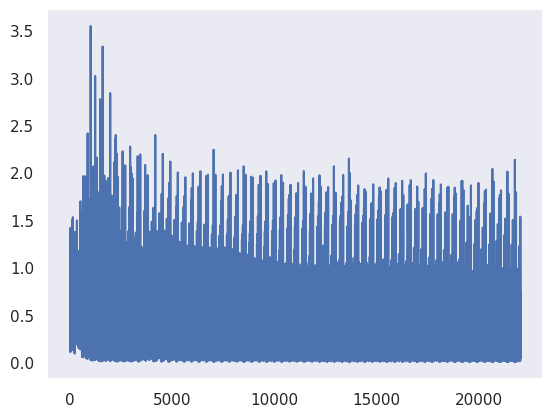

In [47]:
plt.plot(train_losses)

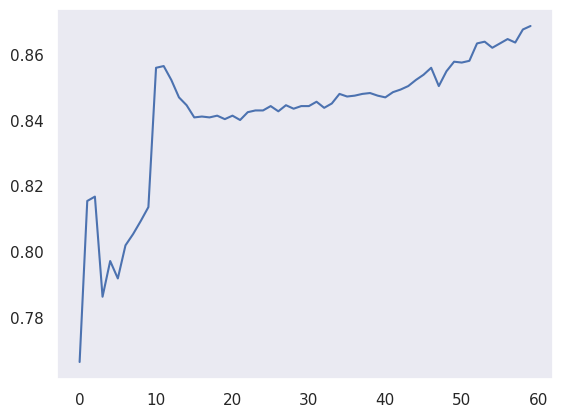

In [48]:
plt.plot(test_accuracy)

In [49]:
metrics2, confusion_matrix2 = report_metrics(model)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 3277/3744 (0.8753)
{'acc_detail': tensor([0.6364, 0.9463], device='cuda:0'),
 'acc_unweighted': tensor(0.7913, device='cuda:0'),
 'acc_weighted': tensor(0.8753, device='cuda:0'),
 'f1s': tensor(0.8108, device='cuda:0'),
 'f1s_detail': tensor([0.7004, 0.9212], device='cuda:0'),
 'precision_detail': tensor([0.7789, 0.8975], device='cuda:0'),
 'recall_detail': tensor([0.6364, 0.9463], device='cuda:0'),
 'rocauc': tensor([0.9251, 0.9251], device='cuda:0'),
 'uar': tensor(0.7913, device='cuda:0'),
 'wap': tensor(0.8703, device='cuda:0')}


tensor([[ 546,  312],
        [ 155, 2731]], device='cuda:0')

In [50]:
np.save('../physio16k_fold1_m13_60epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../physio16k_fold1_m13_60epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [51]:
EPOCH = 60
PATH = '../physio16k_fold1_m13_60epochs_state.pt' 
LOSS = train_losses[-1]

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [52]:
layer21 = model.fe_blocks.blocks[0].block.layer
visualize_model.print_parameters(layer21)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0036],
        [0.0075],
        [0.0117],
        [0.0162],
        [0.0211],
        [0.0264],
        [0.0322],
        [0.0384],
        [0.0451],
        [0.0524],
        [0.0603],
        [0.0688],
        [0.0780],
        [0.0880],
        [0.0988],
        [0.1105],
        [0.1231],
        [0.1368],
        [0.1516],
        [0.1676],
        [0.1849],
        [0.2036],
        [0.2239],
        [0.2458],
        [0.2696],
        [0.2952],
        [0.3230],
        [0.3531],
        [0.3856],
        [0.4208],
        [0.4588],
        [0.0000],
        [0.0054],
        [0.0111],
        [0.0171],
        [0.0235],
        [0.0303],
        [0.0375],
        [0.0452],
        [0.0534],
        [0.0620],
        [0.0712],
        [0.0809],
        [0.0912],
        [0.1022],
        [0.1138],
        [0.1261],
        [0.1392],
        [0.1531],
        [0.1679],
        [0.1835],
        [0.2002],
       

In [53]:
[print(p.grad) for p in layer21.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [-4.1114e-15],
        [-2.3472e-15],
        [-2.0090e-14],
        [ 3.7642e-18],
        [-7.2980e-16],
        [ 9.0261e-18],
        [ 5.9230e-17],
        [ 8.0498e-15],
        [ 8.3577e-15],
        [-3.2294e-18],
        [ 8.6431e-16],
        [ 1.8226e-17],
        [-2.7649e-15],
        [-7.3664e-17],
        [ 1.2378e-19],
        [-4.1142e-18],
        [-7.9142e-17],
        [-5.0758e-17],
        [-1.4757e-17],
        [-7.6435e-16],
        [ 2.4025e-17],
        [ 4.0213e-15],
        [ 2.9599e-17],
        [-7.1266e-16],
        [-6.6765e-16],
        [ 1.3751e-15],
        [ 1.7721e-16],
        [-7.0704e-19],
        [ 1.4080e-13],
        [-4.9364e-14],
        [-7.9093e-18],
        [ 0.0000e+00],
        [-1.9405e-15],
        [-7.7991e-17],
        [ 3.1587e-16],
        [ 7.1965e-14],
        [ 1.8485e-16],
        [ 4.7907e-15],
        [ 8.0093e-16],
        [-1.3075e-15],
        [-1.6896e-18],
        [ 1.6770e-18],
        [ 1

[None, None, None]

(array([11.,  7.,  5.,  6.,  4.,  7.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
         1.,  3.,  4.,  3.,  2.,  3.,  3.,  3.,  2.,  2.,  2.,  3.,  2.,
         1.,  4.,  0.,  4.,  0.,  3.,  2.,  2.,  1.,  2.,  2.,  1.,  2.,
         3.]),
 array([0.        , 0.01191887, 0.02383774, 0.03575661, 0.04767548,
        0.05959435, 0.07151322, 0.08343209, 0.09535096, 0.10726982,
        0.1191887 , 0.13110757, 0.14302644, 0.1549453 , 0.16686417,
        0.17878304, 0.19070192, 0.20262079, 0.21453965, 0.22645852,
        0.23837739, 0.25029626, 0.26221514, 0.27413401, 0.28605288,
        0.29797173, 0.3098906 , 0.32180947, 0.33372834, 0.34564722,
        0.35756609, 0.36948496, 0.38140383, 0.39332271, 0.40524158,
        0.41716045, 0.42907929, 0.44099817, 0.45291704, 0.46483591,
        0.47675478]),
 <BarContainer object of 40 artists>)

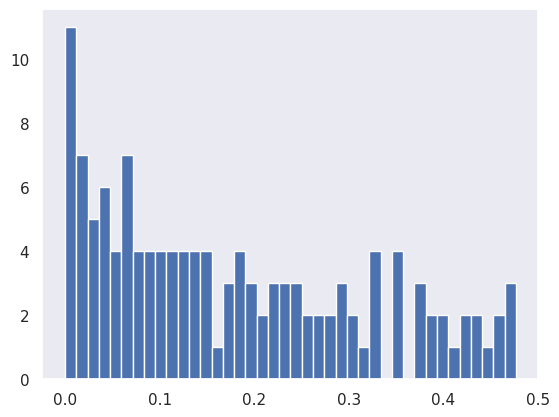

In [54]:
named_params21 = [p for p in layer21.named_parameters()]
lowbands21 = named_params21[0][1].detach().cpu().numpy()
plt.hist(lowbands21.flatten(), bins=40)

/tmp/ipykernel_94151/369886909.py:2: RuntimeWarning: divide by zero encountered in log
  lowbands21_grad = np.log(lowbands21_grad.flatten())
/tmp/ipykernel_94151/369886909.py:2: RuntimeWarning: invalid value encountered in log
  lowbands21_grad = np.log(lowbands21_grad.flatten())


(array([1., 1., 0., 0., 0., 0., 1., 1., 0., 2., 2., 1., 1., 2., 2., 3., 1.,
        1., 5., 2., 4., 2., 2., 2., 0., 3., 6., 0., 0., 1., 2., 4., 0., 1.,
        1., 0., 1., 0., 2., 1.]),
 array([-43.53577805, -43.18716812, -42.83856201, -42.48995209,
        -42.14134216, -41.79273605, -41.44412613, -41.0955162 ,
        -40.7469101 , -40.39830017, -40.04969025, -39.70108414,
        -39.35247421, -39.0038681 , -38.65525818, -38.30664825,
        -37.95804214, -37.60943222, -37.2608223 , -36.91221619,
        -36.56360626, -36.21499634, -35.86639023, -35.5177803 ,
        -35.16917038, -34.82056427, -34.47195435, -34.12334442,
        -33.77473831, -33.42612839, -33.07752228, -32.72891235,
        -32.38030243, -32.03169632, -31.6830864 , -31.33447647,
        -30.98586845, -30.63726044, -30.28865242, -29.9400425 ,
        -29.59143448]),
 <BarContainer object of 40 artists>)

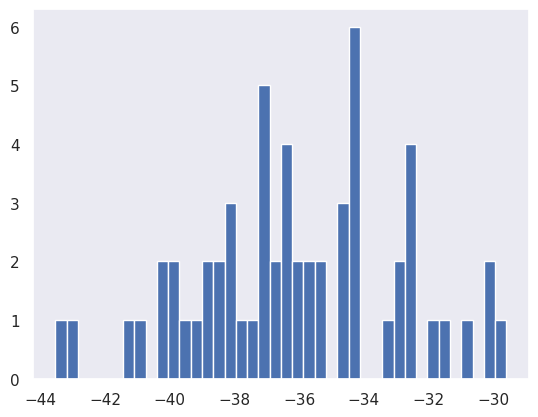

In [55]:
lowbands21_grad = named_params21[0][1].grad.detach().cpu().numpy()
lowbands21_grad = np.log(lowbands21_grad.flatten())
plt.hist(lowbands21_grad[lowbands21_grad > float('-inf')], bins=40)

(array([3., 4., 4., 5., 6., 6., 7., 8., 7., 5., 8., 6., 5., 5., 6., 3., 4.,
        5., 4., 4., 3., 3., 1., 3., 2., 2., 1., 0., 2., 0., 2., 0., 1., 1.,
        0., 0., 1., 0., 0., 1.]),
 array([0.0035846 , 0.00452443, 0.00546425, 0.00640408, 0.0073439 ,
        0.00828373, 0.00922356, 0.01016338, 0.01110321, 0.01204303,
        0.01298286, 0.01392268, 0.01486251, 0.01580233, 0.01674216,
        0.01768199, 0.01862181, 0.01956164, 0.02050146, 0.02144129,
        0.02238112, 0.02332094, 0.02426077, 0.02520059, 0.02614042,
        0.02708025, 0.02802007, 0.0289599 , 0.02989972, 0.03083955,
        0.03177937, 0.0327192 , 0.03365903, 0.03459885, 0.03553868,
        0.0364785 , 0.03741833, 0.03835815, 0.03929798, 0.0402378 ,
        0.04117763]),
 <BarContainer object of 40 artists>)

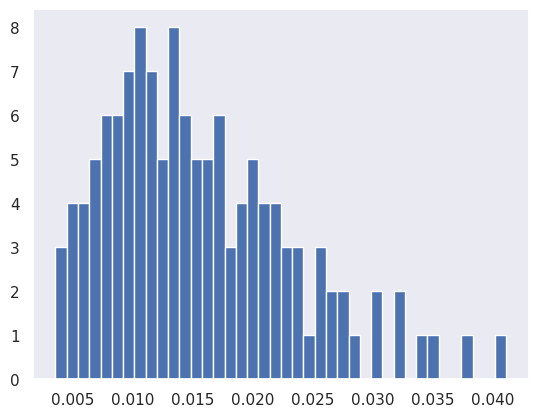

In [56]:
bandwidths21 = named_params21[1][1].detach().cpu().numpy()
plt.hist(bandwidths21.flatten(), bins=40)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   2., 119.,   0.,   2.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-3.76923665e-14, -3.32508476e-14, -2.88093253e-14, -2.43678064e-14,
        -1.99262875e-14, -1.54847669e-14, -1.10432471e-14, -6.60172778e-15,
        -2.16020782e-15,  2.28131214e-15,  6.72283189e-15,  1.11643516e-14,
         1.56058722e-14,  2.00473911e-14,  2.44889117e-14,  2.89304306e-14,
         3.33719495e-14,  3.78134718e-14,  4.22549907e-14,  4.66965096e-14,
         5.11380285e-14,  5.55795508e-14,  6.00210731e-14,  6.44625886e-14,
         6.89041109e-14,  7.33456264e-14,  7.77871487e-14,  8.22286710e-14,
         8.66701865e-14,  9.11117088e-14,  9.55532311e-14,  9.99947466e-14,
         1.04436269e-13,  1.08877791e-13,  1.13319307e-13,  1.17760822e-13,
         1.22202351e-13,  1.26643867e-13, 

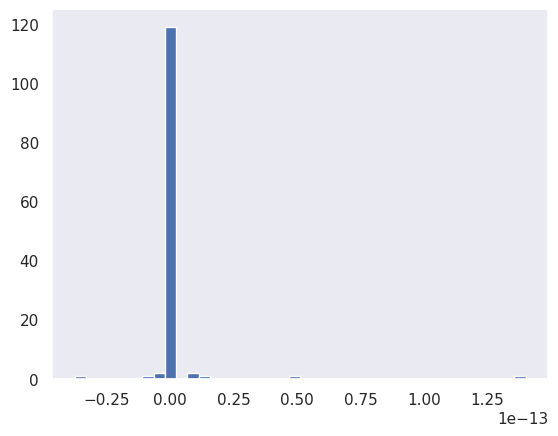

In [57]:
bandwidths21 = named_params21[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths21.flatten(), bins=40)

/tmp/ipykernel_94151/1282254287.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(bandwidths21.flatten()), bins=40)


(array([1., 0., 1., 0., 2., 0., 1., 3., 2., 3., 3., 3., 1., 3., 1., 0., 5.,
        5., 4., 2., 4., 3., 4., 2., 1., 2., 0., 0., 0., 3., 0., 0., 1., 1.,
        1., 0., 0., 1., 0., 1.]),
 array([-45.60643005, -45.20620346, -44.80597687, -44.40575027,
        -44.00552368, -43.60529709, -43.2050705 , -42.8048439 ,
        -42.40461731, -42.00439072, -41.60416412, -41.20393372,
        -40.80370712, -40.40348053, -40.00325394, -39.60302734,
        -39.20280075, -38.80257416, -38.40234756, -38.00212097,
        -37.60189438, -37.20166779, -36.80144119, -36.4012146 ,
        -36.00098801, -35.60076141, -35.20053482, -34.80030823,
        -34.40008163, -33.99985504, -33.59962463, -33.19939804,
        -32.79917145, -32.39894485, -31.99872017, -31.59849167,
        -31.19826508, -30.79803848, -30.39781189, -29.9975853 ,
        -29.5973587 ]),
 <BarContainer object of 40 artists>)

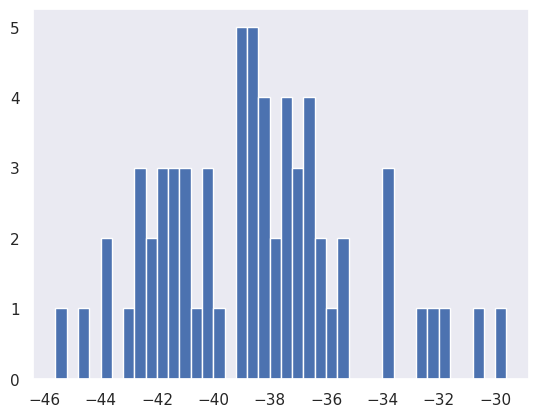

In [58]:
plt.hist(np.log(bandwidths21.flatten()), bins=40)

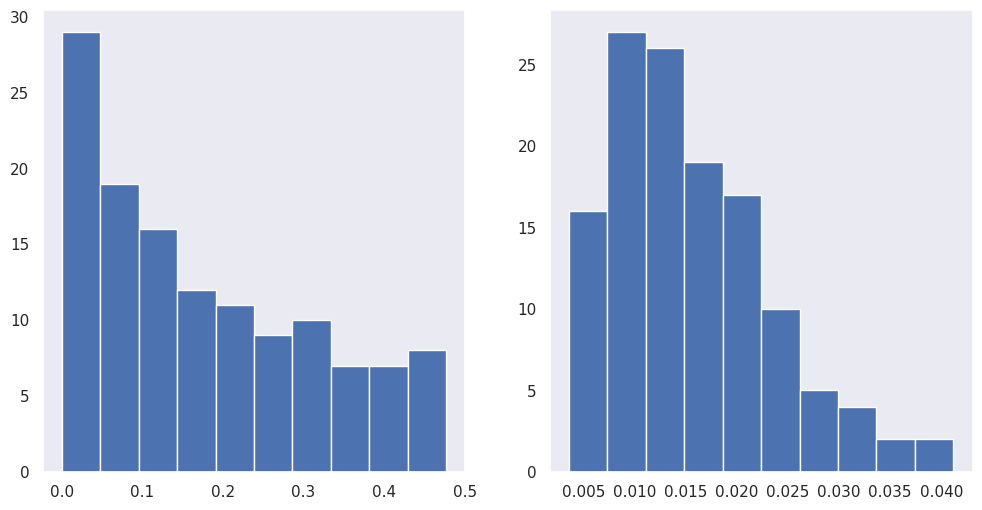

In [59]:
filtviz21 = visualize_model.FilterVisualizer(
    lowcut_bands = layer21.lowcut_bands, 
    bandwidths = layer21.bandwidths,
    window_params = layer21.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz21.visualize_bands()

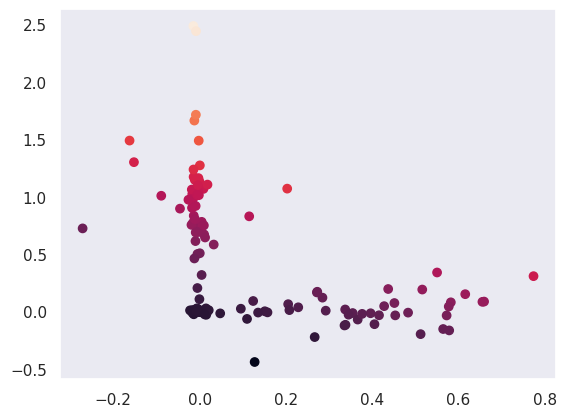

In [60]:
filtviz21.visualize_window_params()

Time domain: Filters' shapes vary by frequency bins


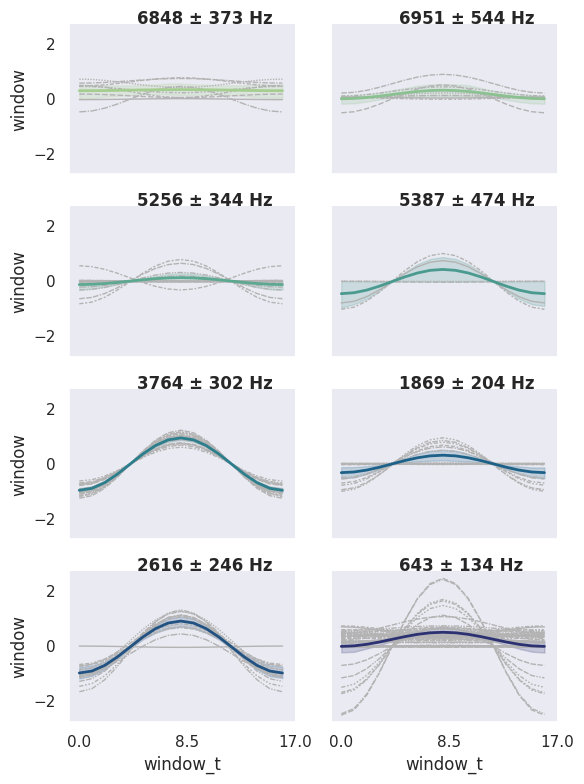

In [61]:
filtviz21.visualize_filters('time')

Frequency domain: Filters' shapes vary by frequency bins


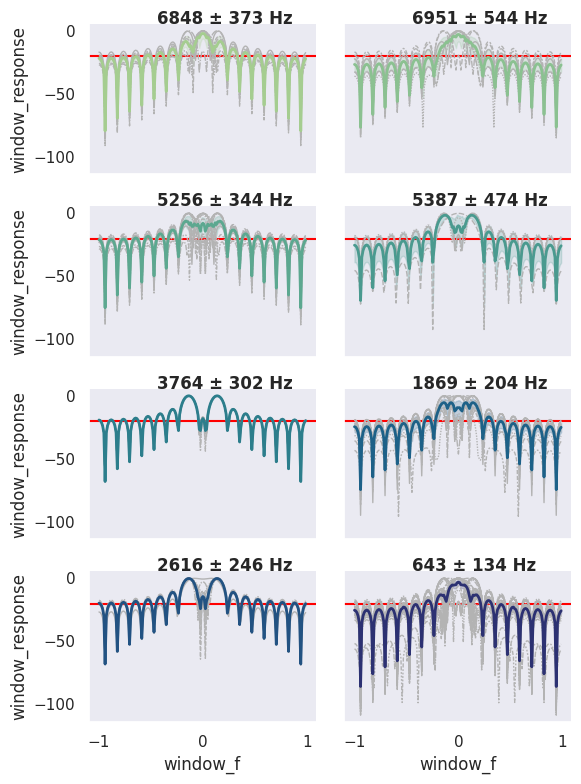

In [62]:
filtviz21.visualize_filters('freq')

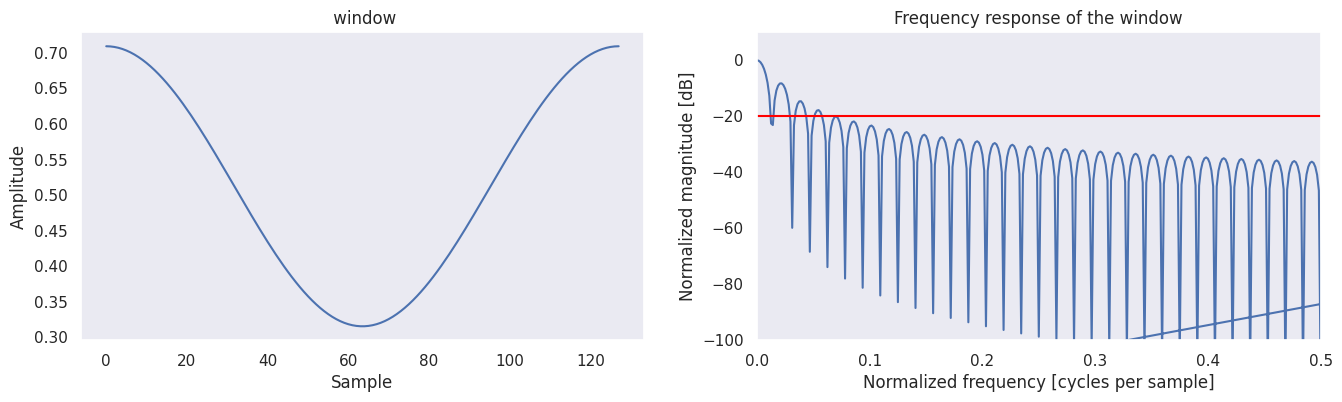

In [63]:
filtviz21.visualize_one_window()

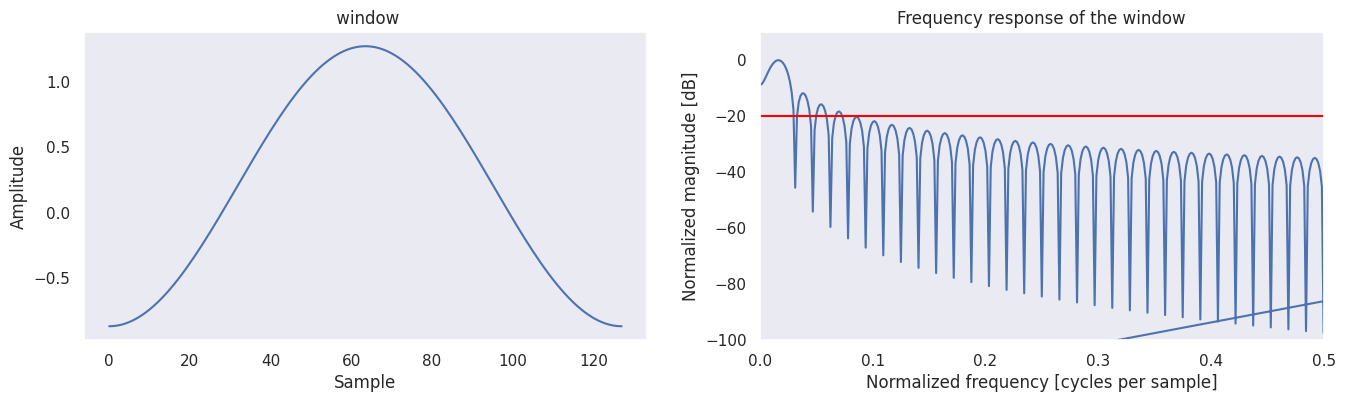

In [64]:
filtviz21.visualize_one_window(n_out=20)

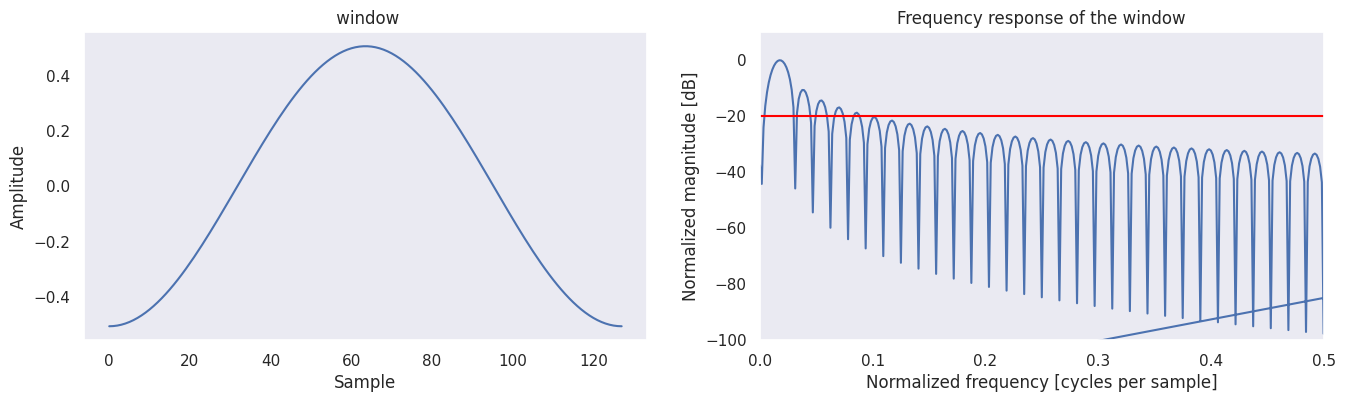

In [65]:
filtviz21.visualize_one_window(n_out=30)

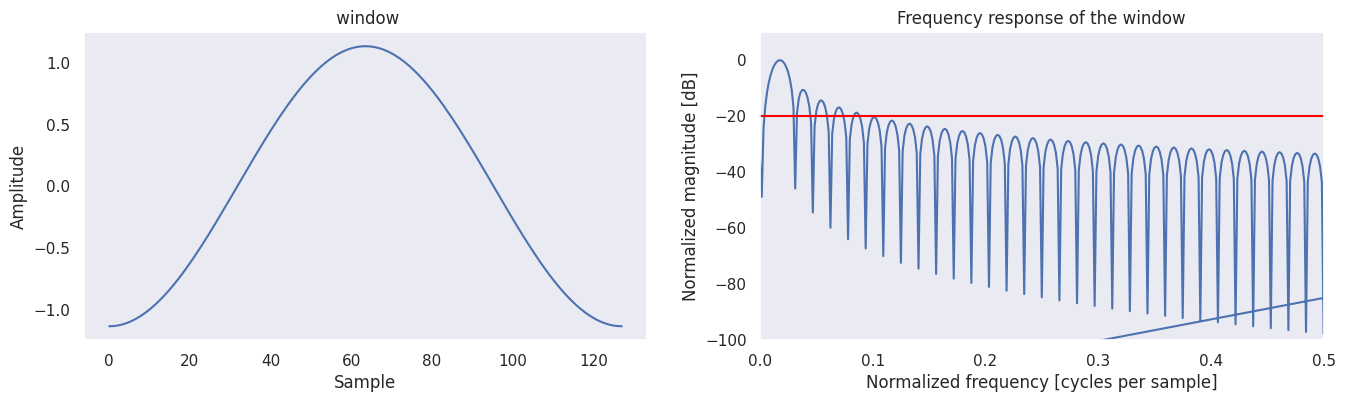

In [66]:
filtviz21.visualize_one_window(n_out=50)

In [67]:
layer22 = model.fe_blocks.blocks[1].block.layer
visualize_model.print_parameters(layer22)

('lowcut_bands', Parameter containing:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        [0.0384, 0.0384, 0.0384,  ..., 0.0384, 0.0384, 0.0384],
        ...,
        [0.2594, 0.2594, 0.2594,  ..., 0.2594, 0.2594, 0.2594],
        [0.3309, 0.3309, 0.3309,  ..., 0.3309, 0.3309, 0.3309],
        [0.4108, 0.4108, 0.4108,  ..., 0.4108, 0.4108, 0.4108]],
       device='cuda:0', requires_grad=True))
('bandwidths', Parameter containing:
tensor([[0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        [0.0222, 0.0222, 0.0222,  ..., 0.0222, 0.0222, 0.0222],
        [0.0304, 0.0304, 0.0304,  ..., 0.0304, 0.0304, 0.0304],
        ...,
        [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
        [0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799],
        [0.0892, 0.0892, 0.0892,  ..., 0.0892, 0.0892, 0.0892]],
       device='cuda:0', requires_grad=True))
('window_params', Parameter containing

(array([512., 128., 128., 384.,   0., 128., 256.,   0., 256.,   0., 128.,
        128.,   0., 256.,   0.,   0., 256.,   0.,   0., 256.,   0.,   0.,
        128., 128.,   0., 128.,   0., 128.,   0., 128.,   0.,   0., 128.,
          0., 128.,   0., 128.,   0., 128., 128.]),
 array([0.        , 0.0102691 , 0.02053821, 0.03080731, 0.04107642,
        0.05134552, 0.06161463, 0.07188373, 0.08215284, 0.09242194,
        0.10269105, 0.11296015, 0.12322926, 0.13349836, 0.14376746,
        0.15403657, 0.16430567, 0.17457478, 0.18484388, 0.19511299,
        0.20538209, 0.2156512 , 0.2259203 , 0.23618941, 0.24645852,
        0.25672761, 0.26699671, 0.27726582, 0.28753492, 0.29780403,
        0.30807313, 0.31834224, 0.32861134, 0.33888045, 0.34914955,
        0.35941866, 0.36968777, 0.37995687, 0.39022598, 0.40049508,
        0.41076419]),
 <BarContainer object of 40 artists>)

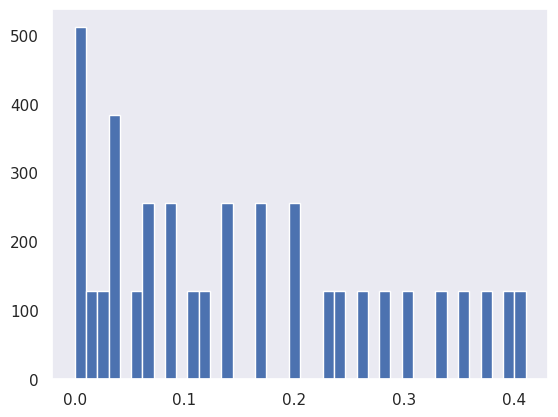

In [68]:
named_params22 = [p for p in layer22.named_parameters()]
lowbands22 = named_params22[0][1].detach().cpu().numpy()
plt.hist(lowbands22.flatten(), bins=40)

(array([1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        7.000e+00, 6.000e+00, 6.000e+00, 8.000e+00, 1.400e+01, 1.800e+01,
        3.800e+01, 1.600e+02, 3.685e+03, 7.600e+01, 2.300e+01, 1.700e+01,
        1.000e+01, 3.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 3.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([-1.90072965e-15, -1.82864207e-15, -1.75655437e-15, -1.68446668e-15,
        -1.61237899e-15, -1.54029130e-15, -1.46820371e-15, -1.39611602e-15,
        -1.32402833e-15, -1.25194064e-15, -1.17985305e-15, -1.10776536e-15,
        -1.03567767e-15, -9.63590081e-16, -8.91502389e-16, -8.19414697e-16,
        -7.47327058e-16, -6.75239366e-16, -6.03151727e-16, -5.31064035e-16,
        -4.58976396e-16, -3.86888731e-16, -3.14801065e-16, -2.42713400e-16,
        -1.70625748e-16, -9.85380824e-17, -2.6

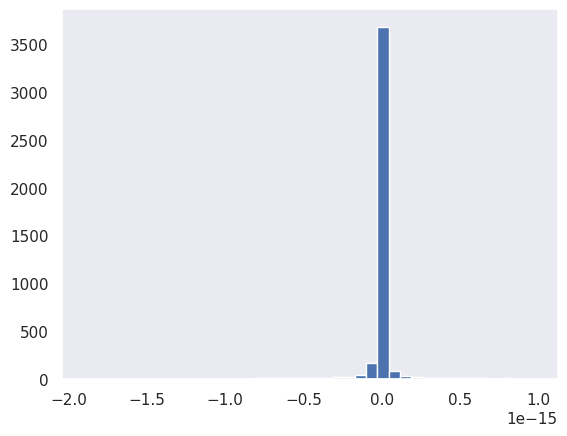

In [69]:
lowbands22 = named_params22[0][1].grad.detach().cpu().numpy()
plt.hist(lowbands22.flatten(), bins=40)

/tmp/ipykernel_94151/1558741381.py:1: RuntimeWarning: divide by zero encountered in log
  grad_log = np.log(lowbands22.flatten())
/tmp/ipykernel_94151/1558741381.py:1: RuntimeWarning: invalid value encountered in log
  grad_log = np.log(lowbands22.flatten())


(array([ 1.,  1.,  0.,  0.,  1.,  1.,  7.,  5., 11., 10., 15., 22., 47.,
        44., 49., 52., 66., 63., 48., 78., 69., 92., 77., 68., 79., 70.,
        89., 98., 79., 73., 68., 66., 51., 41., 30., 21., 20., 13.,  6.,
         7.]),
 array([-51.74294662, -51.3132782 , -50.88360596, -50.45393753,
        -50.02426529, -49.59459686, -49.16492844, -48.7352562 ,
        -48.30558777, -47.87591553, -47.4462471 , -47.01657867,
        -46.58690643, -46.15723801, -45.72756577, -45.29789734,
        -44.86822891, -44.43855667, -44.00888824, -43.579216  ,
        -43.14954758, -42.71987915, -42.29020691, -41.86053848,
        -41.43086624, -41.00119781, -40.57152939, -40.14185715,
        -39.71218872, -39.28251648, -38.85284805, -38.42317963,
        -37.99350739, -37.56383896, -37.13416672, -36.70449829,
        -36.27482986, -35.84515762, -35.4154892 , -34.98581696,
        -34.55614853]),
 <BarContainer object of 40 artists>)

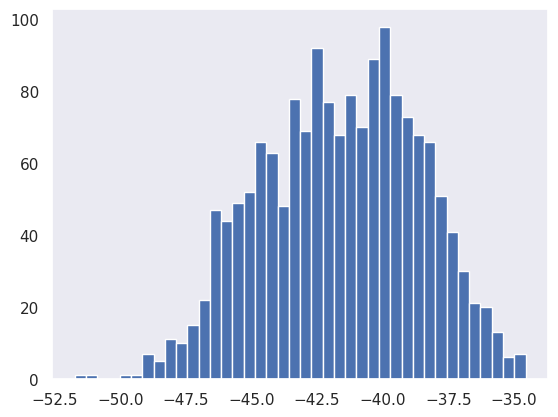

In [70]:
grad_log = np.log(lowbands22.flatten())
grad_log = grad_log[grad_log > float('-inf')]
plt.hist(grad_log, bins=40)

(array([128., 128., 128.,   0., 384.,   0., 256., 256., 128., 256., 128.,
        128., 256., 128., 256.,   0., 128., 128., 256., 128.,   0.,   0.,
        256.,   0.,   0., 128.,   0., 256.,   0.,   0.,   0.,   0.,   0.,
        128.,   0.,   0.,   0.,   0.,   0., 128.]),
 array([0.01619883, 0.01946704, 0.02273525, 0.02600346, 0.02927167,
        0.03253987, 0.03580808, 0.03907629, 0.0423445 , 0.04561271,
        0.04888092, 0.05214913, 0.05541734, 0.05868555, 0.06195376,
        0.06522197, 0.06849018, 0.07175838, 0.07502659, 0.0782948 ,
        0.08156301, 0.08483122, 0.08809943, 0.09136764, 0.09463584,
        0.09790406, 0.10117227, 0.10444047, 0.10770869, 0.11097689,
        0.1142451 , 0.11751331, 0.12078152, 0.12404973, 0.12731794,
        0.13058615, 0.13385436, 0.13712257, 0.14039077, 0.14365898,
        0.14692719]),
 <BarContainer object of 40 artists>)

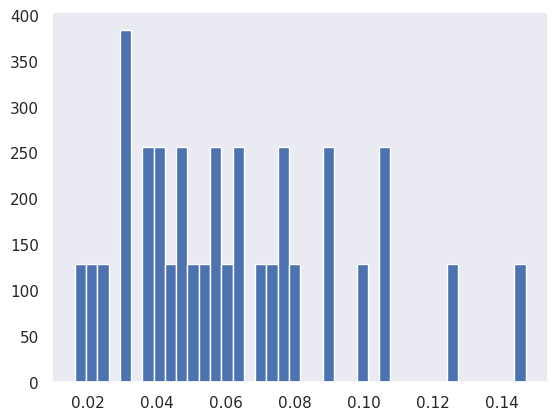

In [71]:
bandwidths22 = named_params22[1][1].detach().cpu().numpy()
plt.hist(bandwidths22.flatten(), bins=40)

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 7.000e+00,
        3.600e+01, 4.001e+03, 3.100e+01, 8.000e+00]),
 array([-1.49407328e-14, -1.45422005e-14, -1.41436681e-14, -1.37451357e-14,
        -1.33466033e-14, -1.29480709e-14, -1.25495385e-14, -1.21510061e-14,
        -1.17524746e-14, -1.13539422e-14, -1.09554098e-14, -1.05568774e-14,
        -1.01583450e-14, -9.75981262e-15, -9.36128023e-15, -8.96274784e-15,
        -8.56421545e-15, -8.16568306e-15, -7.76715067e-15, -7.36861828e-15,
        -6.97008632e-15, -6.57155393e-15, -6.17302154e-15, -5.77448915e-15,
        -5.37595676e-15, -4.97742437e-15, -4.5

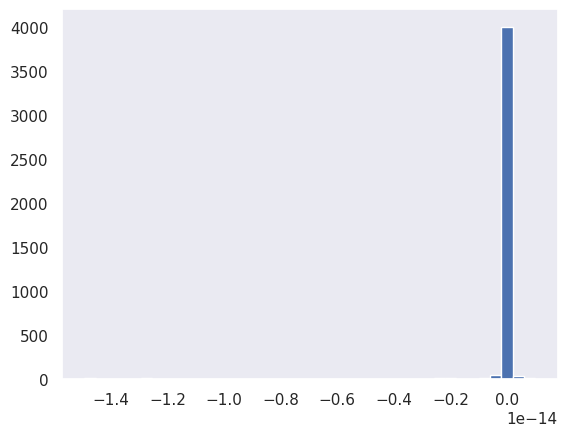

In [72]:
bandwidths22 = named_params22[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths22.flatten(), bins=40)

/tmp/ipykernel_94151/636885685.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(bandwidths22.flatten()), bins=40)


(array([  2.,   5.,   1.,   9.,   8.,   6.,  22.,  15.,  17.,  14.,  15.,
         39.,  51.,  58.,  81.,  96., 113.,  76.,  73.,  79.,  96.,  79.,
         96.,  92.,  85.,  93.,  83.,  93., 104.,  81.,  59.,  37.,  38.,
         33.,  18.,  26.,  16.,  16.,   9.,   6.]),
 array([-53.12373734, -52.65909958, -52.19446182, -51.72982407,
        -51.26518631, -50.80054855, -50.3359108 , -49.87126923,
        -49.40663147, -48.94199371, -48.47735596, -48.0127182 ,
        -47.54808044, -47.08344269, -46.61880493, -46.15416718,
        -45.68952942, -45.22489166, -44.76025391, -44.29561615,
        -43.83097839, -43.36633682, -42.90169907, -42.43706131,
        -41.97242355, -41.5077858 , -41.04314804, -40.57851028,
        -40.11387253, -39.64923477, -39.18459702, -38.71995926,
        -38.2553215 , -37.79068375, -37.32604218, -36.86140442,
        -36.39676666, -35.93212891, -35.46749115, -35.00285339,
        -34.53821564]),
 <BarContainer object of 40 artists>)

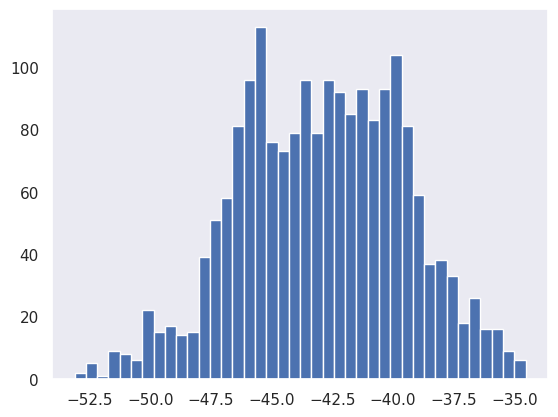

In [73]:
plt.hist(np.log(bandwidths22.flatten()), bins=40)

downsample_factor: 8 => new_sample_rate: 2000


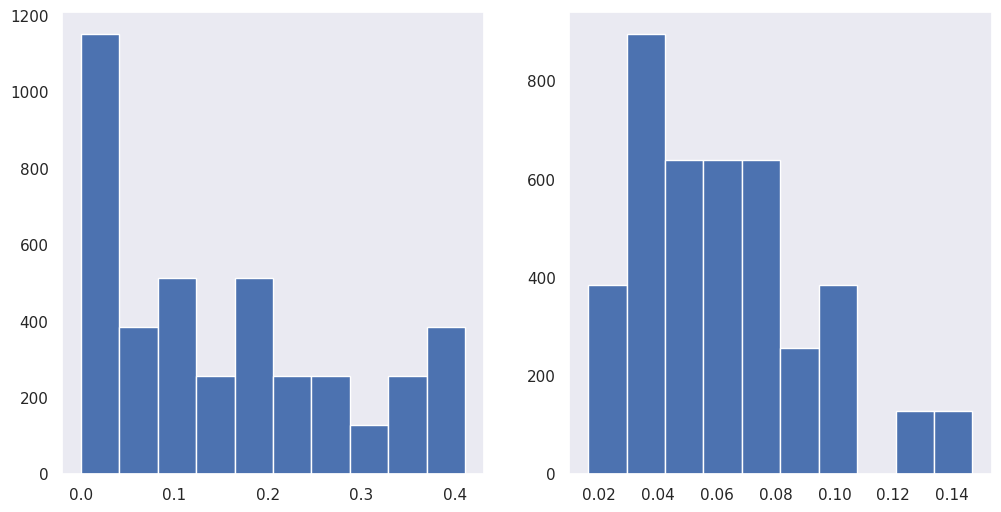

In [74]:
downsample_factor = model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz22 = visualize_model.FilterVisualizer(
    lowcut_bands = layer22.lowcut_bands, 
    bandwidths = layer22.bandwidths,
    window_params = layer22.window_params, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz22.visualize_bands()

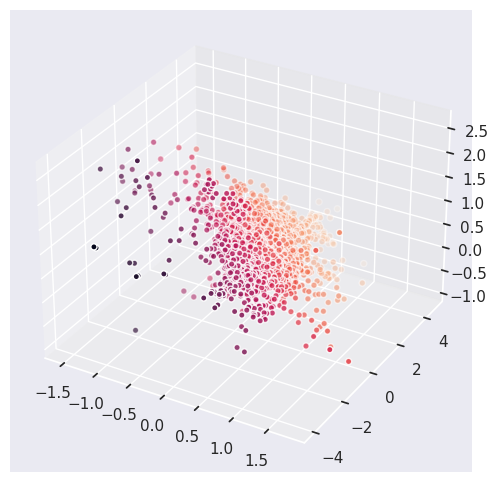

In [75]:
filtviz22.visualize_window_params()

Time domain: Filters' shapes vary by frequency bins


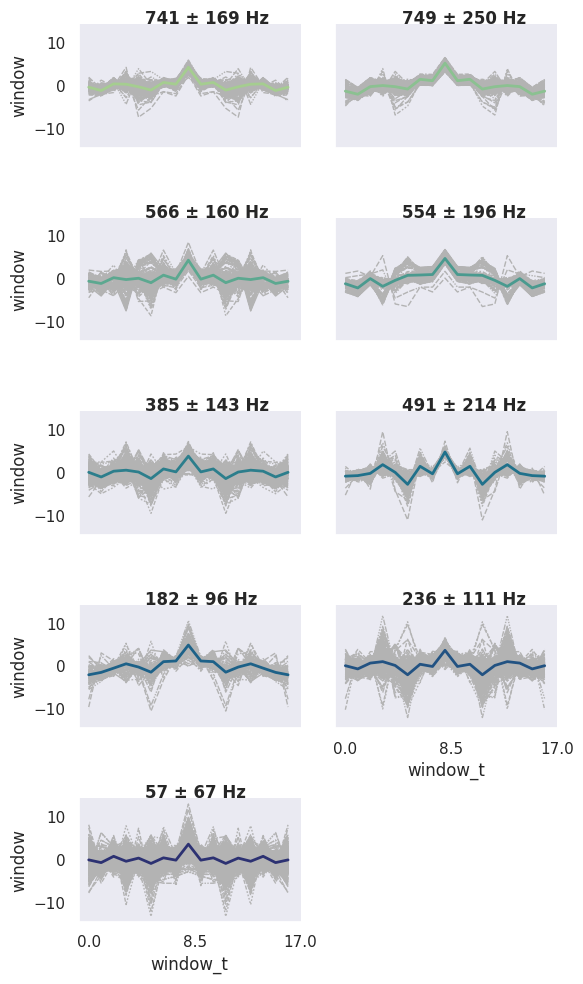

In [76]:
filtviz22.visualize_filters('time')

Frequency domain: Filters' shapes vary by frequency bins


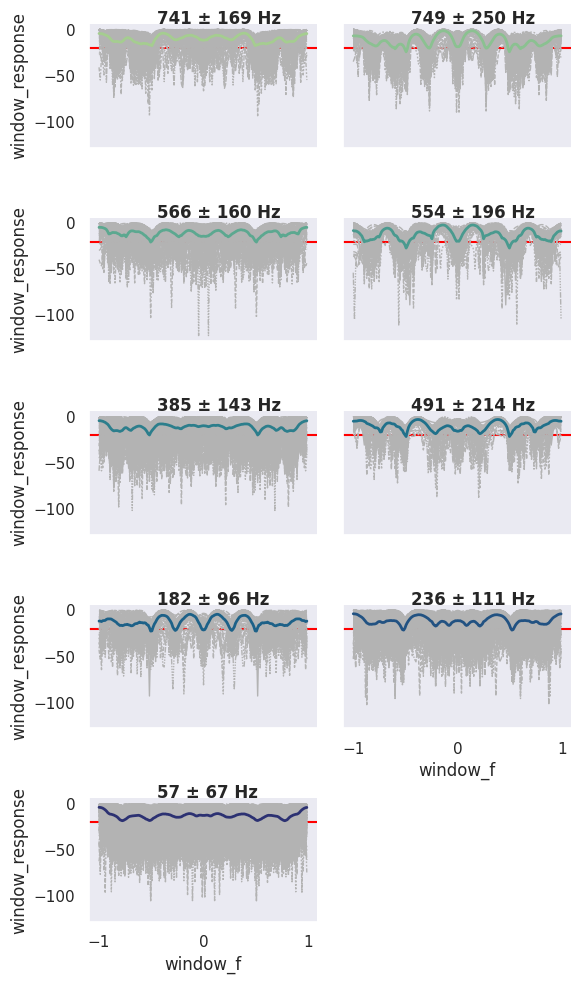

In [77]:
filtviz22.visualize_filters('freq')

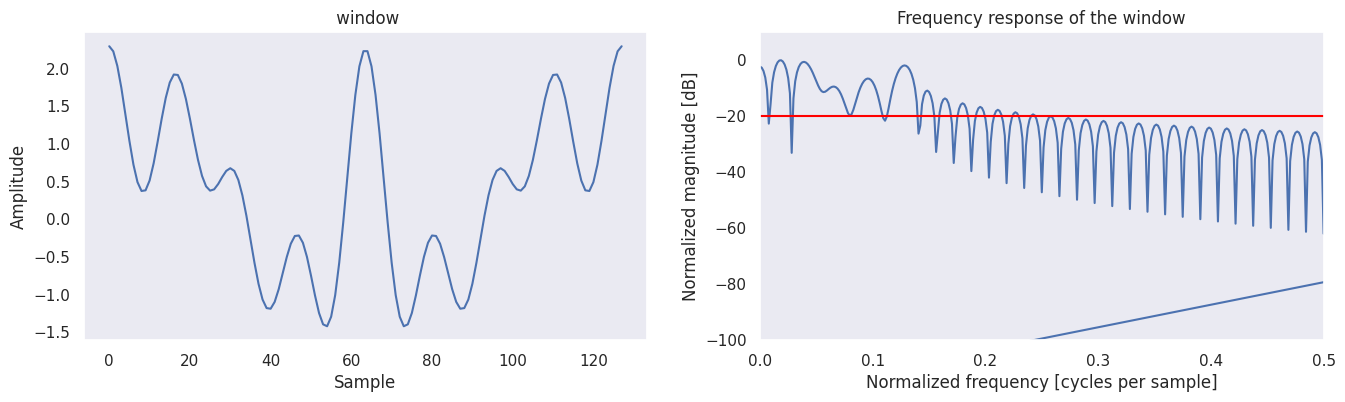

In [78]:
filtviz22.visualize_one_window(n_inp=0, n_out=0)

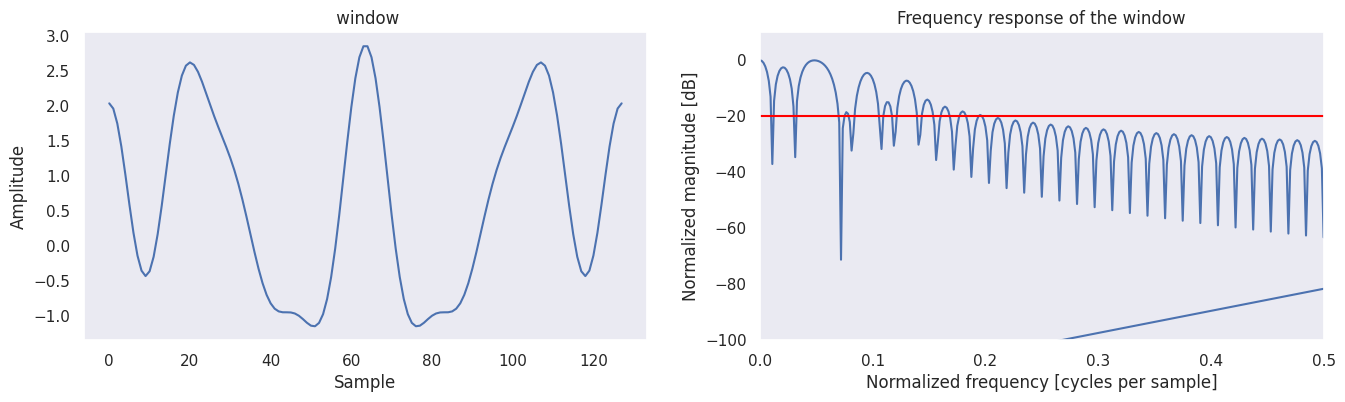

In [79]:
filtviz22.visualize_one_window(n_inp=0, n_out=10)

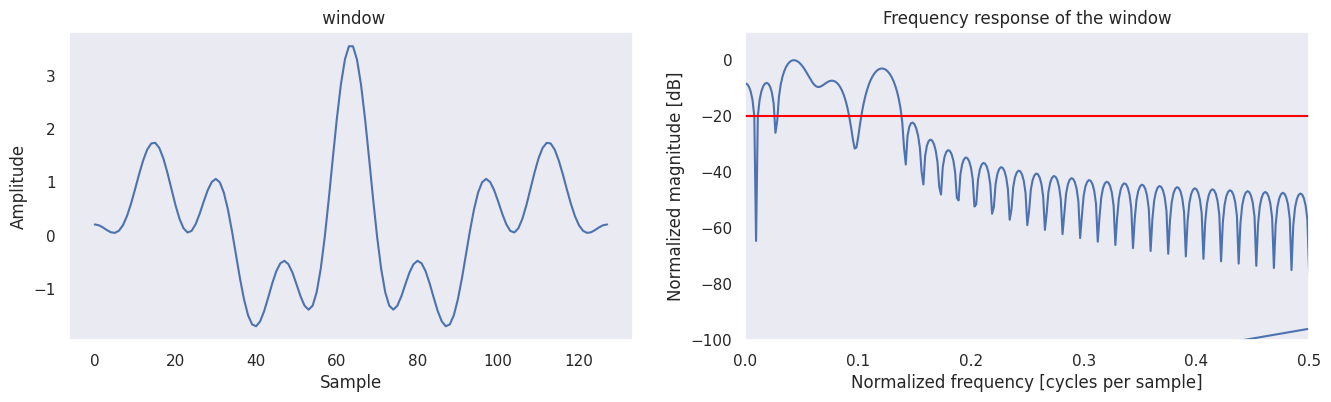

In [80]:
filtviz22.visualize_one_window(n_inp=10, n_out=10)

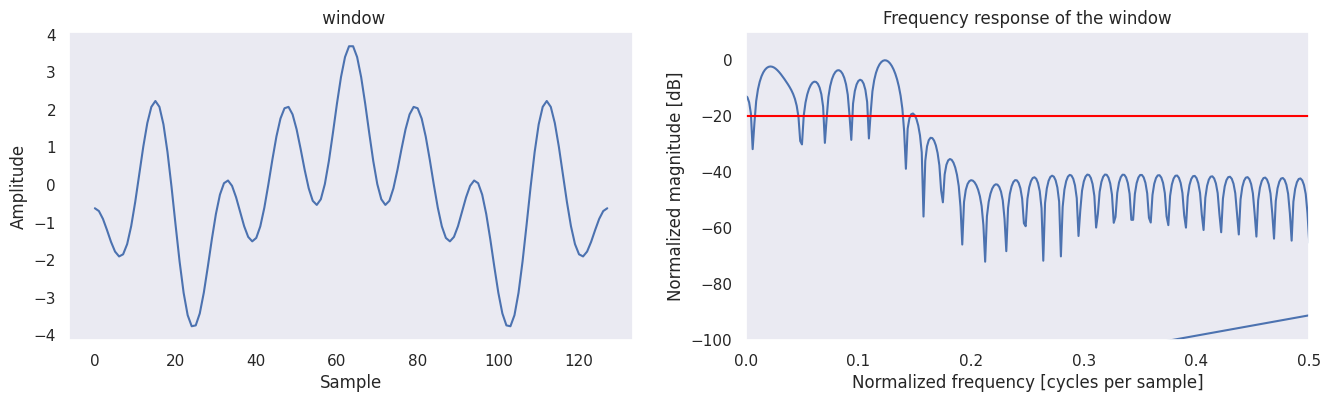

In [81]:
filtviz22.visualize_one_window(n_inp=60, n_out=10)

In [82]:
model.to('cpu')

M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm):